In [1]:
%cd ..

c:\Users\ernes\Documents\ML Projects\ds-project-test\ds-project-test


In [12]:
from src.ds_project.utils.utils import load_binary_data
from pathlib import Path

model_path=Path('artifact/model_validator/best_model/model.pkl')
model=load_binary_data(model_path)

2025-05-15 19:35:24 - INFO: utils - Binary file artifact\model_validator\best_model\model.pkl loaded successfully.


In [19]:
import pandas as pd

data_dir = Path('artifact/data_ingestion/train_data/train.csv')

data=pd.read_csv(data_dir)
data.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,Survived
0,-1.586525,0.489985,-0.492191,1.938885,0.737107,1.0,0.0,0.0,0.0,1.0,1
1,0.824587,0.097183,-0.492191,-0.476664,-0.473978,0.0,1.0,0.0,0.0,1.0,1
2,-0.380969,-1.238343,0.420413,-0.476664,-0.048763,1.0,0.0,1.0,0.0,0.0,1
3,0.824587,-0.766981,-0.492191,-0.476664,-0.490779,0.0,1.0,0.0,0.0,1.0,0
4,-1.586525,2.532555,-0.492191,-0.476664,0.909914,1.0,0.0,0.0,0.0,1.0,1


In [20]:
import shap

x_train = data.drop(['Survived'], axis=1)
x_train_sample = x_train.sample(100)

explainer = shap.Explainer(model.predict, x_train_sample)
explained = explainer(x_train)

ExactExplainer explainer: 713it [00:16, 32.42it/s]                         


In [5]:
data.columns

Index(['num__Pclass', 'num__Age', 'num__SibSp', 'num__Parch', 'num__Fare',
       'cat__Sex_female', 'cat__Sex_male', 'cat__Embarked_C',
       'cat__Embarked_Q', 'cat__Embarked_S', 'Survived'],
      dtype='object')

.values =
array([[ 1.96000000e-01, -1.27000000e-01, -3.93333333e-02,
         4.54761905e-03,  9.50000000e-03, -1.42333333e-01,
        -1.40500000e-01,  3.46944695e-18,  0.00000000e+00,
        -4.08809524e-02]])

.base_values =
array([0.28])

.data =
array([[-1.58652527,  0.56854551,  0.42041333, -0.47666366,  0.39341414,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ]])


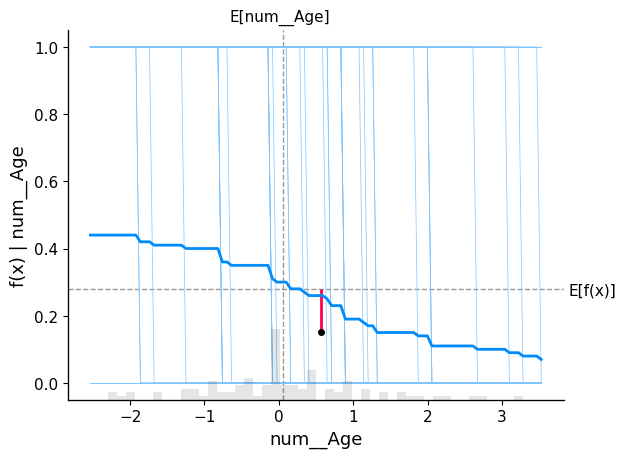

In [6]:
idx=41

print(explained[idx:idx+1, :])
shap.partial_dependence_plot(
    'num__Age',
    model.predict,
    x_train_sample,
    model_expected_value=True,
    feature_expected_value=True,
    shap_values=explained[idx: idx+1, :]
)

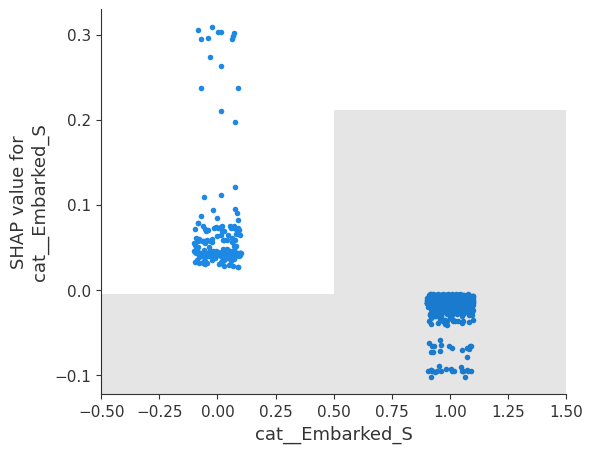

In [7]:
shap.plots.scatter(explained[:, 'cat__Embarked_S'])

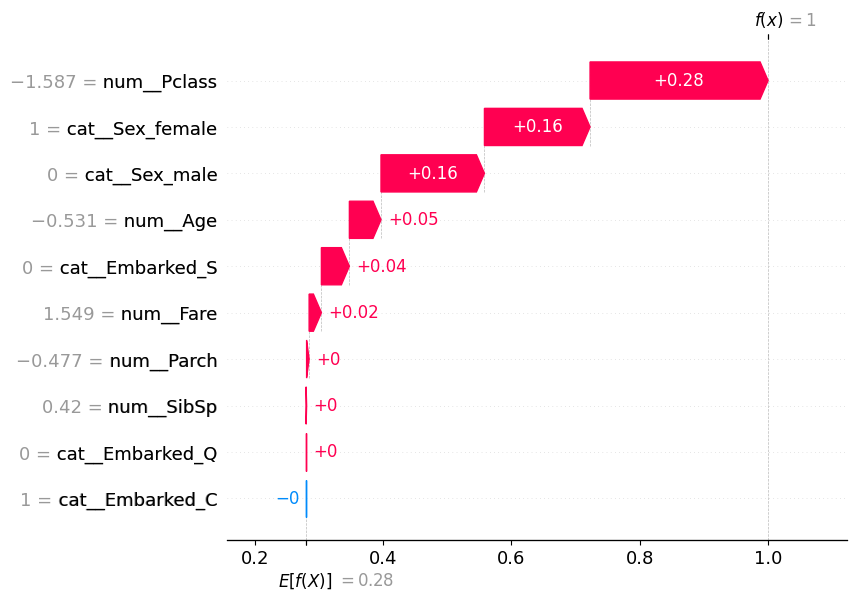

In [8]:
shap.plots.waterfall(explained[idx+10])

In [9]:
for i in range(x_train.shape[1]):
    print(f"{x_train.columns[i]} : {model.coef_[0][i]}")

num__Pclass : -0.9381635005505206
num__Age : -0.3930522438955409
num__SibSp : -0.33780230415390744
num__Parch : -0.09723649685000829
num__Fare : 0.10126310116345864
cat__Sex_female : 1.3682330880968392
cat__Sex_male : -1.3189861679935282
cat__Embarked_C : 0.0
cat__Embarked_Q : 0.0
cat__Embarked_S : -0.46305028708135965


In [10]:
import matplotlib.pyplot as plt

cmap=plt.cm.RdYlBu
norm=plt.Normalize(vmin=min(model.coef_[0]), vmax=max(model.coef_[0]))

In [11]:
norm(model.coef_[0])

masked_array(data=[0.14171626, 0.34456955, 0.36512981, 0.45465202,
                   0.52852006, 1.        , 0.        , 0.49083683,
                   0.49083683, 0.31852104],
             mask=False,
       fill_value=1e+20)

In [12]:
coefs = pd.DataFrame(model.coef_, columns=model.feature_names_in_, index=['coeffs']).T.sort_values('coeffs', ascending=False)

In [13]:
coefs.index

Index(['cat__Sex_female', 'num__Fare', 'cat__Embarked_Q', 'cat__Embarked_C',
       'num__Parch', 'num__SibSp', 'num__Age', 'cat__Embarked_S',
       'num__Pclass', 'cat__Sex_male'],
      dtype='object')

In [14]:
def reformat_columns(columns):
    reformated = [col.replace('cat__', '') for col in columns]
    reformated = [col.replace('num__','') for col in reformated]

    return reformated

In [15]:
reformatted_cols = reformat_columns(coefs.index)

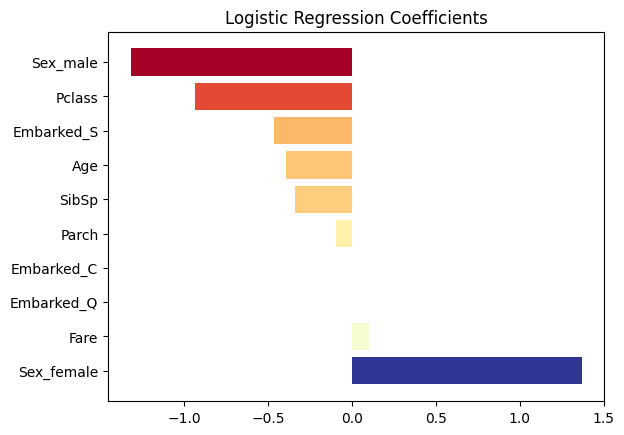

In [16]:
plt.barh(reformatted_cols, coefs.values.reshape(-1), color=cmap(norm(coefs.values.reshape(-1))))
plt.title('Logistic Regression Coefficients')
plt.show()

In [17]:
model.feature_names_in_

array(['num__Pclass', 'num__Age', 'num__SibSp', 'num__Parch', 'num__Fare',
       'cat__Sex_female', 'cat__Sex_male', 'cat__Embarked_C',
       'cat__Embarked_Q', 'cat__Embarked_S'], dtype=object)

In [1]:
%cd ..

c:\Users\ernes\Documents\ML Projects\ds-project-test\ds-project-test


In [36]:
from dataclasses import dataclass
from pathlib import Path

@dataclass
class ExplainerConfig:
    explainer_path: Path
    model_type: str
    best_model_path: Path

In [55]:
from src.ds_project.constants import CONFIG_FILE_PATH, CONFIG_TRAINING_FILE_PATH
from src.ds_project.utils.utils import read_yaml, create_directories
import shap


class ExplainerManager:
    def __init__(self,
                 config_path = CONFIG_FILE_PATH,
                 config_training_path=CONFIG_TRAINING_FILE_PATH
                 ):
        self.config=read_yaml(config_path)
        self.config_training=read_yaml(config_training_path)

        create_directories([self.config.explainer.directory])


    def get_explainer_config(self):
        config = ExplainerConfig(
            explainer_path=Path(self.config.explainer['explainer_path']),
            model_type=self.config_training.training['default_model'],
            best_model_path=Path(self.config.serving['serving_model'])
        )

        return config

In [56]:
import shap
from src.ds_project.utils.utils import load_binary_data

class ExplainerModel:
    def __init__(self, config:ExplainerConfig):
        self.config=config

    def get_explainer(self,x, model=None):
        if model is None:
            model=load_binary_data(self.config.best_model_path)

        if self.config.model_type =='LOGISTIC_REGRESSION':
            explainer=shap.LinearExplainer(model, x)
        elif self.config.model_type == 'GRADIENT_BOOSTING':
            explainer=shap.TreeExplainer(model, x)
        else:
            explainer = shap.KernelExplainer(model.predict, x)
        
        return explainer


In [57]:
from src.ds_project.utils.utils import load_binary_data, save_binary_data
from src.ds_project import logger


class Explainer:
    def __init__(self,config: ExplainerConfig):
        self.config=config
        self.explainer = None

    def create_explainer(self, x_train, model=None):
        # create a Explainer Object
        x_train=x_train.sample(frac=0.2)

        explainer_config = ExplainerModel(self.config)
        explainer = explainer_config.get_explainer(x=x_train,model=model)
        
        #save explainer
        self.explainer=explainer
        logger.info('Model explainer created')
    
    def create_and_save_explainer(self, x):
        if self.explainer is None:
            self.create_explainer(x)
        
        save_binary_data(self.config.explainer_path, self.explainer, as_pickle=True)
        logger.info(f'Explainer saved at {self.config.explainer_path}')


In [58]:
x_train_sample

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
419,0.824587,1.757436e-01,-0.492191,-0.476664,-0.475338,0.0,1.0,0.0,0.0,1.0
207,0.824587,-3.741792e-01,-0.492191,-0.476664,-0.477498,0.0,1.0,0.0,1.0,0.0
346,0.824587,-5.582051e-16,0.420413,-0.476664,-0.348613,1.0,0.0,1.0,0.0,0.0
291,-1.586525,1.825512e+00,1.333018,-0.476664,0.362294,1.0,0.0,0.0,0.0,1.0
326,-1.586525,2.218314e+00,-0.492191,0.731110,2.320447,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
526,0.824587,4.114247e-01,-0.492191,-0.476664,-0.490779,0.0,1.0,0.0,0.0,1.0
589,-1.586525,-5.582051e-16,0.420413,-0.476664,0.372293,1.0,0.0,0.0,0.0,1.0
437,0.824587,1.668391e+00,-0.492191,-0.476664,-0.490698,0.0,1.0,0.0,0.0,1.0
618,-0.380969,1.432710e+00,-0.492191,-0.476664,-0.376535,0.0,1.0,0.0,0.0,1.0


In [65]:
config = ExplainerManager().get_explainer_config()
explainer = Explainer(config)

explainer.create_and_save_explainer(x_train)

2025-05-15 20:51:35 - INFO: utils - YAML file config\config.yaml loaded successfully.
2025-05-15 20:51:35 - INFO: utils - YAML file config\training_config.yaml loaded successfully.
2025-05-15 20:51:35 - INFO: utils - Directory artifact/explainer created.
2025-05-15 20:51:35 - INFO: utils - Binary file artifact\model_validator\best_model\model.pkl loaded successfully.
2025-05-15 20:51:35 - WARNING: _kernel - Using 142 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
2025-05-15 20:51:35 - INFO: 3223142165 - Model explainer created
2025-05-15 20:51:35 - INFO: utils - Binary file artifact\explainer\explainer.pkl saved successfully.
2025-05-15 20:51:35 - INFO: 3223142165 - Explainer saved at artifact\explainer\explainer.pkl


In [66]:
config.model_type

'RANDOM_FOREST'

In [67]:
explain = load_binary_data(config.explainer_path)

explain

2025-05-15 20:51:40 - INFO: utils - Binary file artifact\explainer\explainer.pkl loaded successfully.


  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:46 - INFO: _kernel - phi = array([-0.09306673,  0.00627934,  0.02195674,  0.01127599, -0.01417673,
       -0.14299966, -0.13607478,  0.        ,  0.        , -0.01234909])
2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:46 - INFO: _kernel - phi = array([-0.17382629,  0.04948021,  0.02074111,  0.00933937, -0.0101442 ,
       -0.14414822, -0.13586519,  0.        ,  0.        ,  0.02526828])


  2%|▏         | 2/100 [00:00<00:04, 19.78it/s]

2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:46 - INFO: _kernel - phi = array([-0.1185949 ,  0.06224011,  0.00511402,  0.03457411, -0.00677398,
        0.30618712,  0.30254863,  0.        ,  0.        ,  0.05554997])
2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:46 - INFO: _kernel - phi = array([ 0.39227867, -0.12455567, -0.08711435,  0.01343897,  0.017111  ,
        0.28964621,  0.16141013,  0.        ,  0.        , -0.02136989])


  4%|▍         | 4/100 [00:00<00:04, 19.84it/s]

2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:46 - INFO: _kernel - phi = array([ 0.39975687, -0.14455902,  0.02572938, -0.00503856,  0.03049128,
        0.17774145,  0.17086687,  0.        ,  0.        , -0.01414319])
2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:46 - INFO: _kernel - phi = array([-0.11640677,  0.04501174,  0.0466717 ,  0.01913984, -0.00872736,
        0.31001844,  0.30632964,  0.        ,  0.        ,  0.03880785])
2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

  7%|▋         | 7/100 [00:00<00:04, 19.57it/s]

2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:46 - INFO: _kernel - phi = array([ 0.23100268,  0.01056338,  0.02790074,  0.01185446, -0.00114017,
        0.15886989,  0.1555332 ,  0.        ,  0.        ,  0.0462609 ])
2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:46 - INFO: _kernel - phi = array([-0.02768276,  0.06991952,  0.03162307,  0.01574447, -0.01371563,
       -0.22042254, -0.20600268,  0.        ,  0.        , -0.00861838])


  9%|▉         | 9/100 [00:00<00:04, 18.74it/s]

2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:46 - INFO: _kernel - phi = array([-0.09984909,  0.09084507, -0.1295104 , -0.00046948, -0.00437626,
       -0.12860496, -0.11953387,  0.        ,  0.        ,  0.03234406])
2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:46 - INFO: _kernel - phi = array([ 0.23937793,  0.01830148, -0.00758719,  0.0125503 ,  0.01340543,
        0.1579896 ,  0.15510563,  0.        ,  0.        ,  0.05170188])
2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 12%|█▏        | 12/100 [00:00<00:04, 20.13it/s]

2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:46 - INFO: _kernel - phi = array([-0.03252012,  0.08501844,  0.02494131,  0.01082327, -0.01415996,
       -0.21771462, -0.20874413,  0.        ,  0.        , -0.00679913])
2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:46 - INFO: _kernel - phi = array([-0.12600604,  0.13777666,  0.05447686, -0.00268276, -0.01068075,
        0.30093897,  0.29384641,  0.        ,  0.        , -0.00682428])
2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 15%|█▌        | 15/100 [00:00<00:04, 20.19it/s]

2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:46 - INFO: _kernel - phi = array([ 0.19653876, -0.11944045, -0.01194548,  0.00931542,  0.        ,
        0.30029462,  0.29137444,  0.        ,  0.        , -0.02529223])
2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:46 - INFO: _kernel - phi = array([-0.09809691,  0.01704393,  0.02209088,  0.01248323, -0.0188548 ,
       -0.14509557, -0.13770121,  0.        ,  0.        , -0.01102448])
2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 18%|█▊        | 18/100 [00:00<00:03, 20.92it/s]

2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:46 - INFO: _kernel - phi = array([-0.1612173 ,  0.02511737,  0.02142857,  0.0102448 , -0.01150235,
       -0.14372904, -0.13618377,  0.        ,  0.        ,  0.03668679])
2025-05-15 20:51:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:46 - INFO: _kernel - phi = array([-0.17562039,  0.05580148,  0.01906439,  0.00861838, -0.01052985,
       -0.14453387, -0.1361167 ,  0.        ,  0.        ,  0.02416164])
2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 21%|██        | 21/100 [00:01<00:03, 21.42it/s]

2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:47 - INFO: _kernel - phi = array([-0.11640677,  0.04494467,  0.04660463,  0.01919014, -0.00867706,
        0.31006875,  0.30637995,  0.        ,  0.        ,  0.03874078])
2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:47 - INFO: _kernel - phi = array([-0.09809691,  0.01704393,  0.02209088,  0.01248323, -0.0188548 ,
       -0.14509557, -0.13770121,  0.        ,  0.        , -0.01102448])
2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 24%|██▍       | 24/100 [00:01<00:04, 17.73it/s]

2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:47 - INFO: _kernel - phi = array([ 0.24213615,  0.04974849, -0.00528169,  0.0091717 ,  0.01775654,
        0.14637827,  0.14314219,  0.        ,  0.        ,  0.03779343])
2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:47 - INFO: _kernel - phi = array([ 0.3908786 , -0.11911469,  0.02208249,  0.01058015, -0.00117371,
        0.18123742,  0.17712944,  0.        ,  0.        , -0.02077465])
2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 27%|██▋       | 27/100 [00:01<00:03, 18.87it/s]

2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:47 - INFO: _kernel - phi = array([ 0.46806673,  0.04388833,  0.05547451,  0.01727867, -0.00949866,
       -0.11080651, -0.10477029,  0.        ,  0.        ,  0.28121227])
2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:47 - INFO: _kernel - phi = array([ 0.09627767,  0.08060027, -0.00539906,  0.01027834,  0.00285044,
        0.21639839,  0.20301811,  0.        ,  0.        ,  0.03682093])
2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 30%|███       | 30/100 [00:01<00:03, 19.81it/s]

2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:47 - INFO: _kernel - phi = array([-0.11640677,  0.04494467,  0.04660463,  0.01919014, -0.00867706,
        0.31006875,  0.30637995,  0.        ,  0.        ,  0.03874078])
2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:47 - INFO: _kernel - phi = array([-0.13538732,  0.26660798, -0.01665828, -0.01410966, -0.01048793,
        0.28669517,  0.28176559,  0.        ,  0.        , -0.01758048])
2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 33%|███▎      | 33/100 [00:01<00:03, 20.66it/s]

2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:47 - INFO: _kernel - phi = array([-0.07825285, -0.01317907,  0.01965124,  0.01031187, -0.01168679,
       -0.14009054, -0.13363514,  0.        ,  0.        , -0.01227364])
2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:47 - INFO: _kernel - phi = array([-0.23210094,  0.12009557, -0.4198776 , -0.01935781, -0.0068662 ,
        0.13412978,  0.12943494,  0.        ,  0.        , -0.06461268])
2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 36%|███▌      | 36/100 [00:01<00:03, 21.15it/s]

2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:47 - INFO: _kernel - phi = array([ 0.24812207,  0.08591549, -0.00598592,  0.01267606,  0.0064554 ,
        0.15223005,  0.14894366,  0.        ,  0.        , -0.00751174])
2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:47 - INFO: _kernel - phi = array([-0.02867203,  0.06205567,  0.03672032,  0.0167002 , -0.01188799,
       -0.21837693, -0.20623742,  0.        ,  0.        , -0.00945674])
2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 39%|███▉      | 39/100 [00:01<00:02, 21.35it/s]

2025-05-15 20:51:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:48 - INFO: _kernel - phi = array([-0.22057344, -0.18289738, -0.19666331,  0.02010396, -0.02820255,
        0.1602951 ,  0.15630449,  0.        ,  0.        , -0.0675218 ])
2025-05-15 20:51:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:48 - INFO: _kernel - phi = array([ 0.2158283 , -0.19230382,  0.02847082,  0.00980885, -0.00814889,
       -0.19699866, -0.19136486,  0.        ,  0.        , -0.02444668])
2025-05-15 20:51:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 42%|████▏     | 42/100 [00:02<00:03, 18.41it/s]

2025-05-15 20:51:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:48 - INFO: _kernel - phi = array([ 0.21227364, -0.09574111,  0.03900067,  0.01557679, -0.05560027,
       -0.19832327, -0.1925721 ,  0.        ,  0.        , -0.08376928])
2025-05-15 20:51:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:48 - INFO: _kernel - phi = array([ 0.23192488, -0.24946345,  0.03033199,  0.01037894,  0.01732059,
       -0.19382964, -0.1879611 ,  0.        ,  0.        , -0.01785714])


 44%|████▍     | 44/100 [00:02<00:03, 18.39it/s]

2025-05-15 20:51:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:48 - INFO: _kernel - phi = array([ 0.21591214, -0.19327632,  0.02796781,  0.00994299, -0.00783032,
       -0.19691482, -0.19116365,  0.        ,  0.        , -0.02379276])
2025-05-15 20:51:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:48 - INFO: _kernel - phi = array([-0.08080148, -0.00980885,  0.02002012,  0.01078135, -0.01441985,
       -0.14242119, -0.13044936,  0.        ,  0.        , -0.01205567])


 46%|████▌     | 46/100 [00:02<00:02, 18.05it/s]

2025-05-15 20:51:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:48 - INFO: _kernel - phi = array([-0.09809691,  0.01704393,  0.02209088,  0.01248323, -0.0188548 ,
       -0.14509557, -0.13770121,  0.        ,  0.        , -0.01102448])
2025-05-15 20:51:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:48 - INFO: _kernel - phi = array([-0.09853286,  0.01766432,  0.02224178,  0.01181254, -0.01846915,
       -0.1448273 , -0.13813716,  0.        ,  0.        , -0.01090711])


 48%|████▊     | 48/100 [00:02<00:02, 18.29it/s]

2025-05-15 20:51:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:48 - INFO: _kernel - phi = array([-0.26579477, -0.19778672, -0.0278672 , -0.05612005, -0.00216298,
        0.10779678,  0.10467807,  0.        ,  0.        , -0.02189805])
2025-05-15 20:51:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:48 - INFO: _kernel - phi = array([-0.22722166, -0.11345573, -0.2050721 , -0.01360664, -0.02529343,
        0.15376425,  0.14566566,  0.        ,  0.        , -0.07393528])


 50%|█████     | 50/100 [00:02<00:02, 18.52it/s]

2025-05-15 20:51:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:48 - INFO: _kernel - phi = array([-0.12522636,  0.11702716,  0.04695674,  0.01662475, -0.01080651,
        0.30287559,  0.29801308,  0.        ,  0.        , -0.00461938])
2025-05-15 20:51:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:48 - INFO: _kernel - phi = array([ 0.10300973,  0.04120557,  0.04665493,  0.01571932, -0.00025989,
        0.22653421,  0.21467975,  0.        ,  0.        , -0.00669852])


 52%|█████▏    | 52/100 [00:02<00:02, 18.47it/s]

2025-05-15 20:51:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:48 - INFO: _kernel - phi = array([-0.13172368,  0.03920188, -0.02089202, -0.01715292, -0.00793092,
        0.28982227,  0.28552985,  0.        ,  0.        ,  0.20399061])
2025-05-15 20:51:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:48 - INFO: _kernel - phi = array([ 0.45331992,  0.02562039,  0.10982562,  0.00866868, -0.00454393,
       -0.12027163, -0.11458753,  0.        ,  0.        ,  0.28281355])


 54%|█████▍    | 54/100 [00:02<00:02, 18.49it/s]

2025-05-15 20:51:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:48 - INFO: _kernel - phi = array([-0.22472334, -0.05587693,  0.03917673, -0.32582998, -0.03429745,
        0.15988431,  0.15601107,  0.        ,  0.        , -0.07349933])
2025-05-15 20:51:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:48 - INFO: _kernel - phi = array([-0.16478035,  0.07212441,  0.02178907,  0.00852616, -0.01296948,
       -0.14177565, -0.13543763,  0.        ,  0.        , -0.00663146])


 56%|█████▌    | 56/100 [00:02<00:02, 17.38it/s]

2025-05-15 20:51:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:48 - INFO: _kernel - phi = array([-0.09306673,  0.00627934,  0.02195674,  0.01127599, -0.01417673,
       -0.14299966, -0.13607478,  0.        ,  0.        , -0.01234909])
2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:49 - INFO: _kernel - phi = array([-0.25287559, -0.30416667, -0.02886486,  0.01675889, -0.01571932,
        0.12705399,  0.12306338,  0.        ,  0.        , -0.02440476])
2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 59%|█████▉    | 59/100 [00:03<00:02, 18.62it/s]

2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:49 - INFO: _kernel - phi = array([ 0.01275151, -0.13163146,  0.01794936,  0.00966633, -0.01142689,
       -0.14506204, -0.13584004,  0.        ,  0.        ,  0.0244383 ])
2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:49 - INFO: _kernel - phi = array([-0.09809691,  0.01704393,  0.02209088,  0.01248323, -0.0188548 ,
       -0.14509557, -0.13770121,  0.        ,  0.        , -0.01102448])
2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 62%|██████▏   | 62/100 [00:03<00:01, 19.45it/s]

2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:49 - INFO: _kernel - phi = array([ 0.1055332 ,  0.02924212,  0.03462441,  0.01249162, -0.00486251,
        0.21891348,  0.2084507 ,  0.        ,  0.        ,  0.03645205])
2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:49 - INFO: _kernel - phi = array([-0.14994131,  0.02764085, -0.00626258,  0.01345573, -0.00939805,
       -0.14103789, -0.13451543,  0.        ,  0.        ,  0.04090376])
2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 65%|██████▌   | 65/100 [00:03<00:01, 19.77it/s]

2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:49 - INFO: _kernel - phi = array([ 0.21520791, -0.18817907,  0.02848759,  0.01022803, -0.00965795,
       -0.19745137, -0.1917002 ,  0.        ,  0.        , -0.02608987])
2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:49 - INFO: _kernel - phi = array([ 0.007277  ,  0.03928571, -0.08195842, -0.00348759, -0.00992622,
       -0.15001677, -0.14139839,  0.        ,  0.        , -0.01893025])
2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 68%|██████▊   | 68/100 [00:03<00:01, 20.35it/s]

2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:49 - INFO: _kernel - phi = array([-0.09649564,  0.00291751,  0.02097586,  0.01063045, -0.00112341,
       -0.14485245, -0.13851442,  0.        ,  0.        , -0.01269282])
2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:49 - INFO: _kernel - phi = array([-0.14020791, -0.09146546,  0.09151576,  0.00479544, -0.01482227,
        0.27946009,  0.26966801,  0.        ,  0.        ,  0.24190141])
2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 71%|███████   | 71/100 [00:03<00:01, 19.74it/s]

2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:49 - INFO: _kernel - phi = array([ 0.25204561, -0.03832998, -0.01921529, -0.00653924,  0.02074111,
        0.18536217,  0.18103622,  0.        ,  0.        ,  0.06574447])
2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:49 - INFO: _kernel - phi = array([-0.21842723,  0.14731724, -0.34783702, -0.17553655, -0.01884641,
        0.15774648,  0.15400738,  0.        ,  0.        , -0.05757881])


 73%|███████▎  | 73/100 [00:03<00:01, 19.03it/s]

2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:49 - INFO: _kernel - phi = array([ 0.40588531, -0.11329645, -0.01259222,  0.00858484,  0.00783032,
        0.18071764,  0.17625755,  0.        ,  0.        , -0.01254192])
2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:49 - INFO: _kernel - phi = array([-0.1185949 ,  0.06224011,  0.00511402,  0.03457411, -0.00677398,
        0.30618712,  0.30254863,  0.        ,  0.        ,  0.05554997])


 75%|███████▌  | 75/100 [00:03<00:01, 17.76it/s]

2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:49 - INFO: _kernel - phi = array([-0.15612005,  0.04751844,  0.02593897,  0.01418511, -0.00446009,
       -0.14260563, -0.13626761,  0.        ,  0.        , -0.00734406])
2025-05-15 20:51:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:50 - INFO: _kernel - phi = array([ 0.25542421, -0.32676895,  0.0310446 , -0.01218142,  0.00862676,
       -0.19192656, -0.18706405,  0.        ,  0.        ,  0.06369048])
2025-05-15 20:51:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 78%|███████▊  | 78/100 [00:04<00:01, 18.64it/s]

2025-05-15 20:51:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:50 - INFO: _kernel - phi = array([-0.16386653,  0.07127767,  0.02164655,  0.00942321, -0.01327968,
       -0.14227029, -0.13563045,  0.        ,  0.        , -0.0064554 ])
2025-05-15 20:51:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:50 - INFO: _kernel - phi = array([ 0.24112173,  0.07046445,  0.0244383 , -0.00349598,  0.03396211,
        0.144056  ,  0.1384725 ,  0.        ,  0.        , -0.00817404])
2025-05-15 20:51:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 81%|████████  | 81/100 [00:04<00:01, 18.26it/s]

2025-05-15 20:51:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:50 - INFO: _kernel - phi = array([-0.09839034,  0.01145205, -0.0509222 ,  0.01056338, -0.00603622,
       -0.13588196, -0.12550302,  0.        ,  0.        ,  0.03556338])
2025-05-15 20:51:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:50 - INFO: _kernel - phi = array([-0.08269618,  0.02380952, -0.01423541,  0.01307847, -0.01433602,
       -0.1398055 , -0.13323273,  0.        ,  0.        , -0.01173709])


 83%|████████▎ | 83/100 [00:04<00:01, 16.96it/s]

2025-05-15 20:51:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:50 - INFO: _kernel - phi = array([ 0.08879946,  0.06250838, -0.04899396, -0.06265929,  0.02654259,
        0.30717639,  0.28809524,  0.        ,  0.        , -0.02062374])
2025-05-15 20:51:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:50 - INFO: _kernel - phi = array([ 0.18518612, -0.1189051 ,  0.03039068, -0.02472334,  0.005944  ,
        0.3022552 ,  0.29028337,  0.        ,  0.        , -0.02958585])


 85%|████████▌ | 85/100 [00:04<00:00, 16.73it/s]

2025-05-15 20:51:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:50 - INFO: _kernel - phi = array([ 0.02810195,  0.02446345,  0.03289738,  0.01718645, -0.0195674 ,
       -0.2194165 , -0.21032864,  0.        ,  0.        , -0.01249162])
2025-05-15 20:51:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:50 - INFO: _kernel - phi = array([-0.09714118,  0.08164822, -0.11432763, -0.00530684, -0.00166834,
       -0.10736922, -0.10173541,  0.        ,  0.        , -0.01325453])


 87%|████████▋ | 87/100 [00:04<00:00, 15.97it/s]

2025-05-15 20:51:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:50 - INFO: _kernel - phi = array([ 0.23613347,  0.0158283 , -0.00685781,  0.01161972,  0.02803488,
        0.15492958,  0.15239772,  0.        ,  0.        ,  0.04875922])
2025-05-15 20:51:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:50 - INFO: _kernel - phi = array([ 0.46732059,  0.25331992,  0.11294433,  0.06275989,  0.0009725 ,
       -0.11721999, -0.11146881,  0.        ,  0.        , -0.02778337])


 89%|████████▉ | 89/100 [00:04<00:00, 15.41it/s]

2025-05-15 20:51:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:50 - INFO: _kernel - phi = array([ 0.01777331, -0.08428907,  0.01616365,  0.00880282, -0.00751174,
       -0.15021797, -0.14141516,  0.        ,  0.        , -0.01846076])
2025-05-15 20:51:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:50 - INFO: _kernel - phi = array([-0.1185949 ,  0.06224011,  0.00511402,  0.03457411, -0.00677398,
        0.30618712,  0.30254863,  0.        ,  0.        ,  0.05554997])


 91%|█████████ | 91/100 [00:04<00:00, 16.06it/s]

2025-05-15 20:51:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:50 - INFO: _kernel - phi = array([ 0.22755701,  0.00562542,  0.0310949 , -0.02589705,  0.04051811,
        0.18862341,  0.18428068,  0.        ,  0.        , -0.01095741])
2025-05-15 20:51:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:50 - INFO: _kernel - phi = array([ 0.00703387, -0.05471999,  0.01830148,  0.00976693, -0.01010228,
       -0.15916331, -0.14965627,  0.        ,  0.        , -0.02061536])
2025-05-15 20:51:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 94%|█████████▍| 94/100 [00:05<00:00, 17.34it/s]

2025-05-15 20:51:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:51 - INFO: _kernel - phi = array([-0.09809691,  0.01704393,  0.02209088,  0.01248323, -0.0188548 ,
       -0.14509557, -0.13770121,  0.        ,  0.        , -0.01102448])
2025-05-15 20:51:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:51 - INFO: _kernel - phi = array([-0.08080148, -0.00980885,  0.02002012,  0.01078135, -0.01441985,
       -0.14242119, -0.13044936,  0.        ,  0.        , -0.01205567])


 96%|█████████▌| 96/100 [00:05<00:00, 17.96it/s]

2025-05-15 20:51:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:51 - INFO: _kernel - phi = array([ 0.24025822,  0.01561033, -0.02102616,  0.01633132,  0.01384977,
        0.19542254,  0.19213615,  0.        ,  0.        , -0.01173709])
2025-05-15 20:51:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:51 - INFO: _kernel - phi = array([-0.08222669, -0.06832663,  0.0137827 ,  0.00828303, -0.00957411,
       -0.10828303, -0.101945  ,  0.        ,  0.        , -0.01086519])
2025-05-15 20:51:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.99999999999999

 99%|█████████▉| 99/100 [00:05<00:00, 19.03it/s]

2025-05-15 20:51:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 20:51:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 20:51:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 20:51:51 - INFO: _kernel - phi = array([-0.16265929,  0.06732059,  0.02297116,  0.00950704, -0.01195506,
       -0.14258887, -0.13536217,  0.        ,  0.        , -0.00638833])


100%|██████████| 100/100 [00:05<00:00, 18.77it/s]


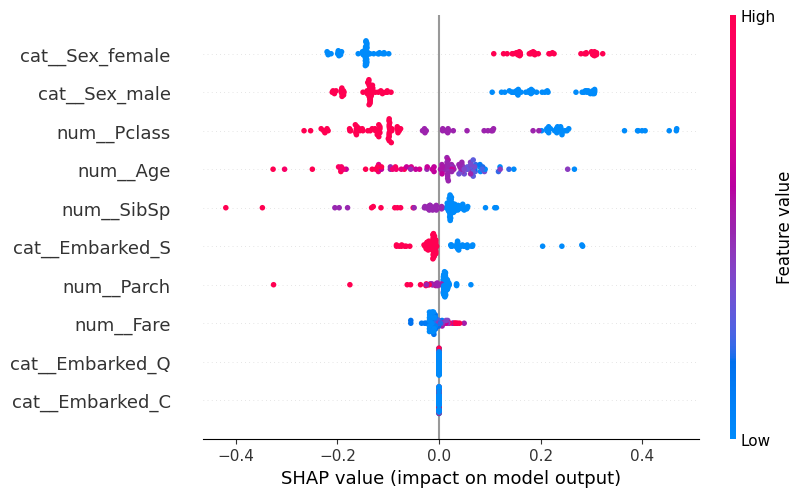

In [68]:
shap_values = explain(x_train_sample)
shap.plots.beeswarm(shap_values)

In [107]:
import shap
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split


In [108]:
path_train=r'artifact\data_ingestion\train_data\train.csv'
path_test=r'artifact/data_ingestion/test_data/test.csv'

train_data=pd.read_csv(path_train)
test_data=pd.read_csv(path_test)

In [109]:
x_train = train_data.drop(['Survived'], axis=1)
y_train = train_data['Survived']

x_test=test_data.drop(['Survived'], axis=1)
y_test=test_data['Survived']

In [138]:
linear_model=LogisticRegression().fit(x_train,y_train)
forest_model=RandomForestClassifier().fit(x_train,y_train)
booster_model=GradientBoostingClassifier().fit(x_train, y_train)


In [139]:
gradient_explainer= shap.TreeExplainer(forest_model)
linear_explainer=shap.KernelExplainer(linear_model.predict, x_train)
booster_explainer=shap.TreeExplainer(booster_model)

2025-05-15 15:19:16 - WARNING: _kernel - Using 712 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [140]:
linear_shap=linear_explainer(x_test)

  0%|          | 0/179 [00:00<?, ?it/s]

2025-05-15 15:19:36 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:36 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:36 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:36 - INFO: _kernel - phi = array([-0.09880897,  0.17545535,  0.04308677, -0.01089263, -0.00662397,
        0.21843287,  0.23085596,  0.02209794, -0.0005735 ,  0.08567806])


  1%|          | 1/179 [00:00<00:21,  8.20it/s]

2025-05-15 15:19:37 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:37 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:37 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:37 - INFO: _kernel - phi = array([ 0.19000468, -0.09292904, -0.04178872, -0.04356273,  0.03454387,
       -0.17113095, -0.17225956, -0.01101971, -0.00326935, -0.02988062])


  1%|          | 2/179 [00:00<00:22,  7.81it/s]

2025-05-15 15:19:37 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:37 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:37 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:37 - INFO: _kernel - phi = array([ 0.25172329, -0.01175149, -0.01598671,  0.01108157,  0.0247687 ,
        0.16713595,  0.17065889, -0.0029695 ,  0.01806392,  0.04598326])


  2%|▏         | 3/179 [00:00<00:20,  8.45it/s]

2025-05-15 15:19:37 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:37 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:37 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:37 - INFO: _kernel - phi = array([-0.05855404,  0.12539292, -0.01481909, -0.00778993, -0.00850221,
       -0.17501839, -0.17818686, -0.0056347 , -0.00157671, -0.01660313])


  2%|▏         | 4/179 [00:00<00:19,  8.95it/s]

2025-05-15 15:19:37 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:37 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:37 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:37 - INFO: _kernel - phi = array([-0.17371701,  0.06211265,  0.02003968,  0.00732901, -0.01106318,
       -0.11679151, -0.11834314, -0.00390026,  0.        , -0.00695838])
2025-05-15 15:19:37 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:37 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:37 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:37 - INFO: _kernel - phi = array([-1.04264758e-01,  2.60556001e-03,  2.18421170e-02,  9.16989923e-03,
       -1.41380194e-02, -1.17694400e-01, -1.19413233e-01, -7.58204031e-03,
       -1.00321027e-04, -1.17169386e-02])


  3%|▎         | 6/179 [00:00<00:17,  9.88it/s]

2025-05-15 15:19:37 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:37 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:37 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:37 - INFO: _kernel - phi = array([-1.68653023e-01,  5.02390984e-02,  2.41489433e-02,  9.20278224e-03,
       -9.61577047e-03, -1.16502809e-01, -1.18648007e-01, -3.78377475e-03,
       -1.20385233e-04, -7.55918941e-03])
2025-05-15 15:19:37 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:37 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:37 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:37 - INFO: _kernel - phi = array([-0.10137663,  0.19170457,  0.04305556, -0.03637696, -0.00756142,
        0.21412297,  0.23807963,  0.03982689, -0.00115815,  0.07839141])


  4%|▍         | 8/179 [00:00<00:16, 10.15it/s]

2025-05-15 15:19:37 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:37 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:37 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:37 - INFO: _kernel - phi = array([-0.17281244,  0.05907961,  0.02103119,  0.00741094, -0.0099446 ,
       -0.1168701 , -0.1184953 , -0.00380997,  0.        , -0.00688147])


  5%|▌         | 9/179 [00:00<00:16, 10.07it/s]

2025-05-15 15:19:37 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:37 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:37 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:37 - INFO: _kernel - phi = array([-0.18152644,  0.01573312,  0.02033284,  0.00840802, -0.00914147,
       -0.11848638, -0.12086064,  0.01780308, -0.0002809 ,  0.02672664])


  6%|▌         | 10/179 [00:01<00:17,  9.90it/s]

2025-05-15 15:19:37 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:38 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:38 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:38 - INFO: _kernel - phi = array([-1.16695091e-01,  2.87954789e-02,  2.09938470e-02,  8.04741841e-03,
       -2.45786517e-02, -1.19517456e-01, -1.21074104e-01, -6.60948368e-03,
       -9.36329588e-05, -1.05604601e-02])


  6%|▌         | 11/179 [00:01<00:17,  9.50it/s]

2025-05-15 15:19:38 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:38 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:38 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:38 - INFO: _kernel - phi = array([-0.1270772 ,  0.06739344, -0.01228654, -0.01386827, -0.01036372,
       -0.11469759, -0.11588305, -0.00536717, -0.00037676, -0.00876527])


  7%|▋         | 12/179 [00:01<00:17,  9.51it/s]

2025-05-15 15:19:38 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:38 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:38 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:38 - INFO: _kernel - phi = array([-0.11717106,  0.05907292, -0.01563615, -0.00748674, -0.01174035,
       -0.11560939, -0.11647383, -0.00621544, -0.00034332, -0.00968878])


  7%|▋         | 13/179 [00:01<00:17,  9.50it/s]

2025-05-15 15:19:38 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:38 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:38 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:38 - INFO: _kernel - phi = array([-0.08647059, -0.0254938 ,  0.01908385,  0.00987438, -0.01119304,
       -0.11357566, -0.11502196, -0.00602149, -0.00011704, -0.01235676])
2025-05-15 15:19:38 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:38 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:38 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:38 - INFO: _kernel - phi = array([ 1.05006019e-01,  6.70495586e-02,  3.37162253e-02,  7.92536116e-03,
       -2.64847512e-03,  2.25260835e-01,  2.30454120e-01, -2.30069556e-03,
       -2.00642055e-04, -5.55444088e-03])


  8%|▊         | 15/179 [00:01<00:16,  9.88it/s]

2025-05-15 15:19:38 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:38 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:38 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:38 - INFO: _kernel - phi = array([-1.10354245e-01,  1.45203540e-02,  2.16665552e-02,  8.75189495e-03,
       -1.61929285e-02, -1.19958311e-01, -1.21305957e-01, -7.34294186e-03,
       -9.36329588e-05, -1.09829231e-02])
2025-05-15 15:19:38 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:38 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:38 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:38 - INFO: _kernel - phi = array([-0.18928293,  0.04201222,  0.01747369,  0.00690655, -0.01033028,
       -0.11891943, -0.12137562,  0.01255462, -0.00032103,  0.01999008])


  9%|▉         | 17/179 [00:01<00:15, 10.15it/s]

2025-05-15 15:19:38 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:38 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:38 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:38 - INFO: _kernel - phi = array([-8.75696674e-02, -6.63768504e-02,  1.40772695e-02,  5.98470662e-03,
       -9.39283485e-03, -9.03351837e-02, -9.18383271e-02, -4.20289370e-03,
       -9.36329588e-05, -1.15447209e-02])
2025-05-15 15:19:38 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:38 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:38 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:38 - INFO: _kernel - phi = array([ 0.25691156,  0.00878255,  0.02653435,  0.00808866,  0.01985297,
        0.14402365,  0.14595483,  0.01967407, -0.00042971,  0.02931492])


 11%|█         | 19/179 [00:01<00:16,  9.67it/s]

2025-05-15 15:19:38 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:38 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:38 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:38 - INFO: _kernel - phi = array([ 1.05177680e-01,  7.10334180e-02,  3.33612003e-02,  7.43991885e-03,
       -6.64849741e-03,  2.25649857e-01,  2.30821406e-01, -2.31351436e-03,
       -2.03428750e-04, -5.61017478e-03])


 11%|█         | 20/179 [00:02<00:16,  9.70it/s]

2025-05-15 15:19:39 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:39 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:39 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:39 - INFO: _kernel - phi = array([ 0.09870029,  0.03761648, -0.00929864,  0.01113842, -0.00471899,
        0.22460986,  0.23060404,  0.02741551, -0.00028926,  0.04293015])
2025-05-15 15:19:39 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:39 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:39 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:39 - INFO: _kernel - phi = array([ 0.21147171, -0.24424492,  0.03729601,  0.01032471, -0.00553438,
       -0.158855  , -0.16321562, -0.00780665, -0.00391252, -0.01681548])


 12%|█▏        | 22/179 [00:02<00:15, 10.12it/s]

2025-05-15 15:19:39 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:39 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:39 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:39 - INFO: _kernel - phi = array([-1.06951690e-01,  1.00042358e-02,  2.14809613e-02,  9.36385322e-03,
       -1.56361468e-02, -1.19468410e-01, -1.21290909e-01, -7.30448546e-03,
       -9.36329588e-05, -1.13959114e-02])
2025-05-15 15:19:39 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:39 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:39 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:39 - INFO: _kernel - phi = array([-0.17268927,  0.00168038,  0.02348348,  0.00793874, -0.01166065,
       -0.11833868, -0.12029996,  0.01621021, -0.00035112,  0.03273475])


 13%|█▎        | 24/179 [00:02<00:14, 10.44it/s]

2025-05-15 15:19:39 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:39 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:39 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:39 - INFO: _kernel - phi = array([-1.71792514e-01,  5.53844525e-02,  2.24557473e-02,  7.67845996e-03,
       -9.07515160e-03, -1.16746366e-01, -1.18244493e-01, -3.86013019e-03,
       -9.36329588e-05, -6.99850633e-03])
2025-05-15 15:19:39 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:39 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:39 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:39 - INFO: _kernel - phi = array([ 0.21385099, -0.23990436,  0.03296549,  0.00897372, -0.00480203,
       -0.15878979, -0.16588082, -0.00744716, -0.00380049, -0.01645766])


 15%|█▍        | 26/179 [00:02<00:14, 10.48it/s]

2025-05-15 15:19:39 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:39 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:39 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:39 - INFO: _kernel - phi = array([-0.08710039, -0.0608447 ,  0.0141971 ,  0.0062082 , -0.01027622,
       -0.09230036, -0.09366306, -0.00545914, -0.00043138, -0.01162219])
2025-05-15 15:19:39 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:39 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:39 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:39 - INFO: _kernel - phi = array([ 0.51065075,  0.0557183 ,  0.06536249,  0.0172619 , -0.00605772,
       -0.08304407, -0.08410748,  0.08048589, -0.0010099 ,  0.1034477 ])


 16%|█▌        | 28/179 [00:02<00:14, 10.60it/s]

2025-05-15 15:19:39 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:39 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:39 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:39 - INFO: _kernel - phi = array([ 0.31733547, -0.13688804,  0.02790764, -0.01150515,  0.02800127,
        0.1845422 ,  0.18694489,  0.02826545, -0.00208166,  0.03618579])
2025-05-15 15:19:39 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:39 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:39 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:39 - INFO: _kernel - phi = array([-0.12364567,  0.02575074,  0.04732812,  0.0134681 , -0.0078033 ,
        0.33012473,  0.33222311, -0.00237148,  0.01321061,  0.03042291])


 17%|█▋        | 30/179 [00:03<00:14, 10.38it/s]

2025-05-15 15:19:39 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:39 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:39 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:40 - INFO: _kernel - phi = array([-0.16283923,  0.02021487,  0.02485472,  0.01077634,  0.01483432,
       -0.11738545, -0.11887187, -0.004225  ,  0.        , -0.00865083])
2025-05-15 15:19:40 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:40 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:40 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:40 - INFO: _kernel - phi = array([ 0.38408909,  0.03891453, -0.13270967, -0.03789292,  0.06869148,
        0.17811162,  0.18107611, -0.00496087, -0.00291433, -0.01369716])


 18%|█▊        | 32/179 [00:03<00:14, 10.16it/s]

2025-05-15 15:19:40 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:40 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:40 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:40 - INFO: _kernel - phi = array([-0.06527443,  0.07554954,  0.02076924,  0.00765227, -0.00641442,
       -0.17993134, -0.18208991, -0.00353186, -0.00022739, -0.00779383])
2025-05-15 15:19:40 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:40 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:40 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:40 - INFO: _kernel - phi = array([-0.011528  , -0.04325787,  0.02125189,  0.00885556, -0.01656077,
       -0.13149857, -0.13481586, -0.00860866, -0.00272539, -0.02240447])


 19%|█▉        | 34/179 [00:03<00:14, 10.28it/s]

2025-05-15 15:19:40 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:40 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:40 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:40 - INFO: _kernel - phi = array([ 2.77638443e-01, -1.07749799e-01,  3.14406100e-02,  9.74785982e-03,
       -2.09002140e-04,  1.89294074e-01,  1.92723381e-01,  1.79290396e-02,
       -7.36802212e-04,  4.86300606e-02])
2025-05-15 15:19:40 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:40 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:40 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:40 - INFO: _kernel - phi = array([ 0.2685109 ,  0.03615068, -0.02574739, -0.03943285,  0.06042335,
        0.18602026,  0.18961677, -0.00370909, -0.00141731, -0.01170746])


 20%|██        | 36/179 [00:03<00:13, 10.44it/s]

2025-05-15 15:19:40 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:40 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:40 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:40 - INFO: _kernel - phi = array([-0.12364567,  0.02575074,  0.04732812,  0.0134681 , -0.0078033 ,
        0.33012473,  0.33222311, -0.00237148,  0.01321061,  0.03042291])
2025-05-15 15:19:40 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:40 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:40 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:40 - INFO: _kernel - phi = array([-0.1728169 ,  0.05907515,  0.02103676,  0.00740648, -0.00993903,
       -0.11686452, -0.11848972, -0.00381443,  0.        , -0.00688592])


 21%|██        | 38/179 [00:03<00:14,  9.90it/s]

2025-05-15 15:19:40 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:40 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:40 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:40 - INFO: _kernel - phi = array([-1.72213305e-01,  5.66156144e-02,  2.19714197e-02,  7.65728108e-03,
       -9.58121544e-03, -1.16663880e-01, -1.18292425e-01, -3.79269217e-03,
       -9.02889246e-05, -6.90264402e-03])


 22%|██▏       | 39/179 [00:03<00:14,  9.66it/s]

2025-05-15 15:19:40 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:40 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:40 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:40 - INFO: _kernel - phi = array([-0.18152644,  0.01573312,  0.02033284,  0.00840802, -0.00914147,
       -0.11848638, -0.12086064,  0.01780308, -0.0002809 ,  0.02672664])


 22%|██▏       | 40/179 [00:04<00:14,  9.71it/s]

2025-05-15 15:19:40 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:41 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:41 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:41 - INFO: _kernel - phi = array([-0.1779695 ,  0.06705792,  0.01637908,  0.00639045, -0.00874632,
       -0.11622191, -0.1178538 , -0.00361825,  0.        , -0.0067098 ])


 23%|██▎       | 41/179 [00:04<00:14,  9.64it/s]

2025-05-15 15:19:41 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:41 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:41 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:41 - INFO: _kernel - phi = array([-1.03993334e-01,  6.38320403e-03,  1.98813983e-02,  9.69546995e-03,
       -1.29770822e-02, -1.19768816e-01, -1.21532794e-01, -7.36913679e-03,
       -9.36329588e-05, -1.15174113e-02])


 23%|██▎       | 42/179 [00:04<00:14,  9.40it/s]

2025-05-15 15:19:41 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:41 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:41 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:41 - INFO: _kernel - phi = array([-0.01324906,  0.0056464 , -0.02115102, -0.01138644, -0.0075826 ,
       -0.17782069, -0.18294877,  0.0208651 , -0.00040184,  0.04673678])


 24%|██▍       | 43/179 [00:04<00:15,  8.69it/s]

2025-05-15 15:19:41 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:41 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:41 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:41 - INFO: _kernel - phi = array([-0.15720082,  0.01702671, -0.01336388,  0.01053427, -0.00988942,
       -0.11769106, -0.11955535, -0.00467552,  0.02146759,  0.03205535])


 25%|██▍       | 44/179 [00:04<00:16,  8.34it/s]

2025-05-15 15:19:41 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:41 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:41 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:41 - INFO: _kernel - phi = array([-1.68648007e-01,  5.02240503e-02,  2.41673355e-02,  9.20278224e-03,
       -9.59737828e-03, -1.16517857e-01, -1.18629615e-01, -3.79882290e-03,
       -1.20385233e-04, -7.57423756e-03])


 25%|██▌       | 45/179 [00:04<00:15,  8.64it/s]

2025-05-15 15:19:41 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:41 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:41 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:41 - INFO: _kernel - phi = array([ 0.26373785,  0.03700731,  0.02518615,  0.00740091,  0.002639  ,
        0.14049848,  0.14239455,  0.01567405, -0.00038233,  0.0245519 ])


 26%|██▌       | 46/179 [00:04<00:14,  8.93it/s]

2025-05-15 15:19:41 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:41 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:41 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:41 - INFO: _kernel - phi = array([ 1.08778647e-01,  3.56613385e-02,  4.81763867e-02,  1.30305868e-02,
       -7.63220082e-03,  2.33180065e-01,  2.38761258e-01, -3.32062600e-03,
       -1.80020510e-04, -7.74757000e-03])


 26%|██▋       | 47/179 [00:04<00:14,  8.99it/s]

2025-05-15 15:19:41 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:41 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:41 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:41 - INFO: _kernel - phi = array([ 0.22501115, -0.16161606,  0.03394306,  0.01086588, -0.01487148,
       -0.16506543, -0.16625424, -0.01051587, -0.00410815, -0.088681  ])


 27%|██▋       | 48/179 [00:04<00:14,  9.20it/s]

2025-05-15 15:19:41 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:41 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:41 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:41 - INFO: _kernel - phi = array([-1.15777154e-01,  2.57624398e-02,  2.15690209e-02,  8.65603264e-03,
       -2.37409711e-02, -1.19480671e-01, -1.20880150e-01, -6.88035045e-03,
       -9.36329588e-05, -1.04266988e-02])


 27%|██▋       | 49/179 [00:05<00:13,  9.36it/s]

2025-05-15 15:19:41 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:42 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:42 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:42 - INFO: _kernel - phi = array([ 0.06101358,  0.01623863, -0.06250167,  0.01423221, -0.00656768,
        0.32745452,  0.33594168, -0.00774924, -0.00246678, -0.01688737])
2025-05-15 15:19:42 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:42 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:42 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:42 - INFO: _kernel - phi = array([ 0.21439328, -0.22574015,  0.02755373,  0.0080463 , -0.00478141,
       -0.1649222 , -0.16596721, -0.00736133, -0.00380049, -0.01871266])


 28%|██▊       | 51/179 [00:05<00:14,  8.77it/s]

2025-05-15 15:19:42 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:42 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:42 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:42 - INFO: _kernel - phi = array([-1.72191569e-01,  5.66105984e-02,  2.19329633e-02,  7.68403335e-03,
       -9.61967184e-03, -1.16622080e-01, -1.18330881e-01, -3.77764402e-03,
       -9.02889246e-05, -6.88759586e-03])


 29%|██▉       | 52/179 [00:05<00:14,  8.74it/s]

2025-05-15 15:19:42 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:42 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:42 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:42 - INFO: _kernel - phi = array([-1.71796973e-01,  5.53799938e-02,  2.24613207e-02,  7.67400125e-03,
       -9.06957821e-03, -1.16740793e-01, -1.18238920e-01, -3.86458891e-03,
       -9.36329588e-05, -7.00296504e-03])


 30%|██▉       | 53/179 [00:05<00:14,  8.95it/s]

2025-05-15 15:19:42 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:42 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:42 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:42 - INFO: _kernel - phi = array([ 0.22742888, -0.11034031,  0.04173466,  0.01231218, -0.04974307,
       -0.16127497, -0.16214943, -0.04495608, -0.02105237, -0.07325163])
2025-05-15 15:19:42 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:42 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:42 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:42 - INFO: _kernel - phi = array([ 3.64722668e-03,  2.28787676e-03,  3.27102283e-02,  1.82171839e-02,
       -1.30010478e-02, -1.79619226e-01, -1.82475031e-01, -8.34615213e-03,
       -1.78905832e-04, -1.45342875e-02])


 31%|███       | 55/179 [00:05<00:12,  9.59it/s]

2025-05-15 15:19:42 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:42 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:42 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:42 - INFO: _kernel - phi = array([-0.12593521,  0.0348727 ,  0.06206137, -0.0209827 , -0.00634419,
        0.3270276 ,  0.32901897,  0.01886314, -0.00044643,  0.04057261])
2025-05-15 15:19:42 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:42 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:42 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:42 - INFO: _kernel - phi = array([-1.72191569e-01,  5.66105984e-02,  2.19329633e-02,  7.68403335e-03,
       -9.61967184e-03, -1.16622080e-01, -1.18330881e-01, -3.77764402e-03,
       -9.02889246e-05, -6.88759586e-03])


 32%|███▏      | 57/179 [00:05<00:12,  9.81it/s]

2025-05-15 15:19:42 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:42 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:42 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:42 - INFO: _kernel - phi = array([-1.06951690e-01,  1.00042358e-02,  2.14809613e-02,  9.36385322e-03,
       -1.56361468e-02, -1.19468410e-01, -1.21290909e-01, -7.30448546e-03,
       -9.36329588e-05, -1.13959114e-02])


 32%|███▏      | 58/179 [00:06<00:12,  9.84it/s]

2025-05-15 15:19:42 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:43 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:43 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:43 - INFO: _kernel - phi = array([ 0.22670992, -0.11407225,  0.04199215,  0.01312645, -0.04564662,
       -0.16129671, -0.16244872, -0.04430901, -0.02105738, -0.07428995])


 33%|███▎      | 59/179 [00:06<00:13,  8.87it/s]

2025-05-15 15:19:43 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:43 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:43 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:43 - INFO: _kernel - phi = array([-0.1362354 ,  0.01155587, -0.01600733, -0.0198814 , -0.0124543 ,
        0.30844926,  0.31054095, -0.00379827,  0.02746344,  0.18907504])


 34%|███▎      | 60/179 [00:06<00:13,  8.57it/s]

2025-05-15 15:19:43 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:43 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:43 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:43 - INFO: _kernel - phi = array([-1.23277822e-01,  2.28765383e-02,  4.64586677e-02,  1.28996121e-02,
       -8.11262707e-03,  3.30268526e-01,  3.32718031e-01,  1.59092429e-02,
       -2.70866774e-04,  2.92385634e-02])


 34%|███▍      | 61/179 [00:06<00:13,  8.88it/s]

2025-05-15 15:19:43 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:43 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:43 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:43 - INFO: _kernel - phi = array([ 0.25423243, -0.01885645,  0.03324695,  0.01138031,  0.05272929,
        0.16814863,  0.17159633, -0.00316847, -0.00088896, -0.00971219])


 35%|███▍      | 62/179 [00:06<00:12,  9.08it/s]

2025-05-15 15:19:43 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:43 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:43 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:43 - INFO: _kernel - phi = array([-0.08960897, -0.01800484,  0.0204666 ,  0.00846319, -0.01182339,
       -0.1149835 , -0.1159934 , -0.00468722, -0.00024411, -0.01487649])
2025-05-15 15:19:43 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:43 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:43 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:43 - INFO: _kernel - phi = array([ 0.07015784,  0.04184892, -0.05951211, -0.02541968,  0.00272204,
        0.31379749,  0.34335875, -0.00805522, -0.0022862 , -0.01790396])


 36%|███▌      | 64/179 [00:06<00:12,  9.49it/s]

2025-05-15 15:19:43 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:43 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:43 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:43 - INFO: _kernel - phi = array([-0.10745385,  0.01336945, -0.43527287, -0.03738463,  0.00630016,
        0.11803939,  0.12138677, -0.00701077, -0.00063202, -0.01263376])


 36%|███▋      | 65/179 [00:06<00:12,  9.48it/s]

2025-05-15 15:19:43 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:43 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:43 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:43 - INFO: _kernel - phi = array([ 0.2269897 , -0.11414694,  0.04164827,  0.01203685, -0.04404595,
       -0.16147004, -0.16233614, -0.0451779 , -0.02105738, -0.07373261])


 37%|███▋      | 66/179 [00:06<00:11,  9.42it/s]

2025-05-15 15:19:43 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:43 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:43 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:43 - INFO: _kernel - phi = array([-0.17846553,  0.0819712 ,  0.02557072,  0.01248551, -0.00679452,
       -0.16481351, -0.16946339,  0.02820916, -0.0026351 ,  0.03264335])
2025-05-15 15:19:43 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:43 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:43 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:43 - INFO: _kernel - phi = array([ 0.25544409,  0.00367677, -0.02546482,  0.01743747,  0.01729033,
        0.20228565,  0.20459805, -0.0039755 , -0.00095862, -0.01162554])


 38%|███▊      | 68/179 [00:07<00:11,  9.86it/s]

2025-05-15 15:19:44 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:44 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:44 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:44 - INFO: _kernel - phi = array([-0.00584816, -0.06188581, -0.01362638,  0.00717184, -0.00574951,
       -0.11985297, -0.12212357, -0.0055288 , -0.00084604, -0.01300272])
2025-05-15 15:19:44 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:44 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:44 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:44 - INFO: _kernel - phi = array([-1.71797530e-01,  5.53995006e-02,  2.24373551e-02,  7.67845996e-03,
       -9.09354378e-03, -1.16731318e-01, -1.18262886e-01, -3.84508204e-03,
       -9.36329588e-05, -6.98345818e-03])


 39%|███▉      | 70/179 [00:07<00:10,  9.95it/s]

2025-05-15 15:19:44 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:44 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:44 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:44 - INFO: _kernel - phi = array([ 0.19242632, -0.17202827,  0.03716448, -0.01108993, -0.00032381,
        0.31297875,  0.32034065, -0.00479144, -0.00195793, -0.01401095])
2025-05-15 15:19:44 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:44 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:44 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:44 - INFO: _kernel - phi = array([-0.10837123,  0.05710997, -0.05302914,  0.00852116, -0.00816725,
       -0.11033084, -0.1114561 , -0.00354412, -0.0001555 , -0.01186909])


 40%|████      | 72/179 [00:07<00:10, 10.24it/s]

2025-05-15 15:19:44 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:44 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:44 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:44 - INFO: _kernel - phi = array([-0.13382546,  0.14440822,  0.00743825,  0.01813581, -0.0080764 ,
        0.31969079,  0.32220049, -0.00346163,  0.        , -0.00780219])
2025-05-15 15:19:44 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:44 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:44 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:44 - INFO: _kernel - phi = array([-1.68247838e-01,  5.04837703e-02,  2.41712368e-02,  9.31703674e-03,
       -1.04779740e-02, -1.16544052e-01, -1.18575553e-01, -3.71299269e-03,
       -1.20385233e-04, -7.58538434e-03])


 41%|████▏     | 74/179 [00:07<00:10,  9.66it/s]

2025-05-15 15:19:44 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:44 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:44 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:44 - INFO: _kernel - phi = array([-0.12603275,  0.09093655, -0.01667949,  0.01243869, -0.00736133,
        0.31037041,  0.33713104,  0.02425651, -0.00088283,  0.03453105])
2025-05-15 15:19:44 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:44 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:44 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:44 - INFO: _kernel - phi = array([-0.099548  ,  0.0592234 , -0.1187578 , -0.01051476, -0.00061474,
       -0.08016096, -0.08132636, -0.00266464, -0.00037788, -0.00655041])


 42%|████▏     | 76/179 [00:07<00:10,  9.97it/s]

2025-05-15 15:19:44 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:44 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:44 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:44 - INFO: _kernel - phi = array([-8.71115347e-02, -6.67948546e-02,  1.40337970e-02,  5.95461031e-03,
       -1.00449215e-02, -9.04672731e-02, -9.16059167e-02, -3.89691457e-03,
       -7.35687533e-05, -1.12855582e-02])
2025-05-15 15:19:44 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:44 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:44 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:44 - INFO: _kernel - phi = array([-0.13155208,  0.08936318,  0.05697956,  0.01357901, -0.00996466,
        0.32438358,  0.32692505, -0.00311775, -0.00049157, -0.00739645])


 44%|████▎     | 78/179 [00:08<00:10,  9.88it/s]

2025-05-15 15:19:45 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:45 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:45 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:45 - INFO: _kernel - phi = array([-1.74496166e-01,  5.24350143e-02, -1.06786160e-02, -5.43182629e-03,
       -7.82615481e-03, -1.16607589e-01, -1.19020309e-01,  1.40839576e-02,
       -1.73332442e-04,  2.64228866e-02])


 44%|████▍     | 79/179 [00:08<00:10,  9.90it/s]

2025-05-15 15:19:45 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:45 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:45 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:45 - INFO: _kernel - phi = array([ 0.22254436, -0.09839431,  0.04180935,  0.01385489, -0.05666577,
       -0.16218678, -0.16311307, -0.0442895 , -0.02095706, -0.07389424])


 45%|████▍     | 80/179 [00:08<00:10,  9.65it/s]

2025-05-15 15:19:45 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:45 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:45 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:45 - INFO: _kernel - phi = array([-1.26406724e-01,  6.24509542e-02,  6.29776396e-02,  2.22355984e-02,
       -1.01597334e-02,  3.28913635e-01,  3.31669119e-01, -3.82780453e-03,
       -2.17362226e-04, -8.92745675e-03])


 45%|████▌     | 81/179 [00:08<00:10,  9.68it/s]

2025-05-15 15:19:45 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:45 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:45 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:45 - INFO: _kernel - phi = array([-0.10475466, -0.06110164,  0.01953139,  0.00897427, -0.01464464,
       -0.1153703 , -0.11746366,  0.01814194, -0.00060193,  0.02599708])


 46%|████▌     | 82/179 [00:08<00:10,  8.97it/s]

2025-05-15 15:19:45 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:45 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:45 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:45 - INFO: _kernel - phi = array([-1.06951690e-01,  1.00042358e-02,  2.14809613e-02,  9.36385322e-03,
       -1.56361468e-02, -1.19468410e-01, -1.21290909e-01, -7.30448546e-03,
       -9.36329588e-05, -1.13959114e-02])


 46%|████▋     | 83/179 [00:08<00:10,  9.14it/s]

2025-05-15 15:19:45 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:45 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:45 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:45 - INFO: _kernel - phi = array([-0.21210763, -0.07473972, -0.16512897, -0.15598303, -0.00566702,
        0.18867153,  0.19274456, -0.03394696, -0.01632112, -0.05881376])


 47%|████▋     | 84/179 [00:08<00:10,  9.35it/s]

2025-05-15 15:19:45 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:45 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:45 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:45 - INFO: _kernel - phi = array([ 0.07917168, -0.05075241,  0.04558587,  0.01667001,  0.01291132,
        0.20778491,  0.37101057, -0.00665741, -0.00245508, -0.0145616 ])
2025-05-15 15:19:45 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:45 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:45 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:45 - INFO: _kernel - phi = array([-0.1799436 ,  0.01686787,  0.02095929,  0.00861145, -0.00897316,
       -0.11844179, -0.12054017, -0.003577  ,  0.01673912,  0.02700586])


 48%|████▊     | 86/179 [00:08<00:09,  9.86it/s]

2025-05-15 15:19:45 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:45 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:45 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:45 - INFO: _kernel - phi = array([-0.12364567,  0.02575074,  0.04732812,  0.0134681 , -0.0078033 ,
        0.33012473,  0.33222311, -0.00237148,  0.01321061,  0.03042291])


 49%|████▊     | 87/179 [00:09<00:09,  9.61it/s]

2025-05-15 15:19:45 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:46 - INFO: _kernel - phi = array([ 0.21441056, -0.22193241,  0.02712625,  0.00737805, -0.00448156,
       -0.16499186, -0.16639469, -0.00865157, -0.00394596, -0.01980894])


 49%|████▉     | 88/179 [00:09<00:09,  9.21it/s]

2025-05-15 15:19:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:46 - INFO: _kernel - phi = array([-0.05398163,  0.0235264 , -0.01356563,  0.011839  , -0.00754971,
       -0.18118033, -0.18410971,  0.02565153, -0.00022126,  0.03829922])


 50%|████▉     | 89/179 [00:09<00:10,  8.61it/s]

2025-05-15 15:19:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:46 - INFO: _kernel - phi = array([-1.06951690e-01,  1.00042358e-02,  2.14809613e-02,  9.36385322e-03,
       -1.56361468e-02, -1.19468410e-01, -1.21290909e-01, -7.30448546e-03,
       -9.36329588e-05, -1.13959114e-02])
2025-05-15 15:19:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:46 - INFO: _kernel - phi = array([ 0.26094057,  0.05378266,  0.02894819,  0.00831215,  0.01546672,
        0.14863619,  0.15109907, -0.00229958, -0.00057573, -0.00560237])


 51%|█████     | 91/179 [00:09<00:09,  9.29it/s]

2025-05-15 15:19:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:46 - INFO: _kernel - phi = array([ 1.99186285e-01,  2.98995675e-02, -1.89920523e-01,  1.40705814e-02,
       -4.18282950e-03,  3.09016074e-01,  3.13373350e-01, -3.53631621e-03,
       -2.82013554e-04, -8.91630997e-03])


 51%|█████▏    | 92/179 [00:09<00:09,  9.44it/s]

2025-05-15 15:19:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:46 - INFO: _kernel - phi = array([ 0.22685873, -0.11434479,  0.0417146 ,  0.01315822, -0.04540418,
       -0.16129838, -0.1624504 , -0.0442438 , -0.02105738, -0.07422474])
2025-05-15 15:19:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:46 - INFO: _kernel - phi = array([ 0.40225388, -0.1575408 , -0.01773341,  0.00791867,  0.01733547,
        0.17631755,  0.17986557,  0.021666  , -0.00104167,  0.0296666 ])


 53%|█████▎    | 94/179 [00:09<00:08,  9.61it/s]

2025-05-15 15:19:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:46 - INFO: _kernel - phi = array([ 0.16055099, -0.20567092, -0.04294855, -0.02077927,  0.02048778,
       -0.10406412, -0.11569467, -0.0074232 , -0.00237092, -0.02337926])


 53%|█████▎    | 95/179 [00:09<00:08,  9.69it/s]

2025-05-15 15:19:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:46 - INFO: _kernel - phi = array([ 0.21311252, -0.24157415,  0.03374186,  0.00862482, -0.00286026,
       -0.15895309, -0.16566123, -0.00743992, -0.00383728, -0.0164454 ])
2025-05-15 15:19:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:46 - INFO: _kernel - phi = array([-0.10115648,  0.07078373, -0.10591504, -0.01268169, -0.00374811,
       -0.08538601, -0.08633405, -0.004617  , -0.0011693 , -0.0110682 ])


 54%|█████▍    | 97/179 [00:10<00:08,  9.92it/s]

2025-05-15 15:19:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:47 - INFO: _kernel - phi = array([-0.18837892,  0.0327119 ,  0.01958657,  0.00752631, -0.00641999,
       -0.11888488, -0.12096821,  0.01235844, -0.00037453,  0.02155119])


 55%|█████▍    | 98/179 [00:10<00:08,  9.85it/s]

2025-05-15 15:19:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:47 - INFO: _kernel - phi = array([-0.1799436 ,  0.01686787,  0.02095929,  0.00861145, -0.00897316,
       -0.11844179, -0.12054017, -0.003577  ,  0.01673912,  0.02700586])


 55%|█████▌    | 99/179 [00:10<00:08,  9.29it/s]

2025-05-15 15:19:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:47 - INFO: _kernel - phi = array([-0.17335919,  0.08779316, -0.00671928, -0.00559234, -0.00606719,
       -0.1111635 , -0.11368825, -0.00361825, -0.0008087 , -0.0080686 ])


 56%|█████▌    | 100/179 [00:10<00:08,  9.25it/s]

2025-05-15 15:19:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:47 - INFO: _kernel - phi = array([ 0.21147171, -0.24424492,  0.03729601,  0.01032471, -0.00553438,
       -0.158855  , -0.16321562, -0.00780665, -0.00391252, -0.01681548])


 56%|█████▋    | 101/179 [00:10<00:08,  9.22it/s]

2025-05-15 15:19:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:47 - INFO: _kernel - phi = array([-0.12364567,  0.02575074,  0.04732812,  0.0134681 , -0.0078033 ,
        0.33012473,  0.33222311, -0.00237148,  0.01321061,  0.03042291])


 57%|█████▋    | 102/179 [00:10<00:08,  9.36it/s]

2025-05-15 15:19:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:47 - INFO: _kernel - phi = array([ 0.39574862, -0.1629325 , -0.02421694,  0.0157125 ,  0.053368  ,
        0.19544264,  0.19974474, -0.00398832, -0.00103888, -0.009132  ])


 58%|█████▊    | 103/179 [00:10<00:07,  9.50it/s]

2025-05-15 15:19:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:47 - INFO: _kernel - phi = array([-5.99217496e-02,  7.27427769e-02,  2.46254682e-02,  8.91519529e-03,
       -1.24364633e-02, -1.80305310e-01, -1.82930377e-01, -3.94763242e-03,
       -1.42121455e-04, -7.89192081e-03])


 58%|█████▊    | 104/179 [00:10<00:07,  9.58it/s]

2025-05-15 15:19:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:47 - INFO: _kernel - phi = array([ 0.21158708, -0.16912286,  0.03087045,  0.01033139, -0.02266252,
       -0.16924993, -0.1705307 , -0.01833032, -0.00820292, -0.03598181])
2025-05-15 15:19:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:47 - INFO: _kernel - phi = array([-0.09530107, -0.01231552,  0.02150103,  0.00936218, -0.01241919,
       -0.11218678, -0.12057194, -0.00491016, -0.00032772, -0.01412297])


 59%|█████▉    | 106/179 [00:11<00:07,  9.99it/s]

2025-05-15 15:19:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:48 - INFO: _kernel - phi = array([ 0.00245396, -0.08195448, -0.01016809, -0.00615024, -0.00310382,
       -0.11293194, -0.11613552, -0.00412654, -0.00036506, -0.00881042])


 60%|█████▉    | 107/179 [00:11<00:07,  9.18it/s]

2025-05-15 15:19:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:48 - INFO: _kernel - phi = array([ 0.10706762,  0.06215891,  0.04746188, -0.01159544, -0.00083768,
        0.22839754,  0.23729434, -0.00324427, -0.00064651, -0.00734852])


 60%|██████    | 108/179 [00:11<00:07,  8.97it/s]

2025-05-15 15:19:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:48 - INFO: _kernel - phi = array([-0.12347679,  0.05777154,  0.03734617,  0.01078953, -0.0109885 ,
        0.3254598 ,  0.32900615, -0.0092797 ,  0.0150632 ,  0.02701645])


 61%|██████    | 109/179 [00:11<00:08,  8.53it/s]

2025-05-15 15:19:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:48 - INFO: _kernel - phi = array([ 0.54125814,  0.08398653,  0.05220483,  0.01247436,  0.03035491,
       -0.07702871, -0.07851514,  0.03799938, -0.0007708 ,  0.05674436])


 61%|██████▏   | 110/179 [00:11<00:08,  8.50it/s]

2025-05-15 15:19:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:48 - INFO: _kernel - phi = array([ 0.50810037,  0.13425071, -0.03348939,  0.01987973,  0.03497804,
       -0.08496912, -0.0867632 ,  0.05728777, -0.00134542,  0.11077838])


 62%|██████▏   | 111/179 [00:11<00:07,  8.64it/s]

2025-05-15 15:19:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:48 - INFO: _kernel - phi = array([ 5.45250357e-02, -9.85548199e-02,  4.21437489e-02,  1.62241395e-02,
       -5.94179151e-03,  3.34885523e-01,  3.43670301e-01, -6.68193776e-03,
       -3.29944712e-04, -2.12323881e-02])
2025-05-15 15:19:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:48 - INFO: _kernel - phi = array([ 0.21484138, -0.22952058,  0.02785636,  0.00834225, -0.00348894,
       -0.16425172, -0.16520644, -0.007674  , -0.00469168, -0.01749877])


 63%|██████▎   | 113/179 [00:11<00:07,  9.32it/s]

2025-05-15 15:19:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:48 - INFO: _kernel - phi = array([-0.07591088, -0.10029223,  0.01425599,  0.00653294, -0.00930608,
       -0.08119111, -0.08319418, -0.00448899,  0.        , -0.0076976 ])


 64%|██████▎   | 114/179 [00:11<00:07,  8.84it/s]

2025-05-15 15:19:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:48 - INFO: _kernel - phi = array([-0.00382558, -0.05569991, -0.01249498, -0.00686363, -0.00560962,
       -0.1181765 , -0.12023642, -0.00524735, -0.00097924, -0.01215891])


 64%|██████▍   | 115/179 [00:12<00:07,  9.06it/s]

2025-05-15 15:19:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:49 - INFO: _kernel - phi = array([-0.0651312 ,  0.0087335 ,  0.02635991,  0.01118468, -0.00996634,
       -0.1799854 , -0.18399489,  0.02056971, -0.0003344 ,  0.03127229])


 65%|██████▍   | 116/179 [00:12<00:06,  9.28it/s]

2025-05-15 15:19:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:49 - INFO: _kernel - phi = array([ 0.09981106,  0.09902689,  0.02932551, -0.01080792,  0.00227394,
        0.22415396,  0.23125669, -0.00373361, -0.00098315, -0.0116155 ])


 65%|██████▌   | 117/179 [00:12<00:07,  8.71it/s]

2025-05-15 15:19:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:49 - INFO: _kernel - phi = array([-2.29456483e-03, -1.07760389e-01,  1.84116952e-02,  8.35618423e-03,
       -9.19999554e-03, -1.17229022e-01, -1.19951066e-01, -3.69738719e-03,
       -1.08681113e-04, -7.81890940e-03])
2025-05-15 15:19:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:49 - INFO: _kernel - phi = array([-0.12873974,  0.21862014, -0.11070202, -0.01303282, -0.00573781,
        0.30080647,  0.31050751,  0.03253801, -0.00165028,  0.0560984 ])


 66%|██████▋   | 119/179 [00:12<00:06,  9.28it/s]

2025-05-15 15:19:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:49 - INFO: _kernel - phi = array([-0.18152644,  0.01573312,  0.02033284,  0.00840802, -0.00914147,
       -0.11848638, -0.12086064,  0.01780308, -0.0002809 ,  0.02672664])


 67%|██████▋   | 120/179 [00:12<00:06,  9.12it/s]

2025-05-15 15:19:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:49 - INFO: _kernel - phi = array([ 0.05725098, -0.09281757,  0.04230482,  0.01588361, -0.00854456,
        0.33340802,  0.34174302, -0.00937333, -0.00185315, -0.01929396])


 68%|██████▊   | 121/179 [00:12<00:06,  8.78it/s]

2025-05-15 15:19:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:49 - INFO: _kernel - phi = array([-0.08369951, -0.01469369, -0.01750936, -0.00780163, -0.00690543,
       -0.09546716, -0.09628812, -0.00573836, -0.00072733, -0.01246154])
2025-05-15 15:19:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:49 - INFO: _kernel - phi = array([ 0.25654483, -0.37883505,  0.02868568, -0.0316223 ,  0.03004503,
       -0.15631967, -0.15821908,  0.02663746, -0.00143013,  0.04322109])


 69%|██████▊   | 123/179 [00:12<00:05,  9.40it/s]

2025-05-15 15:19:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:49 - INFO: _kernel - phi = array([ 0.55375424,  0.09584894,  0.04633382,  0.01009285,  0.03762596,
       -0.07568831, -0.07760445,  0.02721096, -0.00087781,  0.04201166])
2025-05-15 15:19:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:50 - INFO: _kernel - phi = array([ 0.25897483,  0.05479312,  0.02287765, -0.01115793,  0.01158819,
        0.13896246,  0.14102573,  0.01728141, -0.00125234,  0.02561474])


 70%|██████▉   | 125/179 [00:13<00:05,  9.68it/s]

2025-05-15 15:19:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:50 - INFO: _kernel - phi = array([-1.71338283e-01,  3.38148743e-02, -1.23946629e-02,  8.89513109e-03,
       -6.17475923e-03, -1.18163122e-01, -1.19977261e-01,  1.36837881e-02,
       -1.47137507e-04,  3.05092964e-02])


 70%|███████   | 126/179 [00:13<00:05,  9.38it/s]

2025-05-15 15:19:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:50 - INFO: _kernel - phi = array([-0.13155208,  0.08937322,  0.05697956,  0.01357901, -0.0099747 ,
        0.32438358,  0.32691502, -0.00311274, -0.00049659, -0.00738641])


 71%|███████   | 127/179 [00:13<00:05,  9.45it/s]

2025-05-15 15:19:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:50 - INFO: _kernel - phi = array([-1.15772138e-01,  2.57473917e-02,  2.15874131e-02,  8.65603264e-03,
       -2.37225789e-02, -1.19495720e-01, -1.20861758e-01, -6.89539861e-03,
       -9.36329588e-05, -1.04417469e-02])
2025-05-15 15:19:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:50 - INFO: _kernel - phi = array([-0.23467541, -0.3255395 ,  0.0358904 ,  0.01346531, -0.03209214,
        0.15521558,  0.15773196, -0.03760144, -0.00167035, -0.07201656])


 72%|███████▏  | 129/179 [00:13<00:05,  9.38it/s]

2025-05-15 15:19:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:50 - INFO: _kernel - phi = array([-0.17797396,  0.06705346,  0.01638465,  0.00638599, -0.00874075,
       -0.11621634, -0.11784823, -0.0036227 ,  0.        , -0.00671426])


 73%|███████▎  | 130/179 [00:13<00:05,  9.31it/s]

2025-05-15 15:19:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:50 - INFO: _kernel - phi = array([-0.13155208,  0.08936318,  0.05697956,  0.01357901, -0.00996466,
        0.32438358,  0.32692505, -0.00311775, -0.00049157, -0.00739645])


 73%|███████▎  | 131/179 [00:13<00:05,  9.22it/s]

2025-05-15 15:19:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:50 - INFO: _kernel - phi = array([-0.13418606,  0.14989466,  0.04981775, -0.02577414, -0.00531367,
        0.31928672,  0.32347345, -0.00460864, -0.00115146, -0.01273074])
2025-05-15 15:19:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:50 - INFO: _kernel - phi = array([-0.12263744,  0.06075776,  0.03738296,  0.01103197, -0.01231441,
        0.32406701,  0.32952615, -0.01062288,  0.01434089,  0.02717585])


 74%|███████▍  | 133/179 [00:14<00:04,  9.64it/s]

2025-05-15 15:19:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:50 - INFO: _kernel - phi = array([ 0.53783106,  0.03000936,  0.04823268,  0.01112895,  0.08280832,
       -0.07246689, -0.07920011,  0.04258126, -0.00111022,  0.05889346])
2025-05-15 15:19:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:51 - INFO: _kernel - phi = array([ 0.23557049, -0.02304541,  0.03272138,  0.01019094,  0.01898575,
        0.1987092 ,  0.20178906, -0.00445481, -0.00129358, -0.01046516])


 75%|███████▌  | 135/179 [00:14<00:04,  9.83it/s]

2025-05-15 15:19:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:51 - INFO: _kernel - phi = array([-1.06951690e-01,  1.00042358e-02,  2.14809613e-02,  9.36385322e-03,
       -1.56361468e-02, -1.19468410e-01, -1.21290909e-01, -7.30448546e-03,
       -9.36329588e-05, -1.13959114e-02])


 76%|███████▌  | 136/179 [00:14<00:04,  9.50it/s]

2025-05-15 15:19:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:51 - INFO: _kernel - phi = array([ 0.0999699 ,  0.03253077, -0.00849886,  0.01159711, -0.00363329,
        0.22574405,  0.23000268,  0.02836744, -0.0002887 ,  0.04291678])


 77%|███████▋  | 137/179 [00:14<00:04,  9.04it/s]

2025-05-15 15:19:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:51 - INFO: _kernel - phi = array([-1.06951690e-01,  1.00042358e-02,  2.14809613e-02,  9.36385322e-03,
       -1.56361468e-02, -1.19468410e-01, -1.21290909e-01, -7.30448546e-03,
       -9.36329588e-05, -1.13959114e-02])


 77%|███████▋  | 138/179 [00:14<00:04,  9.22it/s]

2025-05-15 15:19:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:51 - INFO: _kernel - phi = array([-8.01425673e-02, -2.65025861e-02, -1.14076155e-02, -4.22914437e-02,
       -3.94874710e-03, -8.12410826e-02, -8.20536829e-02, -4.03680667e-03,
       -5.23898698e-05, -9.61521313e-03])


 78%|███████▊  | 139/179 [00:14<00:04,  8.71it/s]

2025-05-15 15:19:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:51 - INFO: _kernel - phi = array([ 5.47362672e-02, -9.83251962e-02,  4.23399322e-02,  1.61427680e-02,
       -6.49467184e-03,  3.34909488e-01,  3.43627385e-01, -6.67915106e-03,
       -3.27158017e-04, -2.12217986e-02])


 78%|███████▊  | 140/179 [00:14<00:04,  8.23it/s]

2025-05-15 15:19:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:51 - INFO: _kernel - phi = array([-1.30568374e-01,  8.26756733e-02,  5.97573346e-02,  1.65875245e-02,
       -9.21169966e-03,  3.24123306e-01,  3.26745029e-01, -3.21250223e-03,
       -2.10674157e-04, -7.97775103e-03])


 79%|███████▉  | 141/179 [00:14<00:04,  8.16it/s]

2025-05-15 15:19:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:51 - INFO: _kernel - phi = array([ 0.26165396,  0.04459604,  0.03256588,  0.00961075,  0.01466192,
        0.15138777,  0.15388075, -0.00257602, -0.00068608, -0.00638711])
2025-05-15 15:19:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:52 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:52 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:52 - INFO: _kernel - phi = array([ 0.09886972,  0.06428906, -0.00762607, -0.02677401,  0.00506788,
        0.22585607,  0.23212781,  0.02518727, -0.00044866,  0.0421588 ])


 80%|███████▉  | 143/179 [00:15<00:03,  9.16it/s]

2025-05-15 15:19:52 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:52 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:52 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:52 - INFO: _kernel - phi = array([ 0.55421683,  0.1001137 ,  0.05130083,  0.0112694 ,  0.02016787,
       -0.07615202, -0.07739266,  0.02942249, -0.00092295,  0.04668439])


 80%|████████  | 144/179 [00:15<00:03,  9.32it/s]

2025-05-15 15:19:52 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:52 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:52 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:52 - INFO: _kernel - phi = array([-0.1315727 ,  0.09068018,  0.05614299,  0.01359517, -0.01088149,
        0.32444656,  0.32704153, -0.00308989, -0.00039292, -0.00726157])


 81%|████████  | 145/179 [00:15<00:03,  8.74it/s]

2025-05-15 15:19:52 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:52 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:52 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:52 - INFO: _kernel - phi = array([ 0.25364165,  0.00214353, -0.01513008,  0.0097094 ,  0.02597479,
        0.15752575,  0.16099686,  0.02331795, -0.00077191,  0.04129994])


 82%|████████▏ | 146/179 [00:15<00:03,  8.50it/s]

2025-05-15 15:19:52 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:52 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:52 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:52 - INFO: _kernel - phi = array([-1.67942416e-01,  4.87978197e-02,  2.43913858e-02,  9.52380952e-03,
       -9.07570894e-03, -1.16755284e-01, -1.18584470e-01, -3.79882290e-03,
       -9.36329588e-05, -7.75481541e-03])
2025-05-15 15:19:52 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:52 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:52 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:52 - INFO: _kernel - phi = array([-0.18780877,  0.04158195,  0.01836265,  0.007222  , -0.0096102 ,
       -0.11878957, -0.1207659 , -0.00350956,  0.01130841,  0.02071685])


 83%|████████▎ | 148/179 [00:15<00:03,  9.45it/s]

2025-05-15 15:19:52 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:52 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:52 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:52 - INFO: _kernel - phi = array([ 0.25978632,  0.090625  , -0.01067416, -0.02683253,  0.03181849,
        0.16172418,  0.16505986, -0.00323257, -0.00071172, -0.008855  ])
2025-05-15 15:19:52 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:52 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:52 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:52 - INFO: _kernel - phi = array([-0.13151864,  0.04471866,  0.1105025 ,  0.018682  , -0.01969748,
        0.32529818,  0.32791321, -0.00550372, -0.00063871, -0.01104813])


 84%|████████▍ | 150/179 [00:15<00:03,  9.53it/s]

2025-05-15 15:19:52 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:52 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:52 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:52 - INFO: _kernel - phi = array([ 0.10192449,  0.14500067, -0.01538256, -0.0126672 , -0.00094469,
        0.22591961,  0.23280832, -0.00411651, -0.00142623, -0.01240804])


 84%|████████▍ | 151/179 [00:16<00:02,  9.38it/s]

2025-05-15 15:19:52 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:52 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:52 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:53 - INFO: _kernel - phi = array([-2.24308342e-01,  7.69055422e-02, -4.35027644e-01, -2.03690699e-02,
        2.75325486e-04,  1.35374309e-01,  1.37761949e-01, -3.68233904e-03,
       -4.12988229e-04, -7.80887730e-03])


 85%|████████▍ | 152/179 [00:16<00:03,  8.91it/s]

2025-05-15 15:19:53 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:53 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:53 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:53 - INFO: _kernel - phi = array([-1.28605984e-01,  1.26948457e-01,  3.99868468e-02,  1.04506643e-02,
       -9.34936240e-03,  3.22616261e-01,  3.25950263e-01, -3.84006599e-03,
       -3.12667202e-04, -2.51365481e-02])


 85%|████████▌ | 153/179 [00:16<00:02,  8.77it/s]

2025-05-15 15:19:53 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:53 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:53 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:53 - INFO: _kernel - phi = array([ 0.19317204, -0.12222222, -0.00918383, -0.02851737,  0.01248551,
        0.31267445,  0.31991428, -0.00432829, -0.00203484, -0.01325185])


 86%|████████▌ | 154/179 [00:16<00:03,  7.85it/s]

2025-05-15 15:19:53 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:53 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:53 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:53 - INFO: _kernel - phi = array([-0.00804185, -0.00447376, -0.02904907,  0.01033195, -0.0122269 ,
       -0.13205703, -0.13602974, -0.00988051, -0.00082653, -0.0190387 ])


 87%|████████▋ | 155/179 [00:16<00:03,  7.67it/s]

2025-05-15 15:19:53 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:53 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:53 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:53 - INFO: _kernel - phi = array([-6.12292670e-02,  7.34400080e-02,  2.47057250e-02,  7.94542536e-03,
       -1.13496522e-02, -1.80134765e-01, -1.82863497e-01, -3.81052702e-03,
       -1.78905832e-04, -7.81668004e-03])


 87%|████████▋ | 156/179 [00:16<00:02,  8.06it/s]

2025-05-15 15:19:53 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:53 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:53 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:53 - INFO: _kernel - phi = array([-0.21674748,  0.13334782,  0.02773152, -0.00687924, -0.00931536,
       -0.16542826, -0.17850678,  0.02526529, -0.00042302,  0.04966337])
2025-05-15 15:19:53 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:53 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:53 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:53 - INFO: _kernel - phi = array([ 0.51065075,  0.0557183 ,  0.06536249,  0.0172619 , -0.00605772,
       -0.08304407, -0.08410748,  0.08048589, -0.0010099 ,  0.1034477 ])


 88%|████████▊ | 158/179 [00:16<00:02,  9.15it/s]

2025-05-15 15:19:53 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:53 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:53 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:53 - INFO: _kernel - phi = array([ 0.25654149,  0.00950597,  0.02663077,  0.00778045,  0.02077871,
        0.14328908,  0.14552791,  0.01969692, -0.00043082,  0.02938737])


 89%|████████▉ | 159/179 [00:16<00:02,  9.31it/s]

2025-05-15 15:19:53 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:53 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:53 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:53 - INFO: _kernel - phi = array([-0.17797396,  0.06705346,  0.01638465,  0.00638599, -0.00874075,
       -0.11621634, -0.11784823, -0.0036227 ,  0.        , -0.00671426])


 89%|████████▉ | 160/179 [00:17<00:02,  9.16it/s]

2025-05-15 15:19:53 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:54 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:54 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:54 - INFO: _kernel - phi = array([ 0.41075274, -0.11443954, -0.01034477, -0.0099368 ,  0.01885032,
        0.18824906,  0.19105471, -0.00353297, -0.0016553 , -0.01028959])


 90%|████████▉ | 161/179 [00:17<00:01,  9.10it/s]

2025-05-15 15:19:54 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:54 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:54 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:54 - INFO: _kernel - phi = array([ 0.10651529,  0.06483525,  0.036008  ,  0.0092039 , -0.00652644,
        0.22592574,  0.23124777, -0.00239879, -0.00024356, -0.00585931])
2025-05-15 15:19:54 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:54 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:54 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:54 - INFO: _kernel - phi = array([-0.17447053,  0.06344246,  0.02003857,  0.00632134, -0.01085028,
       -0.11672742, -0.11816535, -0.00392645,  0.        , -0.00695448])


 91%|█████████ | 163/179 [00:17<00:01,  9.37it/s]

2025-05-15 15:19:54 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:54 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:54 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:54 - INFO: _kernel - phi = array([-0.1799436 ,  0.01686787,  0.02095929,  0.00861145, -0.00897316,
       -0.11844179, -0.12054017, -0.003577  ,  0.01673912,  0.02700586])


 92%|█████████▏| 164/179 [00:17<00:01,  9.45it/s]

2025-05-15 15:19:54 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:54 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:54 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:54 - INFO: _kernel - phi = array([-0.17447554,  0.06345751,  0.02002018,  0.00632134, -0.01086867,
       -0.11671237, -0.11818374, -0.00391141,  0.        , -0.00693943])


 92%|█████████▏| 165/179 [00:17<00:01,  9.14it/s]

2025-05-15 15:19:54 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:54 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:54 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:54 - INFO: _kernel - phi = array([-0.0881794 , -0.05560683,  0.01454599,  0.00643504, -0.01145889,
       -0.09338104, -0.09485743, -0.00612348, -0.00137774, -0.01128834])


 93%|█████████▎| 166/179 [00:17<00:01,  8.04it/s]

2025-05-15 15:19:54 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:54 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:54 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:54 - INFO: _kernel - phi = array([-1.06951690e-01,  1.00042358e-02,  2.14809613e-02,  9.36385322e-03,
       -1.56361468e-02, -1.19468410e-01, -1.21290909e-01, -7.30448546e-03,
       -9.36329588e-05, -1.13959114e-02])


 93%|█████████▎| 167/179 [00:17<00:01,  7.99it/s]

2025-05-15 15:19:54 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:54 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:54 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:54 - INFO: _kernel - phi = array([ 0.51186575,  0.05177512,  0.06577492,  0.01504258, -0.00228955,
       -0.08225377, -0.08366328,  0.08182629, -0.00100154,  0.10163133])


 94%|█████████▍| 168/179 [00:18<00:01,  8.05it/s]

2025-05-15 15:19:54 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:54 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:54 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:55 - INFO: _kernel - phi = array([ 0.2738909 , -0.04127263, -0.02348404,  0.01393403,  0.04260077,
        0.20439852,  0.20831438, -0.00499989, -0.00145633, -0.01321785])


 94%|█████████▍| 169/179 [00:18<00:01,  8.18it/s]

2025-05-15 15:19:55 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:55 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:55 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:55 - INFO: _kernel - phi = array([-0.13005507,  0.20426476, -0.09781189, -0.01234004, -0.00427925,
        0.30353241,  0.31112003,  0.0277566 , -0.00172441,  0.05824472])


 95%|█████████▍| 170/179 [00:18<00:01,  7.06it/s]

2025-05-15 15:19:55 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:55 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:55 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:55 - INFO: _kernel - phi = array([-0.17149155,  0.00482934,  0.02306938,  0.00816334, -0.01028068,
       -0.11831973, -0.12013053, -0.00399556,  0.01355727,  0.03330658])


 96%|█████████▌| 171/179 [00:18<00:01,  5.19it/s]

2025-05-15 15:19:55 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:55 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:55 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:55 - INFO: _kernel - phi = array([-0.12364567,  0.02575074,  0.04732812,  0.0134681 , -0.0078033 ,
        0.33012473,  0.33222311, -0.00237148,  0.01321061,  0.03042291])


 96%|█████████▌| 172/179 [00:18<00:01,  4.59it/s]

2025-05-15 15:19:55 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:55 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:55 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:56 - INFO: _kernel - phi = array([-0.10745385,  0.01336945, -0.43527287, -0.03738463,  0.00630016,
        0.11803939,  0.12138677, -0.00701077, -0.00063202, -0.01263376])


 97%|█████████▋| 173/179 [00:19<00:01,  4.49it/s]

2025-05-15 15:19:56 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:56 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:56 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:56 - INFO: _kernel - phi = array([-0.1799436 ,  0.01686787,  0.02095929,  0.00861145, -0.00897316,
       -0.11844179, -0.12054017, -0.003577  ,  0.01673912,  0.02700586])


 97%|█████████▋| 174/179 [00:19<00:01,  3.93it/s]

2025-05-15 15:19:56 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:56 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:56 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:56 - INFO: _kernel - phi = array([-0.08837056, -0.01340735, -0.01807562,  0.0082319 , -0.01006833,
       -0.09922028, -0.10057796, -0.00674269, -0.00070225, -0.01235899])


 98%|█████████▊| 175/179 [00:19<00:01,  3.82it/s]

2025-05-15 15:19:56 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:56 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:56 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:56 - INFO: _kernel - phi = array([ 0.25510801,  0.05285748, -0.01237627,  0.00771803,  0.01853933,
        0.14385199,  0.14615436,  0.01883026, -0.00067104,  0.02869572])


 98%|█████████▊| 176/179 [00:19<00:00,  4.24it/s]

2025-05-15 15:19:56 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:57 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:57 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:57 - INFO: _kernel - phi = array([-1.06951690e-01,  1.00042358e-02,  2.14809613e-02,  9.36385322e-03,
       -1.56361468e-02, -1.19468410e-01, -1.21290909e-01, -7.30448546e-03,
       -9.36329588e-05, -1.13959114e-02])


 99%|█████████▉| 177/179 [00:20<00:00,  4.24it/s]

2025-05-15 15:19:57 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:57 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:57 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:57 - INFO: _kernel - phi = array([ 0.24596431,  0.00693776,  0.0323892 ,  0.01149735,  0.03291589,
        0.16921371,  0.17186553, -0.00324539, -0.00097423, -0.00785625])


 99%|█████████▉| 178/179 [00:20<00:00,  4.66it/s]

2025-05-15 15:19:57 - INFO: _kernel - num_full_subsets = 5
2025-05-15 15:19:57 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 15:19:57 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 15:19:57 - INFO: _kernel - phi = array([ 0.25868613, -0.41084303,  0.03137707,  0.00967429, -0.00128578,
       -0.15186096, -0.15660447,  0.03131186, -0.00077414,  0.04902689])


100%|██████████| 179/179 [00:20<00:00,  8.71it/s]


In [141]:
linear_shap

.values =
array([[-9.88089665e-02,  1.75455346e-01,  4.30867665e-02, ...,
         2.20979356e-02, -5.73501873e-04,  8.56780587e-02],
       [ 1.90004682e-01, -9.29290396e-02, -4.17887239e-02, ...,
        -1.10197075e-02, -3.26935081e-03, -2.98806180e-02],
       [ 2.51723292e-01, -1.17514937e-02, -1.59867130e-02, ...,
        -2.96950241e-03,  1.80639156e-02,  4.59832575e-02],
       ...,
       [-1.06951690e-01,  1.00042358e-02,  2.14809613e-02, ...,
        -7.30448546e-03, -9.36329588e-05, -1.13959114e-02],
       [ 2.45964308e-01,  6.93775638e-03,  3.23892010e-02, ...,
        -3.24538523e-03, -9.74228643e-04, -7.85625111e-03],
       [ 2.58686129e-01, -4.10843031e-01,  3.13770733e-02, ...,
         3.13118646e-02, -7.74143927e-04,  4.90268860e-02]],
      shape=(179, 10))

.base_values =
array([0.34129213, 0.34129213, 0.34129213, 0.34129213, 0.34129213,
       0.34129213, 0.34129213, 0.34129213, 0.34129213, 0.34129213,
       0.34129213, 0.34129213, 0.34129213, 0.34129213, 0.341

In [142]:
linear_model.intercept_

array([-0.0452338])

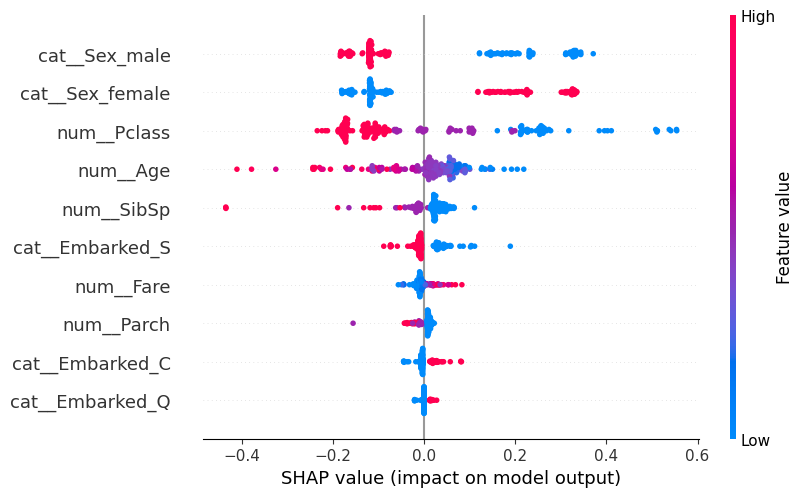

In [143]:
shap.plots.beeswarm(linear_shap)

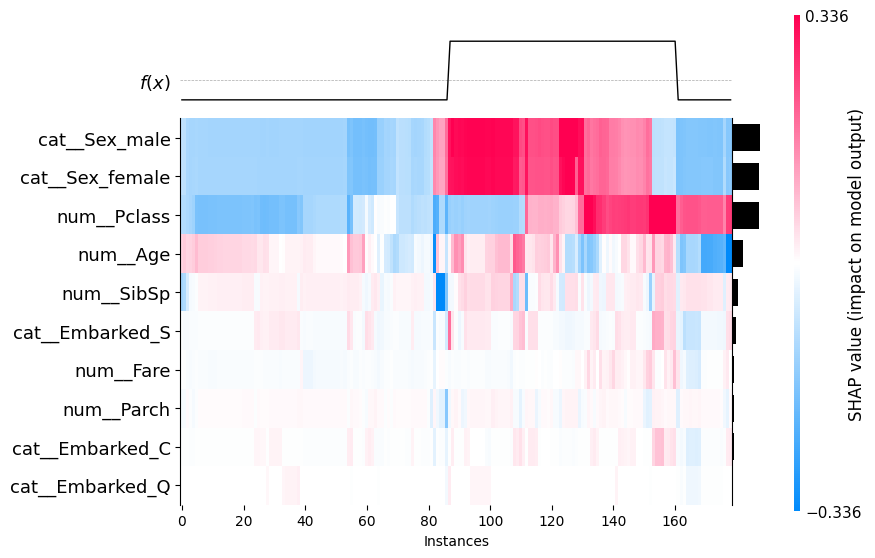

<Axes: xlabel='Instances'>

In [145]:
shap.plots.heatmap(linear_shap)

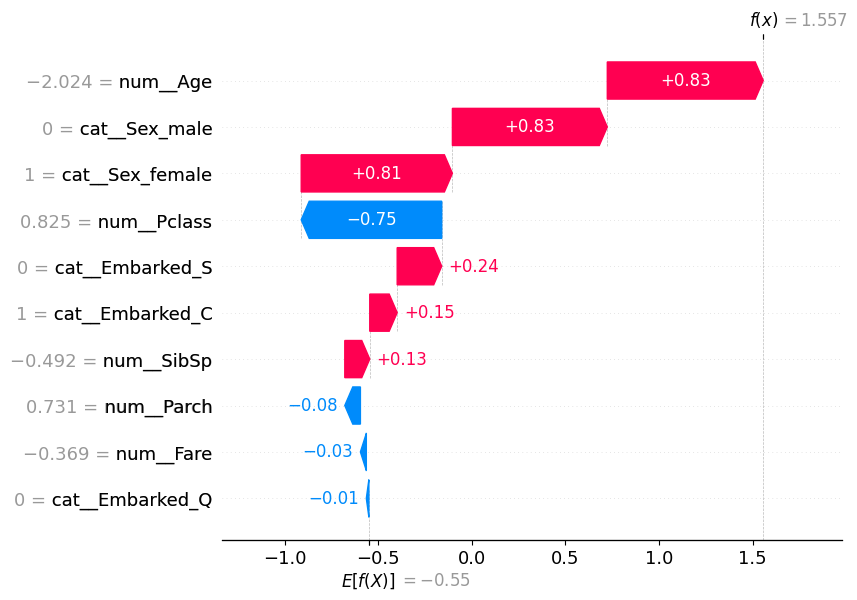

In [30]:
shap.plots.waterfall(linear_shap[0])

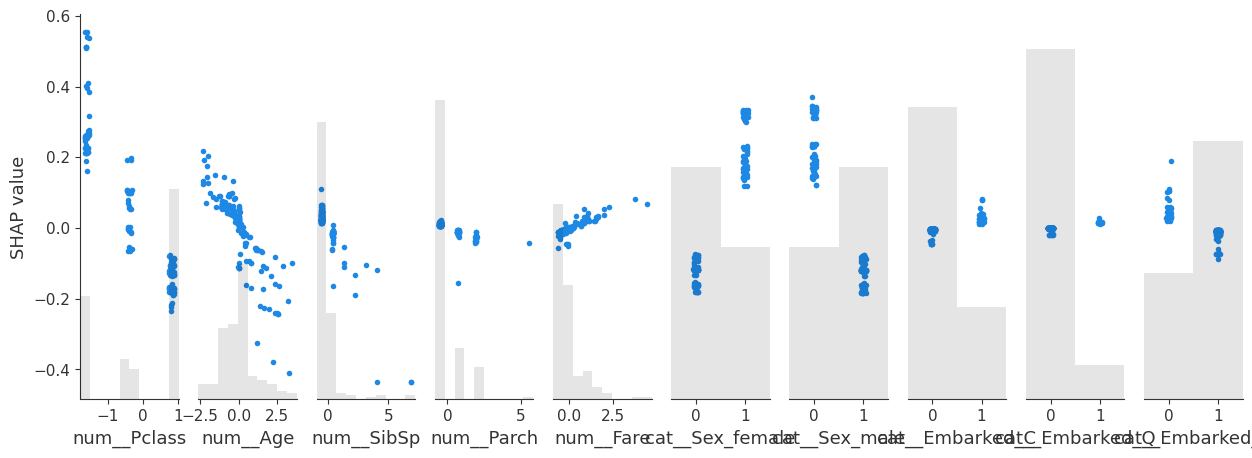

In [146]:
shap.plots.scatter(linear_shap, )

In [83]:
x_test.columns

Index(['num__Pclass', 'num__Age', 'num__SibSp', 'num__Parch', 'num__Fare',
       'cat__Sex_female', 'cat__Sex_male', 'cat__Embarked_C',
       'cat__Embarked_Q', 'cat__Embarked_S'],
      dtype='object')

2025-05-15 16:53:34 - WARNING: _kernel - Using 712 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/179 [00:00<?, ?it/s]

2025-05-15 16:53:34 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:53:37 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:53:37 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:53:37 - INFO: _kernel - phi = array([-0.1759001 ,  0.42839531, -0.01599173, -0.16408061, -0.10636258,
       -0.04584894, -0.02597367, -0.12008984, -0.018439  , -0.12789984])


  1%|          | 1/179 [00:02<08:41,  2.93s/it]

2025-05-15 16:53:37 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:53:40 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:53:40 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:53:40 - INFO: _kernel - phi = array([ 0.106284  , -0.0936625 ,  0.02927925, -0.18573546,  0.05747447,
       -0.13576222, -0.15357756, -0.00200029,  0.00158451,  0.00392478])


  1%|          | 2/179 [00:05<08:36,  2.92s/it]

2025-05-15 16:53:40 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:53:43 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:53:43 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:53:43 - INFO: _kernel - phi = array([ 0.17533267, -0.01774184,  0.        ,  0.01100515,  0.08134524,
        0.17815671,  0.20552763, -0.00974291, -0.00083941,  0.00476574])


  2%|▏         | 3/179 [00:08<08:20,  2.84s/it]

2025-05-15 16:53:43 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:53:45 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:53:45 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:53:45 - INFO: _kernel - phi = array([ 0.01516074,  0.73612783,  0.01360743, -0.00914203, -0.01014524,
       -0.03738742, -0.06592708, -0.00610565, -0.00089453, -0.00748506])


  2%|▏         | 4/179 [00:11<08:14,  2.82s/it]

2025-05-15 16:53:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:53:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:53:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:53:49 - INFO: _kernel - phi = array([ 0.04003589,  0.18729546,  0.03016263,  0.04858492,  0.26952359,
        0.0247871 , -0.00237482, -0.02085395,  0.0006153 ,  0.05003288])


  3%|▎         | 5/179 [00:15<09:02,  3.12s/it]

2025-05-15 16:53:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:53:53 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:53:53 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:53:53 - INFO: _kernel - phi = array([-0.07379448, -0.01238129,  0.01666165,  0.00536049, -0.179272  ,
       -0.04293238, -0.06776017, -0.00880317, -0.002916  , -0.00635367])


  3%|▎         | 6/179 [00:18<09:21,  3.25s/it]

2025-05-15 16:53:53 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:53:56 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:53:56 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:53:56 - INFO: _kernel - phi = array([-0.07672887, -0.05213349,  0.01344636, -0.00350455, -0.07863664,
       -0.06508828, -0.08799492, -0.0098532 , -0.00137774, -0.01031969])


  4%|▍         | 7/179 [00:21<09:26,  3.29s/it]

2025-05-15 16:53:56 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:53:59 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:53:59 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:53:59 - INFO: _kernel - phi = array([-0.10034332,  0.51556759,  0.03549804,  0.00843811,  0.02228743,
        0.05444868,  0.08239143,  0.01578161, -0.00229735, -0.00396324])


  4%|▍         | 8/179 [00:24<09:02,  3.17s/it]

2025-05-15 16:53:59 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:54:02 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:54:02 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:54:02 - INFO: _kernel - phi = array([-0.06860231, -0.07760779, -0.03440287, -0.00035391, -0.03359863,
       -0.04617052, -0.06503589, -0.02131264, -0.00415329, -0.02095316])


  5%|▌         | 9/179 [00:28<09:12,  3.25s/it]

2025-05-15 16:54:02 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:54:06 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:54:06 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:54:06 - INFO: _kernel - phi = array([-0.09421203, -0.11508717,  0.01283719,  0.00279506, -0.0415552 ,
       -0.07766074, -0.09570013,  0.0270393 , -0.00034778,  0.00970049])


  6%|▌         | 10/179 [00:31<09:12,  3.27s/it]

2025-05-15 16:54:06 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:54:09 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:54:09 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:54:09 - INFO: _kernel - phi = array([-0.0877965 , -0.01923879,  0.01182896, -0.00284633, -0.09536238,
       -0.07085897, -0.08816435, -0.00921504, -0.00550762, -0.00502998])


  6%|▌         | 11/179 [00:34<09:11,  3.28s/it]

2025-05-15 16:54:09 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:54:12 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:54:12 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:54:12 - INFO: _kernel - phi = array([-0.10036004, -0.031284  , -0.00271424, -0.01398531, -0.01846631,
       -0.0714726 , -0.09611312, -0.0133583 , -0.00289259, -0.0215445 ])


  7%|▋         | 12/179 [00:37<08:54,  3.20s/it]

2025-05-15 16:54:12 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:54:15 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:54:15 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:54:15 - INFO: _kernel - phi = array([-0.09708567, -0.05798221, -0.00751906, -0.01648943, -0.02326277,
       -0.05555277, -0.08237861, -0.01275582, -0.0034778 , -0.01568686])


  7%|▋         | 13/179 [00:40<08:43,  3.15s/it]

2025-05-15 16:54:15 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:54:19 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:54:19 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:54:19 - INFO: _kernel - phi = array([-0.07551387, -0.07644016,  0.01076389, -0.00040519, -0.12044264,
       -0.03754403, -0.05838572, -0.00778213, -0.00212681, -0.00431436])


  8%|▊         | 14/179 [00:44<09:03,  3.29s/it]

2025-05-15 16:54:19 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:54:22 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:54:22 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:54:22 - INFO: _kernel - phi = array([ 0.0842914 , -0.03147238,  0.02158072, -0.00077247, -0.0123746 ,
        0.2754481 ,  0.32309892, -0.01447744, -0.00430767, -0.01320559])


  8%|▊         | 15/179 [00:47<08:44,  3.20s/it]

2025-05-15 16:54:22 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:54:25 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:54:25 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:54:25 - INFO: _kernel - phi = array([-0.0907504 , -0.05988329,  0.01344971,  0.00246121, -0.03563236,
       -0.07362727, -0.10571161, -0.00744382, -0.00704922, -0.00800395])


  9%|▉         | 16/179 [00:50<08:54,  3.28s/it]

2025-05-15 16:54:25 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:54:28 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:54:28 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:54:28 - INFO: _kernel - phi = array([ 0.00215467,  0.18004392,  0.07260846,  0.04438815,  0.05039571,
       -0.06451534, -0.08151474,  0.23355515,  0.01927167,  0.17142133])


  9%|▉         | 17/179 [00:54<08:44,  3.24s/it]

2025-05-15 16:54:28 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:54:32 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:54:32 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:54:32 - INFO: _kernel - phi = array([-0.08590044, -0.10477751,  0.00801342, -0.00214576, -0.07184546,
       -0.03589876, -0.0594207 , -0.00839743, -0.0034477 , -0.00837068])


 10%|█         | 18/179 [00:57<08:55,  3.33s/it]

2025-05-15 16:54:32 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:54:34 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:54:34 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:54:34 - INFO: _kernel - phi = array([ 0.16168573, -0.02828719,  0.01009397,  0.00701077,  0.03723081,
        0.18718566,  0.22235821,  0.01955926, -0.00195459,  0.01292636])


 11%|█         | 19/179 [01:00<08:21,  3.13s/it]

2025-05-15 16:54:35 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:54:38 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:54:38 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:54:38 - INFO: _kernel - phi = array([ 0.10245619, -0.00389413,  0.02359049, -0.00474351, -0.04460273,
        0.27739934,  0.31229601, -0.01465913, -0.00505228, -0.01498127])


 11%|█         | 20/179 [01:03<08:19,  3.14s/it]

2025-05-15 16:54:38 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:54:41 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:54:41 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:54:41 - INFO: _kernel - phi = array([ 0.25930756,  0.00061976, -0.03366328,  0.00066992, -0.01169297,
        0.15311107,  0.20686474,  0.03085986, -0.0085128 ,  0.03024512])


 12%|█▏        | 21/179 [01:06<08:17,  3.15s/it]

2025-05-15 16:54:41 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:54:44 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:54:44 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:54:44 - INFO: _kernel - phi = array([ 0.10514535, -0.28396981,  0.00429263,  0.00242164,  0.05718354,
       -0.071841  , -0.16659087, -0.00929419, -0.00105003, -0.00848827])


 12%|█▏        | 22/179 [01:10<08:29,  3.25s/it]

2025-05-15 16:54:44 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:54:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:54:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:54:48 - INFO: _kernel - phi = array([-0.0834048 , -0.09231665,  0.00974161,  0.        , -0.08284133,
       -0.04346532, -0.06042794, -0.00821084, -0.00307998, -0.00818576])


 13%|█▎        | 23/179 [01:13<08:47,  3.38s/it]

2025-05-15 16:54:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:54:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:54:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:54:51 - INFO: _kernel - phi = array([-0.09536015, -0.10608781,  0.01318218,  0.00406969, -0.05788858,
       -0.06940877, -0.08915697,  0.02540463, -0.002187  ,  0.00524177])


 13%|█▎        | 24/179 [01:17<08:41,  3.37s/it]

2025-05-15 16:54:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:54:55 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:54:55 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:54:55 - INFO: _kernel - phi = array([-0.0808933 , -0.05009475,  0.01163445, -0.0081104 , -0.08485097,
       -0.051735  , -0.07304653, -0.01094781, -0.00521001, -0.01893671])


 14%|█▍        | 25/179 [01:20<08:38,  3.37s/it]

2025-05-15 16:54:55 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:54:58 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:54:58 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:54:58 - INFO: _kernel - phi = array([ 0.11922095, -0.30344826,  0.00217808,  0.00161461,  0.06458612,
       -0.07263131, -0.16469926, -0.00942237, -0.00108848, -0.00850109])


 15%|█▍        | 26/179 [01:23<08:23,  3.29s/it]

2025-05-15 16:54:58 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:01 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:01 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:01 - INFO: _kernel - phi = array([-0.08069043, -0.05486947,  0.01421493, -0.0014318 , -0.12942304,
       -0.04232265, -0.06021658, -0.01048076, -0.00165864, -0.00531256])


 15%|█▌        | 27/179 [01:26<08:14,  3.25s/it]

2025-05-15 16:55:01 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:04 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:04 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:04 - INFO: _kernel - phi = array([ 0.09930388, -0.17585663,  0.00843811,  0.00423299, -0.00052724,
       -0.14788546, -0.15755807,  0.00584649, -0.00112861, -0.00705647])


 16%|█▌        | 28/179 [01:30<08:08,  3.24s/it]

2025-05-15 16:55:04 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:07 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:07 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:07 - INFO: _kernel - phi = array([ 3.02832954e-01, -1.25666577e-01, -1.73332442e-04, -2.17089130e-02,
        5.05957954e-02,  1.90498484e-01,  1.87104289e-01,  3.62749688e-02,
       -1.97855359e-04,  8.24917514e-03])


 16%|█▌        | 29/179 [01:32<07:33,  3.03s/it]

2025-05-15 16:55:07 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:10 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:10 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:10 - INFO: _kernel - phi = array([-0.12483837,  0.13404338,  0.00691825,  0.05288033,  0.06509943,
        0.17253489,  0.16925941, -0.0052061 ,  0.06252285,  0.09459493])


 17%|█▋        | 30/179 [01:35<07:40,  3.09s/it]

2025-05-15 16:55:10 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:13 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:13 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:13 - INFO: _kernel - phi = array([-0.06852205, -0.20079365,  0.02675283,  0.02046939,  0.08936987,
       -0.10935605, -0.13325419, -0.00261113, -0.00141787,  0.00717184])


 17%|█▋        | 31/179 [01:39<07:48,  3.17s/it]

2025-05-15 16:55:13 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:16 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:16 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:16 - INFO: _kernel - phi = array([ 0.32492364, -0.00116818, -0.0856736 , -0.03214564, -0.00161628,
        0.27215144,  0.17748685, -0.0099329 , -0.00354133, -0.012675  ])


 18%|█▊        | 32/179 [01:41<07:13,  2.95s/it]

2025-05-15 16:55:16 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:19 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:19 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:19 - INFO: _kernel - phi = array([-0.01047129, -0.04453027,  0.00435616, -0.0086538 , -0.04672563,
       -0.09865848, -0.12414337, -0.02020911, -0.0031367 , -0.0200185 ])


 18%|█▊        | 33/179 [01:44<07:16,  2.99s/it]

2025-05-15 16:55:19 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:22 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:22 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:22 - INFO: _kernel - phi = array([ 0.03349719, -0.11761804,  0.02103899,  0.00074739,  0.01031133,
       -0.13789292, -0.17439473, -0.0075826 ,  0.00051498, -0.0008126 ])


 19%|█▉        | 34/179 [01:48<07:31,  3.11s/it]

2025-05-15 16:55:22 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:25 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:25 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:25 - INFO: _kernel - phi = array([ 0.34416856, -0.09380629,  0.00680901,  0.00693274,  0.02021357,
        0.15342652,  0.17350243,  0.01949293, -0.00069779, -0.0022327 ])


 20%|█▉        | 35/179 [01:50<07:07,  2.97s/it]

2025-05-15 16:55:25 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:27 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:27 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:27 - INFO: _kernel - phi = array([ 3.38392300e-01,  3.08765828e-04, -1.88274701e-02, -1.74764803e-02,
        2.02341939e-02,  1.36611602e-01,  1.88449148e-01, -7.09827002e-03,
       -3.24872927e-03, -9.53607098e-03])


 20%|██        | 36/179 [01:53<06:51,  2.88s/it]

2025-05-15 16:55:28 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:31 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:31 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:31 - INFO: _kernel - phi = array([-0.12483837,  0.13404338,  0.00691825,  0.05288033,  0.06509943,
        0.17253489,  0.16925941, -0.0052061 ,  0.06252285,  0.09459493])


 21%|██        | 37/179 [01:56<07:04,  2.99s/it]

2025-05-15 16:55:31 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:34 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:34 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:34 - INFO: _kernel - phi = array([-0.08387228, -0.05597969,  0.01336889, -0.00670869, -0.07685817,
       -0.0513365 , -0.06638298, -0.02138231, -0.00266854, -0.02037074])


 21%|██        | 38/179 [01:59<07:17,  3.10s/it]

2025-05-15 16:55:34 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:37 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:37 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:37 - INFO: _kernel - phi = array([-0.08136927, -0.06272795,  0.01007   , -0.00597467, -0.08501594,
       -0.04217552, -0.0614104 , -0.02180533, -0.00228732, -0.0194946 ])


 22%|██▏       | 39/179 [02:03<07:25,  3.18s/it]

2025-05-15 16:55:38 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:41 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:41 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:41 - INFO: _kernel - phi = array([-0.086353  , -0.09227026,  0.02010099,  0.00861423, -0.02349853,
       -0.12018793, -0.13875234,  0.03940443,  0.00271536,  0.01803605])


 22%|██▏       | 40/179 [02:06<07:31,  3.25s/it]

2025-05-15 16:55:41 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:44 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:44 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:44 - INFO: _kernel - phi = array([-0.08080078, -0.0556386 ,  0.01150961, -0.00542458, -0.07062154,
       -0.05066268, -0.07034232, -0.02183543, -0.00393593, -0.02443876])


 23%|██▎       | 41/179 [02:10<07:35,  3.30s/it]

2025-05-15 16:55:44 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:48 - INFO: _kernel - phi = array([-0.08172095, -0.05790474,  0.01373618,  0.00173611, -0.13062745,
       -0.03871333, -0.06453094, -0.00774423, -0.00178906, -0.0046326 ])


 23%|██▎       | 42/179 [02:13<07:42,  3.37s/it]

2025-05-15 16:55:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:51 - INFO: _kernel - phi = array([ 0.013924  , -0.0581065 , -0.00122615, -0.01171805, -0.00485275,
       -0.14716482, -0.1665251 ,  0.00794988, -0.00052223, -0.0039493 ])


 24%|██▍       | 43/179 [02:16<07:19,  3.23s/it]

2025-05-15 16:55:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:54 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:54 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:54 - INFO: _kernel - phi = array([-0.07448446, -0.0474563 , -0.0072978 ,  0.01381811, -0.02074583,
       -0.1230482 , -0.14052078, -0.00451445,  0.01712536,  0.01493334])


 25%|██▍       | 44/179 [02:19<07:19,  3.25s/it]

2025-05-15 16:55:54 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:55:57 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:55:57 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:55:57 - INFO: _kernel - phi = array([-0.08171761, -0.05486   ,  0.00975511, -0.00609395, -0.09040875,
       -0.04798466, -0.06984294, -0.00887618, -0.00485554, -0.01730649])


 25%|██▌       | 45/179 [02:23<07:23,  3.31s/it]

2025-05-15 16:55:58 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:00 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:00 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:00 - INFO: _kernel - phi = array([ 0.16341849, -0.00288033,  0.00768849,  0.00282125,  0.0227634 ,
        0.17206617,  0.21391174,  0.02556403, -0.00178348,  0.02423923])


 26%|██▌       | 46/179 [02:26<06:55,  3.12s/it]

2025-05-15 16:56:00 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:03 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:03 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:03 - INFO: _kernel - phi = array([ 0.27934724,  0.01808955,  0.02614533,  0.00553438, -0.04066513,
        0.17190175,  0.19507925, -0.01017199, -0.00431436, -0.01313704])


 26%|██▋       | 47/179 [02:29<06:47,  3.08s/it]

2025-05-15 16:56:03 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:06 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:06 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:06 - INFO: _kernel - phi = array([ 0.34618278,  0.0578217 ,  0.00821128,  0.01114901,  0.3619265 ,
       -0.06525214, -0.08241874, -0.00697566,  0.0008544 , -0.00369014])


 27%|██▋       | 48/179 [02:32<06:45,  3.09s/it]

2025-05-15 16:56:06 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:10 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:10 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:10 - INFO: _kernel - phi = array([-0.08905665, -0.06475722,  0.0092195 , -0.00098315, -0.05981976,
       -0.05658106, -0.07122626, -0.00888175, -0.00814272, -0.02196194])


 27%|██▋       | 49/179 [02:35<06:57,  3.21s/it]

2025-05-15 16:56:10 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:13 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:13 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:13 - INFO: _kernel - phi = array([ 2.13597958e-01, -6.97286874e-03, -3.39023765e-02,  3.20469948e-03,
        1.80020510e-04,  1.28393637e-01,  3.52494092e-01, -5.71774122e-03,
       -9.09688782e-03, -1.43715445e-02])


 28%|██▊       | 50/179 [02:38<06:43,  3.13s/it]

2025-05-15 16:56:13 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:16 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:16 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:16 - INFO: _kernel - phi = array([ 0.32584548,  0.01470316,  0.00297062,  0.0567895 ,  0.31726971,
       -0.07308443, -0.08910235,  0.02545089, -0.00054006,  0.04750647])


 28%|██▊       | 51/179 [02:41<06:39,  3.12s/it]

2025-05-15 16:56:16 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:19 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:19 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:19 - INFO: _kernel - phi = array([-0.07596141, -0.06105705,  0.01237293, -0.00561965, -0.05015215,
       -0.06203685, -0.08147071, -0.02332464, -0.00300963, -0.02193185])


 29%|██▉       | 52/179 [02:45<06:45,  3.19s/it]

2025-05-15 16:56:19 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:23 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:23 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:23 - INFO: _kernel - phi = array([-0.08412531, -0.06047463,  0.01452203, -0.00730449, -0.08970149,
       -0.05191223, -0.06805723, -0.01024222, -0.00241439, -0.01248105])


 30%|██▉       | 53/179 [02:48<06:49,  3.25s/it]

2025-05-15 16:56:23 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:26 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:26 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:26 - INFO: _kernel - phi = array([ 0.33964576, -0.05011648,  0.07318809,  0.05295668,  0.38591381,
       -0.06950854, -0.08711655, -0.00927245, -0.00138945, -0.00649189])


 30%|███       | 54/179 [02:51<06:44,  3.23s/it]

2025-05-15 16:56:26 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:29 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:29 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:29 - INFO: _kernel - phi = array([ 0.01080067,  0.01170858,  0.01127051,  0.00645677, -0.0964425 ,
       -0.1384419 , -0.16571083, -0.00739255,  0.00097144, -0.0054112 ])


 31%|███       | 55/179 [02:54<06:42,  3.24s/it]

2025-05-15 16:56:29 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:32 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:32 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:32 - INFO: _kernel - phi = array([-0.24975198, -0.1319868 , -0.03857121, -0.2426108 , -0.02782181,
        0.12500892,  0.15532092,  0.03668796, -0.01868089,  0.02021469])


 31%|███▏      | 56/179 [02:57<06:29,  3.16s/it]

2025-05-15 16:56:32 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:35 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:35 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:35 - INFO: _kernel - phi = array([-0.07842708, -0.05009308,  0.01085696, -0.00639825, -0.05766564,
       -0.06095784, -0.08082308, -0.02351302, -0.002916  , -0.02225399])


 32%|███▏      | 57/179 [03:01<06:31,  3.21s/it]

2025-05-15 16:56:35 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:39 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:39 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:39 - INFO: _kernel - phi = array([-0.08556046, -0.06219736,  0.00917937, -0.00187433, -0.08488998,
       -0.05256822, -0.0668439 , -0.00796382, -0.00494583, -0.01452648])


 32%|███▏      | 58/179 [03:04<06:42,  3.33s/it]

2025-05-15 16:56:39 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:42 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:42 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:42 - INFO: _kernel - phi = array([ 0.04182997, -0.07072521,  0.0041845 ,  0.00177345, -0.05595795,
       -0.0858904 , -0.18178393, -0.01179664, -0.00160346, -0.01222133])


 33%|███▎      | 59/179 [03:07<06:34,  3.29s/it]

2025-05-15 16:56:42 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:45 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:45 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:45 - INFO: _kernel - phi = array([-0.15079978, -0.00257714,  0.02840869, -0.01272795,  0.20134709,
        0.24781412,  0.28865146, -0.00315398,  0.04084682, -0.01000033])


 34%|███▎      | 60/179 [03:10<06:19,  3.19s/it]

2025-05-15 16:56:45 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:48 - INFO: _kernel - phi = array([-0.12260902,  0.00511637,  0.02652154,  0.02562533,  0.10342764,
        0.1770616 ,  0.20799893,  0.11964286,  0.00879481,  0.07622893])


 34%|███▍      | 61/179 [03:14<06:13,  3.16s/it]

2025-05-15 16:56:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:51 - INFO: _kernel - phi = array([ 0.14655509,  0.0257786 ,  0.01183732,  0.01176877,  0.09505529,
        0.14556358,  0.19708846, -0.00753522, -0.00055288,  0.00224998])


 35%|███▍      | 62/179 [03:16<05:54,  3.03s/it]

2025-05-15 16:56:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:54 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:54 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:54 - INFO: _kernel - phi = array([-0.07337536, -0.05500825,  0.01370664,  0.00184033, -0.12227183,
       -0.0506376 , -0.07403915, -0.00912308, -0.00152154, -0.00176119])


 35%|███▌      | 63/179 [03:20<05:59,  3.10s/it]

2025-05-15 16:56:54 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:56:57 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:56:57 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:56:57 - INFO: _kernel - phi = array([ 0.23480025, -0.03185638, -0.02237438, -0.02716136,  0.06133516,
        0.13138933,  0.31567739, -0.00710217, -0.00672318, -0.02017567])


 36%|███▌      | 64/179 [03:22<05:46,  3.01s/it]

2025-05-15 16:56:57 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:00 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:00 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:00 - INFO: _kernel - phi = array([-0.27879046, -0.04988797, -0.09808052, -0.07950943, -0.0097696 ,
        0.09072365,  0.10650916, -0.01784154, -0.00793261, -0.02761169])


 36%|███▋      | 65/179 [03:25<05:30,  2.90s/it]

2025-05-15 16:57:00 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:03 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:03 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:03 - INFO: _kernel - phi = array([ 0.10982812, -0.25778993,  0.00851726,  0.00744382,  0.06320559,
       -0.13802669, -0.1531367 , -0.00560962, -0.00100823, -0.00561463])


 37%|███▋      | 66/179 [03:28<05:39,  3.00s/it]

2025-05-15 16:57:03 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:06 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:06 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:06 - INFO: _kernel - phi = array([-0.07165262,  0.56698937,  0.03585139, -0.00427368, -0.00265182,
       -0.026667  , -0.05533373,  0.12579588,  0.00192951,  0.0578217 ])


 37%|███▋      | 67/179 [03:31<05:35,  3.00s/it]

2025-05-15 16:57:06 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:09 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:09 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:09 - INFO: _kernel - phi = array([ 0.27404974, -0.03526005, -0.0081065 ,  0.00471119,  0.05390862,
        0.15187712,  0.21792347, -0.00872904, -0.00642333, -0.01614221])


 38%|███▊      | 68/179 [03:34<05:23,  2.91s/it]

2025-05-15 16:57:09 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:12 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:12 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:12 - INFO: _kernel - phi = array([-0.00184535, -0.12818798, -0.01305455, -0.00124844, -0.04938748,
       -0.06876115, -0.08982689, -0.01103364, -0.00223995, -0.00660558])


 39%|███▊      | 69/179 [03:37<05:28,  2.99s/it]

2025-05-15 16:57:12 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:15 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:15 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:15 - INFO: _kernel - phi = array([-0.08100254, -0.04250602,  0.01405498, -0.00323368, -0.06424559,
       -0.07243178, -0.09877441, -0.01174926, -0.0013744 , -0.0109283 ])


 39%|███▉      | 70/179 [03:40<05:34,  3.07s/it]

2025-05-15 16:57:15 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:18 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:18 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:18 - INFO: _kernel - phi = array([ 0.23291979, -0.10930366,  0.01535525, -0.01990927, -0.04327069,
        0.25244226,  0.31999342, -0.0109963 , -0.00241551, -0.00700631])


 40%|███▉      | 71/179 [03:43<05:21,  2.97s/it]

2025-05-15 16:57:18 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:21 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:21 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:21 - INFO: _kernel - phi = array([-0.09945994, -0.03079856, -0.03717563, -0.00434223, -0.029374  ,
       -0.05425194, -0.07450843, -0.01390115, -0.00626338, -0.02211577])


 40%|████      | 72/179 [03:46<05:18,  2.98s/it]

2025-05-15 16:57:21 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:24 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:24 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:24 - INFO: _kernel - phi = array([-0.24039259, -0.08109952, -0.14821596, -0.04585841, -0.03801665,
        0.12002742,  0.15662955, -0.01259363, -0.02216259, -0.06050863])


 41%|████      | 73/179 [03:49<05:22,  3.05s/it]

2025-05-15 16:57:24 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:27 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:27 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:27 - INFO: _kernel - phi = array([-0.07678739, -0.04656735,  0.01284778, -0.00496422, -0.08509564,
       -0.06613329, -0.08584136, -0.00980304, -0.00168205, -0.00816446])


 41%|████▏     | 74/179 [03:53<05:31,  3.16s/it]

2025-05-15 16:57:27 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:30 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:30 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:30 - INFO: _kernel - phi = array([-0.1353509 ,  0.32079878,  0.01499186,  0.01475611, -0.0281746 ,
        0.12968722,  0.20301186,  0.04775838, -0.00784176,  0.06817204])


 42%|████▏     | 75/179 [03:56<05:29,  3.17s/it]

2025-05-15 16:57:31 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:33 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:33 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:33 - INFO: _kernel - phi = array([-0.12395109,  0.14335596, -0.19937912, -0.04344346, -0.03487605,
       -0.04130328, -0.04922363, -0.01174425, -0.00136381, -0.01026228])


 42%|████▏     | 76/179 [03:59<05:13,  3.05s/it]

2025-05-15 16:57:33 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:37 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:37 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:37 - INFO: _kernel - phi = array([-0.08266174, -0.08939662,  0.00802345, -0.00294164, -0.08531356,
       -0.04380072, -0.05933877, -0.00976012, -0.00176899, -0.0052323 ])


 43%|████▎     | 77/179 [04:02<05:20,  3.14s/it]

2025-05-15 16:57:37 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:40 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:40 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:40 - INFO: _kernel - phi = array([-0.24267489, -0.0892088 ,  0.03253745, -0.06108046, -0.17490804,
        0.0950107 ,  0.1134798 , -0.01891386, -0.00471174, -0.02172117])


 44%|████▎     | 78/179 [04:05<05:23,  3.20s/it]

2025-05-15 16:57:40 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:43 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:43 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:43 - INFO: _kernel - phi = array([-0.09900682, -0.14734316,  0.00593064, -0.01056715, -0.02173288,
       -0.06132959, -0.08819222,  0.02932718, -0.0004743 ,  0.02119728])


 44%|████▍     | 79/179 [04:08<05:16,  3.16s/it]

2025-05-15 16:57:43 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:46 - INFO: _kernel - phi = array([ 0.03219079, -0.06347702,  0.00484662, -0.00239823, -0.11763532,
       -0.08571652, -0.11442171, -0.01298544, -0.00038289, -0.0122113 ])


 45%|████▍     | 80/179 [04:11<05:09,  3.13s/it]

2025-05-15 16:57:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:49 - INFO: _kernel - phi = array([-0.21851982, -0.1429714 ,  0.03017601,  0.01524824, -0.18824795,
        0.1086956 ,  0.13373908, -0.04802256,  0.00107176, -0.06335997])


 45%|████▌     | 81/179 [04:15<05:11,  3.18s/it]

2025-05-15 16:57:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:53 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:53 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:53 - INFO: _kernel - phi = array([-0.08996901, -0.14335485,  0.01338004,  0.00245341, -0.04015628,
       -0.05748339, -0.07839029,  0.02126694,  0.00066212, -0.0005997 ])


 46%|████▌     | 82/179 [04:18<05:08,  3.18s/it]

2025-05-15 16:57:53 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:56 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:56 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:56 - INFO: _kernel - phi = array([-0.08556046, -0.06219736,  0.00917937, -0.00187433, -0.08488998,
       -0.05256822, -0.0668439 , -0.00796382, -0.00494583, -0.01452648])


 46%|████▋     | 83/179 [04:21<05:14,  3.28s/it]

2025-05-15 16:57:56 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:57:59 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:57:59 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:57:59 - INFO: _kernel - phi = array([-0.26486925, -0.0861256 , -0.17090857, -0.02526585,  0.02583768,
        0.10503444,  0.135522  , -0.01381198, -0.00802624, -0.06957765])


 47%|████▋     | 84/179 [04:25<05:06,  3.22s/it]

2025-05-15 16:57:59 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:02 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:02 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:02 - INFO: _kernel - phi = array([ 0.10282125, -0.01441056,  0.02446718,  0.00681403,  0.01971698,
        0.15452671,  0.35516542, -0.00988664, -0.00207776, -0.00932763])


 47%|████▋     | 85/179 [04:28<05:01,  3.20s/it]

2025-05-15 16:58:02 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:06 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:06 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:06 - INFO: _kernel - phi = array([-0.07685482, -0.03507613,  0.00596854,  0.00930255, -0.02495708,
       -0.12398899, -0.13889836, -0.00754358,  0.00947476,  0.01038211])


 48%|████▊     | 86/179 [04:31<05:06,  3.30s/it]

2025-05-15 16:58:06 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:09 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:09 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:09 - INFO: _kernel - phi = array([-0.1319829 ,  0.0832057 ,  0.00303081,  0.04715033,  0.04332475,
        0.28312377,  0.16283385, -0.00699683,  0.06535358,  0.07876594])


 49%|████▊     | 87/179 [04:35<05:04,  3.31s/it]

2025-05-15 16:58:09 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:13 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:13 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:13 - INFO: _kernel - phi = array([ 0.1197259 , -0.28460462,  0.00366116,  0.00208779,  0.03534923,
       -0.07282025, -0.16518247, -0.00863318, -0.00067048, -0.00110409])


 49%|████▉     | 88/179 [04:38<05:03,  3.34s/it]

2025-05-15 16:58:13 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:16 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:16 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:16 - INFO: _kernel - phi = array([ 0.02001739, -0.03399378, -0.01932183, -0.00202648, -0.03767556,
       -0.1495218 , -0.16628377,  0.01548121, -0.00256822,  0.00370185])


 50%|████▉     | 89/179 [04:41<04:58,  3.32s/it]

2025-05-15 16:58:16 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:20 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:20 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:20 - INFO: _kernel - phi = array([-0.08556046, -0.06219736,  0.00917937, -0.00187433, -0.08488998,
       -0.05256822, -0.0668439 , -0.00796382, -0.00494583, -0.01452648])


 50%|█████     | 90/179 [04:45<05:05,  3.44s/it]

2025-05-15 16:58:20 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:23 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:23 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:23 - INFO: _kernel - phi = array([ 0.29698591, -0.04776897,  0.01354724, -0.00394373,  0.03942839,
        0.15737582,  0.20124788, -0.0125875 , -0.00663512, -0.00984094])


 51%|█████     | 91/179 [04:48<04:52,  3.33s/it]

2025-05-15 16:58:23 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:25 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:25 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:26 - INFO: _kernel - phi = array([ 0.2237092 , -0.01467028, -0.13537654,  0.0036567 , -0.00960407,
        0.27129314,  0.3163841 , -0.0060488 , -0.00903279, -0.01250167])


 51%|█████▏    | 92/179 [04:51<04:37,  3.19s/it]

2025-05-15 16:58:26 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:29 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:29 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:29 - INFO: _kernel - phi = array([ 0.10769462, -0.23791968,  0.00967429,  0.00768961,  0.06254347,
       -0.13827749, -0.15444422, -0.01398977, -0.00119048, -0.01397138])


 52%|█████▏    | 93/179 [04:55<04:44,  3.31s/it]

2025-05-15 16:58:29 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:32 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:32 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:32 - INFO: _kernel - phi = array([ 3.22045546e-01, -1.07017456e-01, -1.88937935e-03,  2.72538791e-04,
        4.51210540e-02,  1.45980471e-01,  1.71122592e-01,  3.55353799e-02,
       -3.33678884e-03,  1.99750312e-02])


 53%|█████▎    | 94/179 [04:57<04:26,  3.14s/it]

2025-05-15 16:58:32 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:35 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:35 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:35 - INFO: _kernel - phi = array([ 0.07012997, -0.11066858,  0.00930199, -0.01748373,  0.01074828,
       -0.13312712, -0.16497068, -0.01756287, -0.00087056, -0.01768771])


 53%|█████▎    | 95/179 [05:00<04:15,  3.05s/it]

2025-05-15 16:58:35 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:38 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:38 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:38 - INFO: _kernel - phi = array([ 0.09462446, -0.20392422,  0.00271034,  0.00151819,  0.0195091 ,
       -0.07466727, -0.17156233, -0.02106407, -0.00098649, -0.01834872])


 54%|█████▎    | 96/179 [05:03<04:14,  3.06s/it]

2025-05-15 16:58:38 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:40 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:40 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:40 - INFO: _kernel - phi = array([-0.14793952,  0.35467719, -0.45060471, -0.02319366, -0.01175874,
       -0.03733224, -0.04145544, -0.0085663 , -0.00111746, -0.00490012])


 54%|█████▍    | 97/179 [05:06<03:58,  2.91s/it]

2025-05-15 16:58:40 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:44 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:44 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:44 - INFO: _kernel - phi = array([-0.14207074, -0.04239344,  0.01886425, -0.00779271, -0.04422764,
       -0.07233425, -0.10184702,  0.01731429, -0.00359818,  0.00589442])


 55%|█████▍    | 98/179 [05:09<04:05,  3.03s/it]

2025-05-15 16:58:44 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:47 - INFO: _kernel - phi = array([-0.07734863, -0.03462357,  0.00517211,  0.00901106, -0.02468678,
       -0.12587725, -0.13743256, -0.00577738,  0.00906289,  0.0103091 ])


 55%|█████▌    | 99/179 [05:12<04:08,  3.10s/it]

2025-05-15 16:58:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:50 - INFO: _kernel - phi = array([-7.15957731e-02,  6.75307651e-01,  4.39021536e-02,  1.16756956e-02,
        4.66275415e-02, -2.44499064e-02, -4.59838149e-02, -7.01857054e-03,
       -8.23189763e-04,  1.67201712e-04])


 56%|█████▌    | 100/179 [05:15<03:58,  3.02s/it]

2025-05-15 16:58:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:53 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:53 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:53 - INFO: _kernel - phi = array([ 0.10514535, -0.28396981,  0.00429263,  0.00242164,  0.05718354,
       -0.071841  , -0.16659087, -0.00929419, -0.00105003, -0.00848827])


 56%|█████▋    | 101/179 [05:18<03:56,  3.03s/it]

2025-05-15 16:58:53 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:56 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:56 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:56 - INFO: _kernel - phi = array([-0.12483837,  0.13404338,  0.00691825,  0.05288033,  0.06509943,
        0.17253489,  0.16925941, -0.0052061 ,  0.06252285,  0.09459493])


 57%|█████▋    | 102/179 [05:21<03:57,  3.09s/it]

2025-05-15 16:58:56 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:58:59 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:58:59 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:58:59 - INFO: _kernel - phi = array([ 0.33798321, -0.07885734, -0.02016118,  0.00158006,  0.0575408 ,
        0.15618646,  0.19457765, -0.00819734, -0.0032426 , -0.00960072])


 58%|█████▊    | 103/179 [05:24<03:44,  2.95s/it]

2025-05-15 16:58:59 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:59:02 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:59:02 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:59:02 - INFO: _kernel - phi = array([-0.01101859, -0.05021402,  0.01236289, -0.00830825, -0.07452348,
       -0.08532136, -0.11894061, -0.01700943, -0.00226893, -0.01694924])


 58%|█████▊    | 104/179 [05:27<03:45,  3.01s/it]

2025-05-15 16:59:02 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:59:05 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:59:05 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:59:05 - INFO: _kernel - phi = array([ 4.46824282e-02, -6.93140271e-02, -1.24286606e-04, -1.24955413e-03,
       -1.30329276e-01, -8.55978019e-02, -1.08974273e-01, -1.36107767e-02,
       -4.58132691e-04, -7.21531122e-03])


 59%|█████▊    | 105/179 [05:30<03:43,  3.02s/it]

2025-05-15 16:59:05 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:59:08 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:59:08 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:59:08 - INFO: _kernel - phi = array([-0.0758923 , -0.0696306 ,  0.01443007,  0.00404851, -0.12190956,
       -0.04209415, -0.06956371, -0.0075904 , -0.00207665, -0.00191223])


 59%|█████▉    | 106/179 [05:34<03:52,  3.19s/it]

2025-05-15 16:59:08 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:59:12 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:59:12 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:59:12 - INFO: _kernel - phi = array([ 0.01415753, -0.11379693,  0.00253199, -0.0085167 , -0.00789471,
       -0.06907716, -0.16926944, -0.01057941, -0.00143682, -0.00830937])


 60%|█████▉    | 107/179 [05:37<03:48,  3.17s/it]

2025-05-15 16:59:12 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:59:15 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:59:15 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:59:15 - INFO: _kernel - phi = array([ 0.09325341, -0.04342897,  0.03017322,  0.00121221, -0.02555344,
        0.27396837,  0.33155431, -0.0106814 , -0.00409923, -0.01858949])


 60%|██████    | 108/179 [05:40<03:42,  3.13s/it]

2025-05-15 16:59:15 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:59:18 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:59:18 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:59:18 - INFO: _kernel - phi = array([-0.12876204,  0.1423221 ,  0.00064707,  0.02925863, -0.03501371,
        0.1217797 ,  0.28671248, -0.02086677,  0.03379815,  0.19793339])


 61%|██████    | 109/179 [05:43<03:43,  3.19s/it]

2025-05-15 16:59:18 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:59:21 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:59:21 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:59:21 - INFO: _kernel - phi = array([ 0.07157961, -0.09254726,  0.00200698,  0.0040669 , -0.06555756,
       -0.14733425, -0.1615163 ,  0.01526106, -0.00187099,  0.0037208 ])


 61%|██████▏   | 110/179 [05:46<03:39,  3.18s/it]

2025-05-15 16:59:21 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:59:24 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:59:24 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:59:24 - INFO: _kernel - phi = array([ 0.28191602,  0.08194779,  0.1641174 ,  0.00345829,  0.24182774,
       -0.07024255, -0.08641598,  0.00127631, -0.00056291,  0.01048689])


 62%|██████▏   | 111/179 [05:50<03:39,  3.23s/it]

2025-05-15 16:59:24 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:59:28 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:59:28 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:59:28 - INFO: _kernel - phi = array([ 0.10871957, -0.0621238 ,  0.01675696,  0.00844369,  0.04430344,
        0.15537888,  0.35742041, -0.0058933 , -0.00143515,  0.0062383 ])


 63%|██████▎   | 112/179 [05:53<03:35,  3.22s/it]

2025-05-15 16:59:28 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:59:31 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:59:31 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:59:31 - INFO: _kernel - phi = array([ 0.32036684, -0.0274796 ,  0.00704755,  0.05485052,  0.3500117 ,
       -0.07100221, -0.08994449,  0.02703317,  0.0138443 ,  0.04308119])


 63%|██████▎   | 113/179 [05:56<03:31,  3.21s/it]

2025-05-15 16:59:31 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:59:34 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:59:34 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:59:34 - INFO: _kernel - phi = array([-0.06713985, -0.10310995,  0.01199839, -0.00103331, -0.09450575,
       -0.04205959, -0.05713784, -0.00767456, -0.00331059, -0.00821796])


 64%|██████▎   | 114/179 [06:00<03:38,  3.36s/it]

2025-05-15 16:59:35 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:59:37 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:59:37 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:59:37 - INFO: _kernel - phi = array([-0.04257903, -0.06701054,  0.00214408, -0.02400626,  0.00934379,
       -0.05844982, -0.17964263, -0.00766174, -0.00134653, -0.00298232])


 64%|██████▍   | 115/179 [06:03<03:27,  3.25s/it]

2025-05-15 16:59:38 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:59:41 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:59:41 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:59:41 - INFO: _kernel - phi = array([ 0.03082809, -0.04377564,  0.01115681, -0.00205045, -0.05784901,
       -0.14900738, -0.16655687,  0.00994293, -0.00213015, -0.00274935])


 65%|██████▍   | 116/179 [06:06<03:25,  3.26s/it]

2025-05-15 16:59:41 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:59:44 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:59:44 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:59:44 - INFO: _kernel - phi = array([ 0.10414772,  0.29465902,  0.0244644 , -0.00446317,  0.03267735,
        0.08434936,  0.10532983, -0.00548422, -0.00173946, -0.00613184])


 65%|██████▌   | 117/179 [06:09<03:15,  3.15s/it]

2025-05-15 16:59:44 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:59:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:59:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:59:47 - INFO: _kernel - phi = array([ 0.19397461,  0.1458874 ,  0.07646692,  0.0400972 ,  0.15217585,
       -0.01029071, -0.03856953,  0.01833255,  0.01333768,  0.03639703])


 66%|██████▌   | 118/179 [06:12<03:15,  3.20s/it]

2025-05-15 16:59:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:59:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:59:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:59:50 - INFO: _kernel - phi = array([-0.09238508,  0.39463171,  0.0027527 ,  0.00927356,  0.04883182,
        0.07218488,  0.09054196,  0.03885656, -0.00246177,  0.06558264])


 66%|██████▋   | 119/179 [06:15<03:05,  3.09s/it]

2025-05-15 16:59:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:59:53 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:59:53 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:59:53 - INFO: _kernel - phi = array([-0.086353  , -0.09227026,  0.02010099,  0.00861423, -0.02349853,
       -0.12018793, -0.13875234,  0.03940443,  0.00271536,  0.01803605])


 67%|██████▋   | 120/179 [06:19<03:07,  3.18s/it]

2025-05-15 16:59:53 - INFO: _kernel - num_full_subsets = 5
2025-05-15 16:59:57 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 16:59:57 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 16:59:57 - INFO: _kernel - phi = array([ 0.11449304, -0.05941847,  0.02699137,  0.00208668,  0.04937801,
        0.14335875,  0.35768459, -0.00628846, -0.00238095,  0.00190443])


 68%|██████▊   | 121/179 [06:22<03:08,  3.24s/it]

2025-05-15 16:59:57 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:00 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:00 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:00 - INFO: _kernel - phi = array([-0.09813514, -0.04709348, -0.00104111, -0.01886147, -0.02147483,
       -0.0700369 , -0.09129325, -0.01223638, -0.00240659, -0.00961187])


 68%|██████▊   | 122/179 [06:25<03:03,  3.22s/it]

2025-05-15 17:00:00 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:03 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:03 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:03 - INFO: _kernel - phi = array([ 0.07813057, -0.14719213,  0.0019936 , -0.01932294,  0.00542458,
       -0.14270945, -0.15795824,  0.00940733, -0.00017779,  0.00021346])


 69%|██████▊   | 123/179 [06:28<02:55,  3.13s/it]

2025-05-15 17:00:03 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:06 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:06 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:06 - INFO: _kernel - phi = array([ 0.06719837, -0.04297586,  0.01281434, -0.04161985, -0.09176866,
       -0.1426682 , -0.1650632 ,  0.01787386, -0.00073402,  0.01475221])


 69%|██████▉   | 124/179 [06:31<02:53,  3.15s/it]

2025-05-15 17:00:06 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:09 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:09 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:09 - INFO: _kernel - phi = array([ 0.15597356,  0.0472774 ,  0.00892969, -0.02902343,  0.05907515,
        0.15375312,  0.17899222,  0.0313715 , -0.00051387,  0.02197365])


 70%|██████▉   | 125/179 [06:34<02:42,  3.01s/it]

2025-05-15 17:00:09 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:12 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:12 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:12 - INFO: _kernel - phi = array([-0.10553159, -0.0530754 , -0.01326801, -0.00450999, -0.06201066,
       -0.05238151, -0.06991094, -0.00125624, -0.00580357, -0.00444311])


 70%|███████   | 126/179 [06:37<02:41,  3.05s/it]

2025-05-15 17:00:12 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:15 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:15 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:15 - INFO: _kernel - phi = array([-0.13052992,  0.12818631,  0.02873138, -0.00380941,  0.12603777,
        0.2446724 ,  0.27650426, -0.02045936, -0.00039961, -0.02112482])


 71%|███████   | 127/179 [06:41<02:44,  3.16s/it]

2025-05-15 17:00:15 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:19 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:19 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:19 - INFO: _kernel - phi = array([-0.08876182, -0.0562996 ,  0.00834392, -0.00260946, -0.07656947,
       -0.05528134, -0.06670457, -0.00898319, -0.00814941, -0.01717607])


 72%|███████▏  | 128/179 [06:45<02:55,  3.44s/it]

2025-05-15 17:00:19 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:23 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:23 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:23 - INFO: _kernel - phi = array([-0.27507134, -0.12487906,  0.01385824, -0.0018721 , -0.08360531,
        0.05578908,  0.09221565, -0.01559435, -0.00747392, -0.0255579 ])


 72%|███████▏  | 129/179 [06:48<02:49,  3.40s/it]

2025-05-15 17:00:23 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:26 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:26 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:26 - INFO: _kernel - phi = array([-0.07758605, -0.04624242,  0.01690298, -0.00428649, -0.05763053,
       -0.07114879, -0.08646948, -0.02087625, -0.00231742, -0.02253656])


 73%|███████▎  | 130/179 [06:51<02:48,  3.44s/it]

2025-05-15 17:00:26 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:29 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:29 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:29 - INFO: _kernel - phi = array([-0.14885801,  0.21019262,  0.07623729, -0.01361858,  0.07825207,
        0.22474084,  0.26009564, -0.01421883, -0.00908407, -0.03592998])


 73%|███████▎  | 131/179 [06:55<02:42,  3.40s/it]

2025-05-15 17:00:29 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:32 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:32 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:32 - INFO: _kernel - phi = array([-0.16664772,  0.3206182 ,  0.10826367,  0.21730092,  0.0209108 ,
        0.072429  ,  0.08158162, -0.01623752, -0.00761158, -0.0027984 ])


 74%|███████▎  | 132/179 [06:58<02:35,  3.32s/it]

2025-05-15 17:00:33 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:36 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:36 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:36 - INFO: _kernel - phi = array([-0.15633917,  0.24642801, -0.01053427,  0.02220049, -0.13207486,
        0.08748439,  0.25533819, -0.02867565,  0.1826322 ,  0.16134965])


 74%|███████▍  | 133/179 [07:01<02:33,  3.34s/it]

2025-05-15 17:00:36 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:39 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:39 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:39 - INFO: _kernel - phi = array([ 0.05473961, -0.07706383,  0.00654372,  0.00194901, -0.04282426,
       -0.15504671, -0.16481129,  0.00847155, -0.0012908 , -0.00285803])


 75%|███████▍  | 134/179 [07:05<02:31,  3.36s/it]

2025-05-15 17:00:39 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:42 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:42 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:42 - INFO: _kernel - phi = array([ 0.1347133 ,  0.02444712,  0.02024367,  0.01244538,  0.09226246,
        0.15667859,  0.19747916, -0.00845706, -0.0022249 ,  0.00022126])


 75%|███████▌  | 135/179 [07:08<02:24,  3.29s/it]

2025-05-15 17:00:42 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:46 - INFO: _kernel - phi = array([-0.0834048 , -0.09231665,  0.00974161,  0.        , -0.08284133,
       -0.04346532, -0.06042794, -0.00821084, -0.00307998, -0.00818576])


 76%|███████▌  | 136/179 [07:12<02:27,  3.44s/it]

2025-05-15 17:00:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:49 - INFO: _kernel - phi = array([ 1.26284109e-01, -2.49130551e-03, -2.93857009e-02, -3.22699304e-04,
       -1.31487426e-02,  1.58420278e-01,  3.32422084e-01,  1.55079588e-02,
       -4.78419832e-03,  4.53072053e-02])


 77%|███████▋  | 137/179 [07:15<02:18,  3.29s/it]

2025-05-15 17:00:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:53 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:53 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:53 - INFO: _kernel - phi = array([-0.08556046, -0.06219736,  0.00917937, -0.00187433, -0.08488998,
       -0.05256822, -0.0668439 , -0.00796382, -0.00494583, -0.01452648])


 77%|███████▋  | 138/179 [07:18<02:19,  3.40s/it]

2025-05-15 17:00:53 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:56 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:56 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:56 - INFO: _kernel - phi = array([-0.10490235, -0.07642289, -0.00340423, -0.05138945, -0.02545479,
       -0.04234383, -0.05108681, -0.00938615, -0.00196518, -0.00583534])


 78%|███████▊  | 139/179 [07:21<02:11,  3.29s/it]

2025-05-15 17:00:56 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:00:59 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:00:59 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:00:59 - INFO: _kernel - phi = array([ 0.25664515, -0.06445905,  0.02587001,  0.00407861,  0.04682205,
        0.1612432 ,  0.20881878, -0.00338862, -0.00327047, -0.00455067])


 78%|███████▊  | 140/179 [07:24<02:06,  3.25s/it]

2025-05-15 17:00:59 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:02 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:02 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:03 - INFO: _kernel - phi = array([-0.1501633 ,  0.21888933,  0.09093488, -0.00500379,  0.05971498,
        0.22275337,  0.25376761, -0.01383706, -0.01178772, -0.03745931])


 79%|███████▉  | 141/179 [07:28<02:06,  3.32s/it]

2025-05-15 17:01:03 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:06 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:06 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:06 - INFO: _kernel - phi = array([ 0.26720729,  0.00780721,  0.01624588,  0.00250691,  0.03532025,
        0.13378032,  0.18978788, -0.007256  , -0.00493914, -0.0126516 ])


 79%|███████▉  | 142/179 [07:31<02:00,  3.25s/it]

2025-05-15 17:01:06 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:08 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:08 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:08 - INFO: _kernel - phi = array([ 0.14857488,  0.01608759, -0.01298043, -0.02514268,  0.00608726,
        0.16869594,  0.23464029,  0.04849296, -0.00157783,  0.044931  ])


 80%|███████▉  | 143/179 [07:34<01:52,  3.13s/it]

2025-05-15 17:01:08 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:12 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:12 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:12 - INFO: _kernel - phi = array([ 0.07119839, -0.04231987, -0.05870062,  0.0032543 , -0.0662782 ,
       -0.14249041, -0.16397583,  0.01367933, -0.00034276,  0.01378467])


 80%|████████  | 144/179 [07:37<01:49,  3.13s/it]

2025-05-15 17:01:12 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:15 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:15 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:15 - INFO: _kernel - phi = array([-0.13532916,  0.12267478,  0.02390706, -0.0066825 ,  0.11978219,
        0.23173879,  0.26433476, -0.03697276, -0.00252809,  0.04688392])


 81%|████████  | 145/179 [07:40<01:48,  3.20s/it]

2025-05-15 17:01:15 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:18 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:18 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:18 - INFO: _kernel - phi = array([ 0.19069578, -0.01260144, -0.01368992,  0.00370408,  0.04582051,
        0.17768916,  0.2033145 ,  0.02305266, -0.00198747,  0.01181113])


 82%|████████▏ | 146/179 [07:43<01:43,  3.13s/it]

2025-05-15 17:01:18 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:22 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:22 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:22 - INFO: _kernel - phi = array([-0.07853799, -0.02937734,  0.01834203, -0.00014881, -0.10676833,
       -0.06560828, -0.08444188, -0.00752408, -0.00498596, -0.01314038])


 82%|████████▏ | 147/179 [07:47<01:45,  3.29s/it]

2025-05-15 17:01:22 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:25 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:25 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:25 - INFO: _kernel - phi = array([-0.07729735, -0.02769362,  0.00777488,  0.00202983, -0.03214119,
       -0.0762607 , -0.10326043, -0.06106652, -0.00277889, -0.00149701])


 83%|████████▎ | 148/179 [07:50<01:43,  3.34s/it]

2025-05-15 17:01:25 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:28 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:28 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:28 - INFO: _kernel - phi = array([ 0.32036963,  0.05177512, -0.01351547, -0.0083991 ,  0.02330736,
        0.12311174,  0.15090066, -0.00694166, -0.00307094, -0.00972835])


 83%|████████▎ | 149/179 [07:53<01:36,  3.22s/it]

2025-05-15 17:01:28 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:31 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:31 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:31 - INFO: _kernel - phi = array([-0.22700419,  0.01607867,  0.03057339,  0.01244705, -0.25387852,
        0.04047842,  0.07668428, -0.04814016, -0.00713951, -0.01229044])


 84%|████████▍ | 150/179 [07:57<01:36,  3.31s/it]

2025-05-15 17:01:32 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:34 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:34 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:34 - INFO: _kernel - phi = array([ 0.08880194,  0.34609695,  0.01144774, -0.00706316,  0.01118357,
        0.07140461,  0.12306659, -0.0051147 , -0.00202871, -0.00998584])


 84%|████████▍ | 151/179 [08:00<01:28,  3.16s/it]

2025-05-15 17:01:34 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:37 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:37 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:37 - INFO: _kernel - phi = array([-0.25953607,  0.05934769, -0.208471  , -0.02601882, -0.11440666,
        0.1180589 ,  0.15015996, -0.01709693, -0.00692382, -0.06730426])


 85%|████████▍ | 152/179 [08:03<01:23,  3.09s/it]

2025-05-15 17:01:37 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:40 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:40 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:40 - INFO: _kernel - phi = array([-0.08260266,  0.39052301,  0.04844168,  0.0011236 ,  0.13995619,
        0.0635216 ,  0.08006788, -0.00274545, -0.0032086 , -0.00726826])


 85%|████████▌ | 153/179 [08:06<01:21,  3.12s/it]

2025-05-15 17:01:40 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:43 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:43 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:43 - INFO: _kernel - phi = array([ 0.28657482, -0.07558242, -0.01982065,  0.01846018,  0.06362805,
        0.15842306,  0.21130897, -0.00783953, -0.0011732 , -0.0061703 ])


 86%|████████▌ | 154/179 [08:09<01:15,  3.02s/it]

2025-05-15 17:01:43 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:47 - INFO: _kernel - phi = array([ 0.02562032, -0.04224184, -0.00408307,  0.0054792 , -0.02852461,
       -0.13191212, -0.17399345, -0.007742  , -0.0043818 , -0.01041165])


 87%|████████▋ | 155/179 [08:12<01:14,  3.11s/it]

2025-05-15 17:01:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:50 - INFO: _kernel - phi = array([ 0.01482745, -0.1415931 ,  0.01640082, -0.00981808, -0.01166399,
       -0.08518927, -0.12789092, -0.01419375, -0.00032939, -0.01274077])


 87%|████████▋ | 156/179 [08:15<01:12,  3.16s/it]

2025-05-15 17:01:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:53 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:53 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:53 - INFO: _kernel - phi = array([-6.81720394e-02,  7.46031746e-01,  7.54375111e-02, -3.10415552e-02,
       -6.40822855e-02, -1.24871812e-02, -2.32616595e-02,  6.25613073e-03,
       -1.31587747e-03,  4.44199215e-04])


 88%|████████▊ | 157/179 [08:18<01:08,  3.13s/it]

2025-05-15 17:01:53 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:56 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:56 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:56 - INFO: _kernel - phi = array([ 0.09930388, -0.17585663,  0.00843811,  0.00423299, -0.00052724,
       -0.14788546, -0.15755807,  0.00584649, -0.00112861, -0.00705647])


 88%|████████▊ | 158/179 [08:22<01:07,  3.22s/it]

2025-05-15 17:01:56 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:01:59 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:01:59 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:01:59 - INFO: _kernel - phi = array([ 0.16334158, -0.02082274,  0.00975343,  0.00656322,  0.03102149,
        0.18763599,  0.21735108,  0.02044431, -0.00170992,  0.01423054])


 89%|████████▉ | 159/179 [08:25<01:03,  3.20s/it]

2025-05-15 17:01:59 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:02:03 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:02:03 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:02:03 - INFO: _kernel - phi = array([-0.08318675, -0.02893816,  0.01301108, -0.00763833, -0.08224708,
       -0.05850109, -0.07460095, -0.0221899 , -0.00324706, -0.02465278])


 89%|████████▉ | 160/179 [08:28<01:02,  3.27s/it]

2025-05-15 17:02:03 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:02:06 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:02:06 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:02:06 - INFO: _kernel - phi = array([ 0.34405264, -0.06659811, -0.00295613, -0.02370084,  0.06849251,
        0.14482845,  0.18186865, -0.00789471, -0.0021608 , -0.00812266])


 90%|████████▉ | 161/179 [08:31<00:56,  3.12s/it]

2025-05-15 17:02:06 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:02:09 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:02:09 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:02:09 - INFO: _kernel - phi = array([ 0.22603442, -0.05698624,  0.01497068, -0.00750123, -0.07427657,
        0.26448747,  0.29515895, -0.01654851, -0.00259999, -0.01493   ])


 91%|█████████ | 162/179 [08:34<00:52,  3.08s/it]

2025-05-15 17:02:09 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:02:12 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:02:12 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:02:12 - INFO: _kernel - phi = array([-0.07386247, -0.06690521,  0.01348538, -0.00456071, -0.06216671,
       -0.04216103, -0.06945169, -0.05099931, -0.00314005, -0.01242922])


 91%|█████████ | 163/179 [08:37<00:51,  3.19s/it]

2025-05-15 17:02:12 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:02:15 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:02:15 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:02:15 - INFO: _kernel - phi = array([-0.07733358, -0.03469045,  0.0051905 ,  0.00897762, -0.02456639,
       -0.12588394, -0.13749944, -0.00577738,  0.00914984,  0.01024222])


 92%|█████████▏| 164/179 [08:41<00:48,  3.23s/it]

2025-05-15 17:02:15 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:02:19 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:02:19 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:02:19 - INFO: _kernel - phi = array([-0.0768225 , -0.04908541,  0.00900548, -0.00559457, -0.0714804 ,
       -0.05263175, -0.07664694, -0.02124298, -0.00339419, -0.02429775])


 92%|█████████▏| 165/179 [08:44<00:45,  3.26s/it]

2025-05-15 17:02:19 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:02:22 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:02:22 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:02:22 - INFO: _kernel - phi = array([-0.08165909, -0.11350432,  0.01128166, -0.00089899, -0.08401663,
       -0.03356686, -0.05225165, -0.00933431, -0.00238764, -0.00585317])


 93%|█████████▎| 166/179 [08:48<00:43,  3.34s/it]

2025-05-15 17:02:22 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:02:26 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:02:26 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:02:26 - INFO: _kernel - phi = array([-0.0834048 , -0.09231665,  0.00974161,  0.        , -0.08284133,
       -0.04346532, -0.06042794, -0.00821084, -0.00307998, -0.00818576])


 93%|█████████▎| 167/179 [08:51<00:41,  3.42s/it]

2025-05-15 17:02:26 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:02:29 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:02:29 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:02:29 - INFO: _kernel - phi = array([ 0.07020187, -0.09934234,  0.0017545 ,  0.00238318, -0.033714  ,
       -0.15220316, -0.16258137, -0.00042915, -0.00103163,  0.00277109])


 94%|█████████▍| 168/179 [08:55<00:37,  3.39s/it]

2025-05-15 17:02:29 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:02:32 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:02:32 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:02:32 - INFO: _kernel - phi = array([ 0.20273208,  0.03037888, -0.00987326,  0.01114734,  0.10321529,
        0.12811831,  0.17692115, -0.00847657, -0.00206884, -0.00428538])


 94%|█████████▍| 169/179 [08:57<00:32,  3.23s/it]

2025-05-15 17:02:32 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:02:35 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:02:35 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:02:35 - INFO: _kernel - phi = array([-0.0942817 ,  0.39421482,  0.00806247,  0.00444757,  0.05586209,
        0.07789259,  0.08965189,  0.0365737 , -0.00261448,  0.05800004])


 95%|█████████▍| 170/179 [09:00<00:28,  3.14s/it]

2025-05-15 17:02:35 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:02:38 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:02:38 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:02:38 - INFO: _kernel - phi = array([-0.07962257, -0.07136782,  0.0067739 ,  0.00568542, -0.06394072,
       -0.05449717, -0.07023754, -0.01220127, -0.01437043, -0.01841281])


 96%|█████████▌| 171/179 [09:04<00:25,  3.24s/it]

2025-05-15 17:02:39 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:02:42 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:02:42 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:02:42 - INFO: _kernel - phi = array([-0.1319829 ,  0.0832057 ,  0.00303081,  0.04715033,  0.04332475,
        0.28312377,  0.16283385, -0.00699683,  0.06535358,  0.07876594])


 96%|█████████▌| 172/179 [09:07<00:23,  3.34s/it]

2025-05-15 17:02:42 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:02:45 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:02:45 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:02:45 - INFO: _kernel - phi = array([-0.27879046, -0.04988797, -0.09808052, -0.07950943, -0.0097696 ,
        0.09072365,  0.10650916, -0.01784154, -0.00793261, -0.02761169])


 97%|█████████▋| 173/179 [09:10<00:19,  3.20s/it]

2025-05-15 17:02:45 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:02:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:02:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:02:48 - INFO: _kernel - phi = array([-0.07367688, -0.0586956 ,  0.00661339,  0.0128383 , -0.01483023,
       -0.12754258, -0.13610832, -0.00673656,  0.01035703,  0.01559044])


 97%|█████████▋| 174/179 [09:14<00:16,  3.31s/it]

2025-05-15 17:02:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:02:52 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:02:52 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:02:52 - INFO: _kernel - phi = array([-0.09755217, -0.0132173 , -0.03201244,  0.00677334, -0.06056213,
       -0.07061932, -0.09645031, -0.00446596, -0.00332564, -0.0007591 ])


 98%|█████████▊| 175/179 [09:17<00:13,  3.29s/it]

2025-05-15 17:02:52 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:02:54 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:02:54 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:02:54 - INFO: _kernel - phi = array([ 0.16038769,  0.01729646,  0.00788635,  0.00311107,  0.03740247,
        0.13529907,  0.19537799,  0.04665039, -0.00211733,  0.02651485])


 98%|█████████▊| 176/179 [09:20<00:09,  3.10s/it]

2025-05-15 17:02:54 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:02:58 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:02:58 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:02:58 - INFO: _kernel - phi = array([-0.08556046, -0.06219736,  0.00917937, -0.00187433, -0.08488998,
       -0.05256822, -0.0668439 , -0.00796382, -0.00494583, -0.01452648])


 99%|█████████▉| 177/179 [09:23<00:06,  3.22s/it]

2025-05-15 17:02:58 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:03:01 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:03:01 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:03:01 - INFO: _kernel - phi = array([ 0.15473627, -0.02230861,  0.01918082,  0.01137752,  0.09401529,
        0.1620062 ,  0.22761281, -0.00608224, -0.00326824, -0.00946083])


 99%|█████████▉| 178/179 [09:26<00:03,  3.09s/it]

2025-05-15 17:03:01 - INFO: _kernel - num_full_subsets = 5
2025-05-15 17:03:04 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 17:03:04 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 17:03:04 - INFO: _kernel - phi = array([ 0.11132903, -0.27790987,  0.00424971,  0.00599195,  0.03896079,
       -0.13184078, -0.15529751,  0.02782682, -0.00067549,  0.00517434])


100%|██████████| 179/179 [09:29<00:00,  3.18s/it]


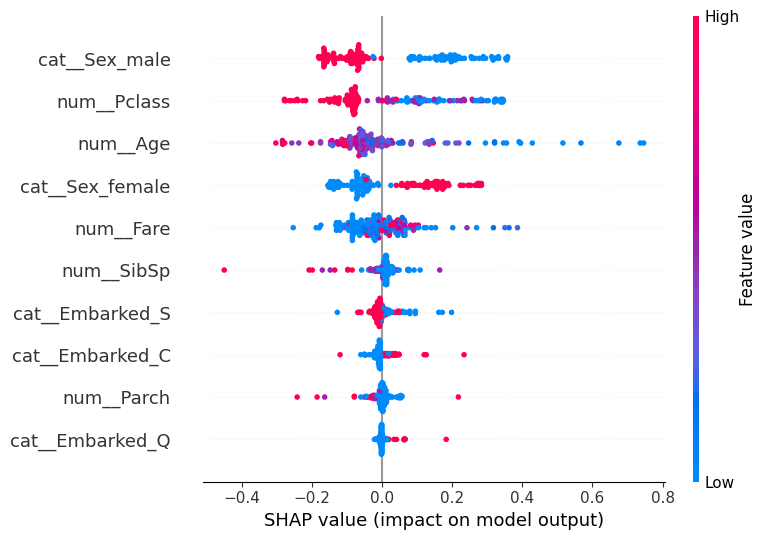

In [150]:
# ensamble methods


forest_explainer = shap.KernelExplainer(forest_model.predict, data=x_train)
shap_forest = forest_explainer.shap_values(x_test)

shap.summary_plot(shap_forest, x_test)

In [153]:
shapsss = forest_explainer(x_test)

  0%|          | 0/179 [00:00<?, ?it/s]

2025-05-15 19:18:20 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:18:23 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:18:23 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:18:23 - INFO: _kernel - phi = array([-0.1759001 ,  0.42839531, -0.01599173, -0.16408061, -0.10636258,
       -0.04584894, -0.02597367, -0.12008984, -0.018439  , -0.12789984])


  1%|          | 1/179 [00:03<09:23,  3.16s/it]

2025-05-15 19:18:23 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:18:26 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:18:26 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:18:26 - INFO: _kernel - phi = array([ 0.106284  , -0.0936625 ,  0.02927925, -0.18573546,  0.05747447,
       -0.13576222, -0.15357756, -0.00200029,  0.00158451,  0.00392478])


  1%|          | 2/179 [00:06<09:01,  3.06s/it]

2025-05-15 19:18:26 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:18:29 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:18:29 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:18:29 - INFO: _kernel - phi = array([ 0.17533267, -0.01774184,  0.        ,  0.01100515,  0.08134524,
        0.17815671,  0.20552763, -0.00974291, -0.00083941,  0.00476574])


  2%|▏         | 3/179 [00:08<08:40,  2.96s/it]

2025-05-15 19:18:29 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:18:32 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:18:32 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:18:32 - INFO: _kernel - phi = array([ 0.01516074,  0.73612783,  0.01360743, -0.00914203, -0.01014524,
       -0.03738742, -0.06592708, -0.00610565, -0.00089453, -0.00748506])


  2%|▏         | 4/179 [00:11<08:30,  2.92s/it]

2025-05-15 19:18:32 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:18:35 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:18:35 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:18:35 - INFO: _kernel - phi = array([ 0.04003589,  0.18729546,  0.03016263,  0.04858492,  0.26952359,
        0.0247871 , -0.00237482, -0.02085395,  0.0006153 ,  0.05003288])


  3%|▎         | 5/179 [00:15<09:13,  3.18s/it]

2025-05-15 19:18:35 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:18:39 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:18:39 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:18:39 - INFO: _kernel - phi = array([-0.07379448, -0.01238129,  0.01666165,  0.00536049, -0.179272  ,
       -0.04293238, -0.06776017, -0.00880317, -0.002916  , -0.00635367])


  3%|▎         | 6/179 [00:19<09:37,  3.34s/it]

2025-05-15 19:18:39 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:18:42 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:18:42 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:18:42 - INFO: _kernel - phi = array([-0.07672887, -0.05213349,  0.01344636, -0.00350455, -0.07863664,
       -0.06508828, -0.08799492, -0.0098532 , -0.00137774, -0.01031969])


  4%|▍         | 7/179 [00:22<09:51,  3.44s/it]

2025-05-15 19:18:43 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:18:45 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:18:45 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:18:45 - INFO: _kernel - phi = array([-0.10034332,  0.51556759,  0.03549804,  0.00843811,  0.02228743,
        0.05444868,  0.08239143,  0.01578161, -0.00229735, -0.00396324])


  4%|▍         | 8/179 [00:25<09:12,  3.23s/it]

2025-05-15 19:18:45 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:18:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:18:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:18:49 - INFO: _kernel - phi = array([-0.06860231, -0.07760779, -0.03440287, -0.00035391, -0.03359863,
       -0.04617052, -0.06503589, -0.02131264, -0.00415329, -0.02095316])


  5%|▌         | 9/179 [00:29<09:26,  3.33s/it]

2025-05-15 19:18:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:18:52 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:18:52 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:18:52 - INFO: _kernel - phi = array([-0.09421203, -0.11508717,  0.01283719,  0.00279506, -0.0415552 ,
       -0.07766074, -0.09570013,  0.0270393 , -0.00034778,  0.00970049])


  6%|▌         | 10/179 [00:32<09:24,  3.34s/it]

2025-05-15 19:18:52 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:18:55 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:18:55 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:18:55 - INFO: _kernel - phi = array([-0.0877965 , -0.01923879,  0.01182896, -0.00284633, -0.09536238,
       -0.07085897, -0.08816435, -0.00921504, -0.00550762, -0.00502998])


  6%|▌         | 11/179 [00:35<09:18,  3.33s/it]

2025-05-15 19:18:56 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:18:58 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:18:58 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:18:58 - INFO: _kernel - phi = array([-0.10036004, -0.031284  , -0.00271424, -0.01398531, -0.01846631,
       -0.0714726 , -0.09611312, -0.0133583 , -0.00289259, -0.0215445 ])


  7%|▋         | 12/179 [00:38<08:58,  3.22s/it]

2025-05-15 19:18:58 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:19:02 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:19:02 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:19:02 - INFO: _kernel - phi = array([-0.09708567, -0.05798221, -0.00751906, -0.01648943, -0.02326277,
       -0.05555277, -0.08237861, -0.01275582, -0.0034778 , -0.01568686])


  7%|▋         | 13/179 [00:41<08:51,  3.20s/it]

2025-05-15 19:19:02 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:19:05 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:19:05 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:19:05 - INFO: _kernel - phi = array([-0.07551387, -0.07644016,  0.01076389, -0.00040519, -0.12044264,
       -0.03754403, -0.05838572, -0.00778213, -0.00212681, -0.00431436])


  8%|▊         | 14/179 [00:45<09:02,  3.29s/it]

2025-05-15 19:19:05 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:19:08 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:19:08 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:19:08 - INFO: _kernel - phi = array([ 0.0842914 , -0.03147238,  0.02158072, -0.00077247, -0.0123746 ,
        0.2754481 ,  0.32309892, -0.01447744, -0.00430767, -0.01320559])


  8%|▊         | 15/179 [00:48<08:47,  3.21s/it]

2025-05-15 19:19:08 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:19:12 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:19:12 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:19:12 - INFO: _kernel - phi = array([-0.0907504 , -0.05988329,  0.01344971,  0.00246121, -0.03563236,
       -0.07362727, -0.10571161, -0.00744382, -0.00704922, -0.00800395])


  9%|▉         | 16/179 [00:51<08:54,  3.28s/it]

2025-05-15 19:19:12 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:19:15 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:19:15 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:19:15 - INFO: _kernel - phi = array([ 0.00215467,  0.18004392,  0.07260846,  0.04438815,  0.05039571,
       -0.06451534, -0.08151474,  0.23355515,  0.01927167,  0.17142133])


  9%|▉         | 17/179 [00:55<08:46,  3.25s/it]

2025-05-15 19:19:15 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:19:18 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:19:18 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:19:18 - INFO: _kernel - phi = array([-0.08590044, -0.10477751,  0.00801342, -0.00214576, -0.07184546,
       -0.03589876, -0.0594207 , -0.00839743, -0.0034477 , -0.00837068])


 10%|█         | 18/179 [00:58<08:50,  3.30s/it]

2025-05-15 19:19:18 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:19:21 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:19:21 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:19:21 - INFO: _kernel - phi = array([ 0.16168573, -0.02828719,  0.01009397,  0.00701077,  0.03723081,
        0.18718566,  0.22235821,  0.01955926, -0.00195459,  0.01292636])


 11%|█         | 19/179 [01:01<08:24,  3.15s/it]

2025-05-15 19:19:21 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:19:24 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:19:24 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:19:24 - INFO: _kernel - phi = array([ 0.10245619, -0.00389413,  0.02359049, -0.00474351, -0.04460273,
        0.27739934,  0.31229601, -0.01465913, -0.00505228, -0.01498127])


 11%|█         | 20/179 [01:04<08:27,  3.19s/it]

2025-05-15 19:19:24 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:19:27 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:19:27 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:19:27 - INFO: _kernel - phi = array([ 0.25930756,  0.00061976, -0.03366328,  0.00066992, -0.01169297,
        0.15311107,  0.20686474,  0.03085986, -0.0085128 ,  0.03024512])


 12%|█▏        | 21/179 [01:07<08:16,  3.14s/it]

2025-05-15 19:19:27 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:19:30 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:19:30 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:19:30 - INFO: _kernel - phi = array([ 0.10514535, -0.28396981,  0.00429263,  0.00242164,  0.05718354,
       -0.071841  , -0.16659087, -0.00929419, -0.00105003, -0.00848827])


 12%|█▏        | 22/179 [01:10<08:15,  3.15s/it]

2025-05-15 19:19:31 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:19:34 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:19:34 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:19:34 - INFO: _kernel - phi = array([-0.0834048 , -0.09231665,  0.00974161,  0.        , -0.08284133,
       -0.04346532, -0.06042794, -0.00821084, -0.00307998, -0.00818576])


 13%|█▎        | 23/179 [01:14<08:38,  3.33s/it]

2025-05-15 19:19:34 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:19:38 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:19:38 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:19:38 - INFO: _kernel - phi = array([-0.09536015, -0.10608781,  0.01318218,  0.00406969, -0.05788858,
       -0.06940877, -0.08915697,  0.02540463, -0.002187  ,  0.00524177])


 13%|█▎        | 24/179 [01:17<08:37,  3.34s/it]

2025-05-15 19:19:38 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:19:41 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:19:41 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:19:41 - INFO: _kernel - phi = array([-0.0808933 , -0.05009475,  0.01163445, -0.0081104 , -0.08485097,
       -0.051735  , -0.07304653, -0.01094781, -0.00521001, -0.01893671])


 14%|█▍        | 25/179 [01:21<08:43,  3.40s/it]

2025-05-15 19:19:41 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:19:44 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:19:44 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:19:44 - INFO: _kernel - phi = array([ 0.11922095, -0.30344826,  0.00217808,  0.00161461,  0.06458612,
       -0.07263131, -0.16469926, -0.00942237, -0.00108848, -0.00850109])


 15%|█▍        | 26/179 [01:24<08:34,  3.36s/it]

2025-05-15 19:19:44 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:19:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:19:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:19:49 - INFO: _kernel - phi = array([-0.08069043, -0.05486947,  0.01421493, -0.0014318 , -0.12942304,
       -0.04232265, -0.06021658, -0.01048076, -0.00165864, -0.00531256])


 15%|█▌        | 27/179 [01:28<09:08,  3.61s/it]

2025-05-15 19:19:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:19:53 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:19:53 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:19:53 - INFO: _kernel - phi = array([ 0.09930388, -0.17585663,  0.00843811,  0.00423299, -0.00052724,
       -0.14788546, -0.15755807,  0.00584649, -0.00112861, -0.00705647])


 16%|█▌        | 28/179 [01:33<09:37,  3.83s/it]

2025-05-15 19:19:53 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:19:57 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:19:57 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:19:57 - INFO: _kernel - phi = array([ 3.02832954e-01, -1.25666577e-01, -1.73332442e-04, -2.17089130e-02,
        5.05957954e-02,  1.90498484e-01,  1.87104289e-01,  3.62749688e-02,
       -1.97855359e-04,  8.24917514e-03])


 16%|█▌        | 29/179 [01:37<09:55,  3.97s/it]

2025-05-15 19:19:57 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:20:02 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:20:02 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:20:02 - INFO: _kernel - phi = array([-0.12483837,  0.13404338,  0.00691825,  0.05288033,  0.06509943,
        0.17253489,  0.16925941, -0.0052061 ,  0.06252285,  0.09459493])


 17%|█▋        | 30/179 [01:41<10:15,  4.13s/it]

2025-05-15 19:20:02 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:20:06 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:20:06 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:20:06 - INFO: _kernel - phi = array([-0.06852205, -0.20079365,  0.02675283,  0.02046939,  0.08936987,
       -0.10935605, -0.13325419, -0.00261113, -0.00141787,  0.00717184])


 17%|█▋        | 31/179 [01:46<10:15,  4.16s/it]

2025-05-15 19:20:06 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:20:09 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:20:09 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:20:09 - INFO: _kernel - phi = array([ 0.32492364, -0.00116818, -0.0856736 , -0.03214564, -0.00161628,
        0.27215144,  0.17748685, -0.0099329 , -0.00354133, -0.012675  ])


 18%|█▊        | 32/179 [01:49<09:22,  3.83s/it]

2025-05-15 19:20:09 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:20:12 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:20:12 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:20:12 - INFO: _kernel - phi = array([-0.01047129, -0.04453027,  0.00435616, -0.0086538 , -0.04672563,
       -0.09865848, -0.12414337, -0.02020911, -0.0031367 , -0.0200185 ])


 18%|█▊        | 33/179 [01:52<08:57,  3.68s/it]

2025-05-15 19:20:12 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:20:16 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:20:16 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:20:16 - INFO: _kernel - phi = array([ 0.03349719, -0.11761804,  0.02103899,  0.00074739,  0.01031133,
       -0.13789292, -0.17439473, -0.0075826 ,  0.00051498, -0.0008126 ])


 19%|█▉        | 34/179 [01:56<08:41,  3.60s/it]

2025-05-15 19:20:16 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:20:18 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:20:18 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:20:18 - INFO: _kernel - phi = array([ 0.34416856, -0.09380629,  0.00680901,  0.00693274,  0.02021357,
        0.15342652,  0.17350243,  0.01949293, -0.00069779, -0.0022327 ])


 20%|█▉        | 35/179 [01:58<07:59,  3.33s/it]

2025-05-15 19:20:18 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:20:21 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:20:21 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:20:21 - INFO: _kernel - phi = array([ 3.38392300e-01,  3.08765828e-04, -1.88274701e-02, -1.74764803e-02,
        2.02341939e-02,  1.36611602e-01,  1.88449148e-01, -7.09827002e-03,
       -3.24872927e-03, -9.53607098e-03])


 20%|██        | 36/179 [02:01<07:28,  3.14s/it]

2025-05-15 19:20:21 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:20:24 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:20:24 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:20:24 - INFO: _kernel - phi = array([-0.12483837,  0.13404338,  0.00691825,  0.05288033,  0.06509943,
        0.17253489,  0.16925941, -0.0052061 ,  0.06252285,  0.09459493])


 21%|██        | 37/179 [02:04<07:28,  3.16s/it]

2025-05-15 19:20:24 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:20:28 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:20:28 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:20:28 - INFO: _kernel - phi = array([-0.08387228, -0.05597969,  0.01336889, -0.00670869, -0.07685817,
       -0.0513365 , -0.06638298, -0.02138231, -0.00266854, -0.02037074])


 21%|██        | 38/179 [02:08<07:37,  3.24s/it]

2025-05-15 19:20:28 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:20:31 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:20:31 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:20:31 - INFO: _kernel - phi = array([-0.08136927, -0.06272795,  0.01007   , -0.00597467, -0.08501594,
       -0.04217552, -0.0614104 , -0.02180533, -0.00228732, -0.0194946 ])


 22%|██▏       | 39/179 [02:11<07:44,  3.32s/it]

2025-05-15 19:20:31 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:20:35 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:20:35 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:20:35 - INFO: _kernel - phi = array([-0.086353  , -0.09227026,  0.02010099,  0.00861423, -0.02349853,
       -0.12018793, -0.13875234,  0.03940443,  0.00271536,  0.01803605])


 22%|██▏       | 40/179 [02:14<07:42,  3.33s/it]

2025-05-15 19:20:35 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:20:38 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:20:38 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:20:38 - INFO: _kernel - phi = array([-0.08080078, -0.0556386 ,  0.01150961, -0.00542458, -0.07062154,
       -0.05066268, -0.07034232, -0.02183543, -0.00393593, -0.02443876])


 23%|██▎       | 41/179 [02:18<07:38,  3.32s/it]

2025-05-15 19:20:38 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:20:41 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:20:41 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:20:41 - INFO: _kernel - phi = array([-0.08172095, -0.05790474,  0.01373618,  0.00173611, -0.13062745,
       -0.03871333, -0.06453094, -0.00774423, -0.00178906, -0.0046326 ])


 23%|██▎       | 42/179 [02:21<07:45,  3.39s/it]

2025-05-15 19:20:41 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:20:44 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:20:44 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:20:44 - INFO: _kernel - phi = array([ 0.013924  , -0.0581065 , -0.00122615, -0.01171805, -0.00485275,
       -0.14716482, -0.1665251 ,  0.00794988, -0.00052223, -0.0039493 ])


 24%|██▍       | 43/179 [02:24<07:19,  3.23s/it]

2025-05-15 19:20:44 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:20:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:20:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:20:47 - INFO: _kernel - phi = array([-0.07448446, -0.0474563 , -0.0072978 ,  0.01381811, -0.02074583,
       -0.1230482 , -0.14052078, -0.00451445,  0.01712536,  0.01493334])


 25%|██▍       | 44/179 [02:27<07:13,  3.21s/it]

2025-05-15 19:20:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:20:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:20:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:20:51 - INFO: _kernel - phi = array([-0.08171761, -0.05486   ,  0.00975511, -0.00609395, -0.09040875,
       -0.04798466, -0.06984294, -0.00887618, -0.00485554, -0.01730649])


 25%|██▌       | 45/179 [02:31<07:25,  3.32s/it]

2025-05-15 19:20:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:20:54 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:20:54 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:20:54 - INFO: _kernel - phi = array([ 0.16341849, -0.00288033,  0.00768849,  0.00282125,  0.0227634 ,
        0.17206617,  0.21391174,  0.02556403, -0.00178348,  0.02423923])


 26%|██▌       | 46/179 [02:34<07:09,  3.23s/it]

2025-05-15 19:20:54 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:20:58 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:20:58 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:20:58 - INFO: _kernel - phi = array([ 0.27934724,  0.01808955,  0.02614533,  0.00553438, -0.04066513,
        0.17190175,  0.19507925, -0.01017199, -0.00431436, -0.01313704])


 26%|██▋       | 47/179 [02:37<07:16,  3.31s/it]

2025-05-15 19:20:58 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:01 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:01 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:01 - INFO: _kernel - phi = array([ 0.34618278,  0.0578217 ,  0.00821128,  0.01114901,  0.3619265 ,
       -0.06525214, -0.08241874, -0.00697566,  0.0008544 , -0.00369014])


 27%|██▋       | 48/179 [02:41<07:08,  3.27s/it]

2025-05-15 19:21:01 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:04 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:04 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:04 - INFO: _kernel - phi = array([-0.08905665, -0.06475722,  0.0092195 , -0.00098315, -0.05981976,
       -0.05658106, -0.07122626, -0.00888175, -0.00814272, -0.02196194])


 27%|██▋       | 49/179 [02:44<07:12,  3.33s/it]

2025-05-15 19:21:04 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:07 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:07 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:07 - INFO: _kernel - phi = array([ 2.13597958e-01, -6.97286874e-03, -3.39023765e-02,  3.20469948e-03,
        1.80020510e-04,  1.28393637e-01,  3.52494092e-01, -5.71774122e-03,
       -9.09688782e-03, -1.43715445e-02])


 28%|██▊       | 50/179 [02:47<07:01,  3.27s/it]

2025-05-15 19:21:07 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:11 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:11 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:11 - INFO: _kernel - phi = array([ 0.32584548,  0.01470316,  0.00297062,  0.0567895 ,  0.31726971,
       -0.07308443, -0.08910235,  0.02545089, -0.00054006,  0.04750647])


 28%|██▊       | 51/179 [02:50<06:56,  3.26s/it]

2025-05-15 19:21:11 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:14 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:14 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:14 - INFO: _kernel - phi = array([-0.07596141, -0.06105705,  0.01237293, -0.00561965, -0.05015215,
       -0.06203685, -0.08147071, -0.02332464, -0.00300963, -0.02193185])


 29%|██▉       | 52/179 [02:54<07:03,  3.33s/it]

2025-05-15 19:21:14 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:18 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:18 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:18 - INFO: _kernel - phi = array([-0.08412531, -0.06047463,  0.01452203, -0.00730449, -0.08970149,
       -0.05191223, -0.06805723, -0.01024222, -0.00241439, -0.01248105])


 30%|██▉       | 53/179 [02:57<07:05,  3.37s/it]

2025-05-15 19:21:18 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:21 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:21 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:21 - INFO: _kernel - phi = array([ 0.33964576, -0.05011648,  0.07318809,  0.05295668,  0.38591381,
       -0.06950854, -0.08711655, -0.00927245, -0.00138945, -0.00649189])


 30%|███       | 54/179 [03:01<06:58,  3.35s/it]

2025-05-15 19:21:21 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:24 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:24 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:24 - INFO: _kernel - phi = array([ 0.01080067,  0.01170858,  0.01127051,  0.00645677, -0.0964425 ,
       -0.1384419 , -0.16571083, -0.00739255,  0.00097144, -0.0054112 ])


 31%|███       | 55/179 [03:04<06:54,  3.34s/it]

2025-05-15 19:21:24 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:27 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:27 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:27 - INFO: _kernel - phi = array([-0.24975198, -0.1319868 , -0.03857121, -0.2426108 , -0.02782181,
        0.12500892,  0.15532092,  0.03668796, -0.01868089,  0.02021469])


 31%|███▏      | 56/179 [03:07<06:40,  3.25s/it]

2025-05-15 19:21:27 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:31 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:31 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:31 - INFO: _kernel - phi = array([-0.07842708, -0.05009308,  0.01085696, -0.00639825, -0.05766564,
       -0.06095784, -0.08082308, -0.02351302, -0.002916  , -0.02225399])


 32%|███▏      | 57/179 [03:10<06:41,  3.29s/it]

2025-05-15 19:21:31 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:34 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:34 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:34 - INFO: _kernel - phi = array([-0.08556046, -0.06219736,  0.00917937, -0.00187433, -0.08488998,
       -0.05256822, -0.0668439 , -0.00796382, -0.00494583, -0.01452648])


 32%|███▏      | 58/179 [03:14<06:50,  3.40s/it]

2025-05-15 19:21:34 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:37 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:37 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:37 - INFO: _kernel - phi = array([ 0.04182997, -0.07072521,  0.0041845 ,  0.00177345, -0.05595795,
       -0.0858904 , -0.18178393, -0.01179664, -0.00160346, -0.01222133])


 33%|███▎      | 59/179 [03:17<06:42,  3.36s/it]

2025-05-15 19:21:38 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:41 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:41 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:41 - INFO: _kernel - phi = array([-0.15079978, -0.00257714,  0.02840869, -0.01272795,  0.20134709,
        0.24781412,  0.28865146, -0.00315398,  0.04084682, -0.01000033])


 34%|███▎      | 60/179 [03:20<06:30,  3.28s/it]

2025-05-15 19:21:41 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:44 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:44 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:44 - INFO: _kernel - phi = array([-0.12260902,  0.00511637,  0.02652154,  0.02562533,  0.10342764,
        0.1770616 ,  0.20799893,  0.11964286,  0.00879481,  0.07622893])


 34%|███▍      | 61/179 [03:24<06:23,  3.25s/it]

2025-05-15 19:21:44 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:46 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:46 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:46 - INFO: _kernel - phi = array([ 0.14655509,  0.0257786 ,  0.01183732,  0.01176877,  0.09505529,
        0.14556358,  0.19708846, -0.00753522, -0.00055288,  0.00224998])


 35%|███▍      | 62/179 [03:26<05:59,  3.07s/it]

2025-05-15 19:21:46 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:50 - INFO: _kernel - phi = array([-0.07337536, -0.05500825,  0.01370664,  0.00184033, -0.12227183,
       -0.0506376 , -0.07403915, -0.00912308, -0.00152154, -0.00176119])


 35%|███▌      | 63/179 [03:29<05:57,  3.09s/it]

2025-05-15 19:21:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:52 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:52 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:52 - INFO: _kernel - phi = array([ 0.23480025, -0.03185638, -0.02237438, -0.02716136,  0.06133516,
        0.13138933,  0.31567739, -0.00710217, -0.00672318, -0.02017567])


 36%|███▌      | 64/179 [03:32<05:44,  3.00s/it]

2025-05-15 19:21:52 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:55 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:55 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:55 - INFO: _kernel - phi = array([-0.27879046, -0.04988797, -0.09808052, -0.07950943, -0.0097696 ,
        0.09072365,  0.10650916, -0.01784154, -0.00793261, -0.02761169])


 36%|███▋      | 65/179 [03:35<05:27,  2.88s/it]

2025-05-15 19:21:55 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:21:58 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:21:58 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:21:58 - INFO: _kernel - phi = array([ 0.10982812, -0.25778993,  0.00851726,  0.00744382,  0.06320559,
       -0.13802669, -0.1531367 , -0.00560962, -0.00100823, -0.00561463])


 37%|███▋      | 66/179 [03:38<05:32,  2.95s/it]

2025-05-15 19:21:58 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:22:01 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:22:01 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:22:01 - INFO: _kernel - phi = array([-0.07165262,  0.56698937,  0.03585139, -0.00427368, -0.00265182,
       -0.026667  , -0.05533373,  0.12579588,  0.00192951,  0.0578217 ])


 37%|███▋      | 67/179 [03:41<05:26,  2.92s/it]

2025-05-15 19:22:01 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:22:04 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:22:04 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:22:04 - INFO: _kernel - phi = array([ 0.27404974, -0.03526005, -0.0081065 ,  0.00471119,  0.05390862,
        0.15187712,  0.21792347, -0.00872904, -0.00642333, -0.01614221])


 38%|███▊      | 68/179 [03:44<05:24,  2.93s/it]

2025-05-15 19:22:04 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:22:07 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:22:07 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:22:07 - INFO: _kernel - phi = array([-0.00184535, -0.12818798, -0.01305455, -0.00124844, -0.04938748,
       -0.06876115, -0.08982689, -0.01103364, -0.00223995, -0.00660558])


 39%|███▊      | 69/179 [03:47<05:29,  2.99s/it]

2025-05-15 19:22:07 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:22:10 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:22:10 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:22:10 - INFO: _kernel - phi = array([-0.08100254, -0.04250602,  0.01405498, -0.00323368, -0.06424559,
       -0.07243178, -0.09877441, -0.01174926, -0.0013744 , -0.0109283 ])


 39%|███▉      | 70/179 [03:50<05:35,  3.07s/it]

2025-05-15 19:22:10 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:22:13 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:22:13 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:22:13 - INFO: _kernel - phi = array([ 0.23291979, -0.10930366,  0.01535525, -0.01990927, -0.04327069,
        0.25244226,  0.31999342, -0.0109963 , -0.00241551, -0.00700631])


 40%|███▉      | 71/179 [03:53<05:24,  3.00s/it]

2025-05-15 19:22:13 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:22:16 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:22:16 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:22:16 - INFO: _kernel - phi = array([-0.09945994, -0.03079856, -0.03717563, -0.00434223, -0.029374  ,
       -0.05425194, -0.07450843, -0.01390115, -0.00626338, -0.02211577])


 40%|████      | 72/179 [03:56<05:19,  2.99s/it]

2025-05-15 19:22:16 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:22:19 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:22:19 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:22:19 - INFO: _kernel - phi = array([-0.24039259, -0.08109952, -0.14821596, -0.04585841, -0.03801665,
        0.12002742,  0.15662955, -0.01259363, -0.02216259, -0.06050863])


 41%|████      | 73/179 [03:59<05:23,  3.06s/it]

2025-05-15 19:22:19 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:22:22 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:22:22 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:22:22 - INFO: _kernel - phi = array([-0.07678739, -0.04656735,  0.01284778, -0.00496422, -0.08509564,
       -0.06613329, -0.08584136, -0.00980304, -0.00168205, -0.00816446])


 41%|████▏     | 74/179 [04:02<05:23,  3.08s/it]

2025-05-15 19:22:22 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:22:25 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:22:25 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:22:25 - INFO: _kernel - phi = array([-0.1353509 ,  0.32079878,  0.01499186,  0.01475611, -0.0281746 ,
        0.12968722,  0.20301186,  0.04775838, -0.00784176,  0.06817204])


 42%|████▏     | 75/179 [04:05<05:17,  3.05s/it]

2025-05-15 19:22:25 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:22:28 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:22:28 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:22:28 - INFO: _kernel - phi = array([-0.12395109,  0.14335596, -0.19937912, -0.04344346, -0.03487605,
       -0.04130328, -0.04922363, -0.01174425, -0.00136381, -0.01026228])


 42%|████▏     | 76/179 [04:08<05:02,  2.94s/it]

2025-05-15 19:22:28 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:22:32 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:22:32 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:22:32 - INFO: _kernel - phi = array([-0.08266174, -0.08939662,  0.00802345, -0.00294164, -0.08531356,
       -0.04380072, -0.05933877, -0.00976012, -0.00176899, -0.0052323 ])


 43%|████▎     | 77/179 [04:12<05:31,  3.25s/it]

2025-05-15 19:22:32 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:22:37 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:22:37 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:22:37 - INFO: _kernel - phi = array([-0.24267489, -0.0892088 ,  0.03253745, -0.06108046, -0.17490804,
        0.0950107 ,  0.1134798 , -0.01891386, -0.00471174, -0.02172117])


 44%|████▎     | 78/179 [04:17<06:24,  3.81s/it]

2025-05-15 19:22:37 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:22:42 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:22:42 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:22:42 - INFO: _kernel - phi = array([-0.09900682, -0.14734316,  0.00593064, -0.01056715, -0.02173288,
       -0.06132959, -0.08819222,  0.02932718, -0.0004743 ,  0.02119728])


 44%|████▍     | 79/179 [04:22<06:44,  4.04s/it]

2025-05-15 19:22:42 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:22:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:22:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:22:47 - INFO: _kernel - phi = array([ 0.03219079, -0.06347702,  0.00484662, -0.00239823, -0.11763532,
       -0.08571652, -0.11442171, -0.01298544, -0.00038289, -0.0122113 ])


 45%|████▍     | 80/179 [04:27<07:21,  4.46s/it]

2025-05-15 19:22:47 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:22:52 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:22:52 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:22:52 - INFO: _kernel - phi = array([-0.21851982, -0.1429714 ,  0.03017601,  0.01524824, -0.18824795,
        0.1086956 ,  0.13373908, -0.04802256,  0.00107176, -0.06335997])


 45%|████▌     | 81/179 [04:32<07:34,  4.64s/it]

2025-05-15 19:22:52 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:22:57 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:22:57 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:22:57 - INFO: _kernel - phi = array([-0.08996901, -0.14335485,  0.01338004,  0.00245341, -0.04015628,
       -0.05748339, -0.07839029,  0.02126694,  0.00066212, -0.0005997 ])


 46%|████▌     | 82/179 [04:36<07:23,  4.57s/it]

2025-05-15 19:22:57 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:01 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:01 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:01 - INFO: _kernel - phi = array([-0.08556046, -0.06219736,  0.00917937, -0.00187433, -0.08488998,
       -0.05256822, -0.0668439 , -0.00796382, -0.00494583, -0.01452648])


 46%|████▋     | 83/179 [04:41<07:06,  4.44s/it]

2025-05-15 19:23:01 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:05 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:05 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:05 - INFO: _kernel - phi = array([-0.26486925, -0.0861256 , -0.17090857, -0.02526585,  0.02583768,
        0.10503444,  0.135522  , -0.01381198, -0.00802624, -0.06957765])


 47%|████▋     | 84/179 [04:44<06:44,  4.26s/it]

2025-05-15 19:23:05 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:08 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:08 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:08 - INFO: _kernel - phi = array([ 0.10282125, -0.01441056,  0.02446718,  0.00681403,  0.01971698,
        0.15452671,  0.35516542, -0.00988664, -0.00207776, -0.00932763])


 47%|████▋     | 85/179 [04:47<06:03,  3.87s/it]

2025-05-15 19:23:08 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:11 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:11 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:11 - INFO: _kernel - phi = array([-0.07685482, -0.03507613,  0.00596854,  0.00930255, -0.02495708,
       -0.12398899, -0.13889836, -0.00754358,  0.00947476,  0.01038211])


 48%|████▊     | 86/179 [04:51<05:45,  3.72s/it]

2025-05-15 19:23:11 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:14 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:14 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:14 - INFO: _kernel - phi = array([-0.1319829 ,  0.0832057 ,  0.00303081,  0.04715033,  0.04332475,
        0.28312377,  0.16283385, -0.00699683,  0.06535358,  0.07876594])


 49%|████▊     | 87/179 [04:54<05:26,  3.55s/it]

2025-05-15 19:23:14 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:17 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:17 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:17 - INFO: _kernel - phi = array([ 0.1197259 , -0.28460462,  0.00366116,  0.00208779,  0.03534923,
       -0.07282025, -0.16518247, -0.00863318, -0.00067048, -0.00110409])


 49%|████▉     | 88/179 [04:57<05:11,  3.42s/it]

2025-05-15 19:23:17 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:20 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:20 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:20 - INFO: _kernel - phi = array([ 0.02001739, -0.03399378, -0.01932183, -0.00202648, -0.03767556,
       -0.1495218 , -0.16628377,  0.01548121, -0.00256822,  0.00370185])


 50%|████▉     | 89/179 [05:00<04:58,  3.32s/it]

2025-05-15 19:23:20 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:24 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:24 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:24 - INFO: _kernel - phi = array([-0.08556046, -0.06219736,  0.00917937, -0.00187433, -0.08488998,
       -0.05256822, -0.0668439 , -0.00796382, -0.00494583, -0.01452648])


 50%|█████     | 90/179 [05:04<05:02,  3.40s/it]

2025-05-15 19:23:24 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:27 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:27 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:27 - INFO: _kernel - phi = array([ 0.29698591, -0.04776897,  0.01354724, -0.00394373,  0.03942839,
        0.15737582,  0.20124788, -0.0125875 , -0.00663512, -0.00984094])


 51%|█████     | 91/179 [05:07<04:44,  3.23s/it]

2025-05-15 19:23:27 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:30 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:30 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:30 - INFO: _kernel - phi = array([ 0.2237092 , -0.01467028, -0.13537654,  0.0036567 , -0.00960407,
        0.27129314,  0.3163841 , -0.0060488 , -0.00903279, -0.01250167])


 51%|█████▏    | 92/179 [05:09<04:32,  3.13s/it]

2025-05-15 19:23:30 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:33 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:33 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:33 - INFO: _kernel - phi = array([ 0.10769462, -0.23791968,  0.00967429,  0.00768961,  0.06254347,
       -0.13827749, -0.15444422, -0.01398977, -0.00119048, -0.01397138])


 52%|█████▏    | 93/179 [05:13<04:32,  3.17s/it]

2025-05-15 19:23:33 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:35 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:35 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:35 - INFO: _kernel - phi = array([ 3.22045546e-01, -1.07017456e-01, -1.88937935e-03,  2.72538791e-04,
        4.51210540e-02,  1.45980471e-01,  1.71122592e-01,  3.55353799e-02,
       -3.33678884e-03,  1.99750312e-02])


 53%|█████▎    | 94/179 [05:15<04:15,  3.00s/it]

2025-05-15 19:23:36 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:38 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:38 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:38 - INFO: _kernel - phi = array([ 0.07012997, -0.11066858,  0.00930199, -0.01748373,  0.01074828,
       -0.13312712, -0.16497068, -0.01756287, -0.00087056, -0.01768771])


 53%|█████▎    | 95/179 [05:18<04:10,  2.98s/it]

2025-05-15 19:23:38 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:42 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:42 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:42 - INFO: _kernel - phi = array([ 0.09462446, -0.20392422,  0.00271034,  0.00151819,  0.0195091 ,
       -0.07466727, -0.17156233, -0.02106407, -0.00098649, -0.01834872])


 54%|█████▎    | 96/179 [05:21<04:11,  3.03s/it]

2025-05-15 19:23:42 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:44 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:44 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:44 - INFO: _kernel - phi = array([-0.14793952,  0.35467719, -0.45060471, -0.02319366, -0.01175874,
       -0.03733224, -0.04145544, -0.0085663 , -0.00111746, -0.00490012])


 54%|█████▍    | 97/179 [05:24<03:58,  2.91s/it]

2025-05-15 19:23:44 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:47 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:47 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:47 - INFO: _kernel - phi = array([-0.14207074, -0.04239344,  0.01886425, -0.00779271, -0.04422764,
       -0.07233425, -0.10184702,  0.01731429, -0.00359818,  0.00589442])


 55%|█████▍    | 98/179 [05:27<04:05,  3.03s/it]

2025-05-15 19:23:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:51 - INFO: _kernel - phi = array([-0.07734863, -0.03462357,  0.00517211,  0.00901106, -0.02468678,
       -0.12587725, -0.13743256, -0.00577738,  0.00906289,  0.0103091 ])


 55%|█████▌    | 99/179 [05:31<04:12,  3.16s/it]

2025-05-15 19:23:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:54 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:54 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:54 - INFO: _kernel - phi = array([-7.15957731e-02,  6.75307651e-01,  4.39021536e-02,  1.16756956e-02,
        4.66275415e-02, -2.44499064e-02, -4.59838149e-02, -7.01857054e-03,
       -8.23189763e-04,  1.67201712e-04])


 56%|█████▌    | 100/179 [05:34<04:05,  3.10s/it]

2025-05-15 19:23:54 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:23:57 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:23:57 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:23:57 - INFO: _kernel - phi = array([ 0.10514535, -0.28396981,  0.00429263,  0.00242164,  0.05718354,
       -0.071841  , -0.16659087, -0.00929419, -0.00105003, -0.00848827])


 56%|█████▋    | 101/179 [05:37<04:01,  3.10s/it]

2025-05-15 19:23:57 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:00 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:00 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:00 - INFO: _kernel - phi = array([-0.12483837,  0.13404338,  0.00691825,  0.05288033,  0.06509943,
        0.17253489,  0.16925941, -0.0052061 ,  0.06252285,  0.09459493])


 57%|█████▋    | 102/179 [05:40<03:59,  3.11s/it]

2025-05-15 19:24:00 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:03 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:03 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:03 - INFO: _kernel - phi = array([ 0.33798321, -0.07885734, -0.02016118,  0.00158006,  0.0575408 ,
        0.15618646,  0.19457765, -0.00819734, -0.0032426 , -0.00960072])


 58%|█████▊    | 103/179 [05:43<03:44,  2.96s/it]

2025-05-15 19:24:03 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:06 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:06 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:06 - INFO: _kernel - phi = array([-0.01101859, -0.05021402,  0.01236289, -0.00830825, -0.07452348,
       -0.08532136, -0.11894061, -0.01700943, -0.00226893, -0.01694924])


 58%|█████▊    | 104/179 [05:46<03:45,  3.01s/it]

2025-05-15 19:24:06 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:09 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:09 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:09 - INFO: _kernel - phi = array([ 4.46824282e-02, -6.93140271e-02, -1.24286606e-04, -1.24955413e-03,
       -1.30329276e-01, -8.55978019e-02, -1.08974273e-01, -1.36107767e-02,
       -4.58132691e-04, -7.21531122e-03])


 59%|█████▊    | 105/179 [05:49<03:40,  2.97s/it]

2025-05-15 19:24:09 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:12 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:12 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:12 - INFO: _kernel - phi = array([-0.0758923 , -0.0696306 ,  0.01443007,  0.00404851, -0.12190956,
       -0.04209415, -0.06956371, -0.0075904 , -0.00207665, -0.00191223])


 59%|█████▉    | 106/179 [05:52<03:47,  3.12s/it]

2025-05-15 19:24:12 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:15 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:15 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:15 - INFO: _kernel - phi = array([ 0.01415753, -0.11379693,  0.00253199, -0.0085167 , -0.00789471,
       -0.06907716, -0.16926944, -0.01057941, -0.00143682, -0.00830937])


 60%|█████▉    | 107/179 [05:55<03:38,  3.04s/it]

2025-05-15 19:24:15 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:18 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:18 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:18 - INFO: _kernel - phi = array([ 0.09325341, -0.04342897,  0.03017322,  0.00121221, -0.02555344,
        0.27396837,  0.33155431, -0.0106814 , -0.00409923, -0.01858949])


 60%|██████    | 108/179 [05:58<03:31,  2.98s/it]

2025-05-15 19:24:18 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:21 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:21 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:21 - INFO: _kernel - phi = array([-0.12876204,  0.1423221 ,  0.00064707,  0.02925863, -0.03501371,
        0.1217797 ,  0.28671248, -0.02086677,  0.03379815,  0.19793339])


 61%|██████    | 109/179 [06:01<03:29,  3.00s/it]

2025-05-15 19:24:21 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:24 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:24 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:24 - INFO: _kernel - phi = array([ 0.07157961, -0.09254726,  0.00200698,  0.0040669 , -0.06555756,
       -0.14733425, -0.1615163 ,  0.01526106, -0.00187099,  0.0037208 ])


 61%|██████▏   | 110/179 [06:04<03:24,  2.97s/it]

2025-05-15 19:24:24 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:27 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:27 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:27 - INFO: _kernel - phi = array([ 0.28191602,  0.08194779,  0.1641174 ,  0.00345829,  0.24182774,
       -0.07024255, -0.08641598,  0.00127631, -0.00056291,  0.01048689])


 62%|██████▏   | 111/179 [06:07<03:19,  2.94s/it]

2025-05-15 19:24:27 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:30 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:30 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:30 - INFO: _kernel - phi = array([ 0.10871957, -0.0621238 ,  0.01675696,  0.00844369,  0.04430344,
        0.15537888,  0.35742041, -0.0058933 , -0.00143515,  0.0062383 ])


 63%|██████▎   | 112/179 [06:09<03:16,  2.93s/it]

2025-05-15 19:24:30 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:33 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:33 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:33 - INFO: _kernel - phi = array([ 0.32036684, -0.0274796 ,  0.00704755,  0.05485052,  0.3500117 ,
       -0.07100221, -0.08994449,  0.02703317,  0.0138443 ,  0.04308119])


 63%|██████▎   | 113/179 [06:13<03:19,  3.02s/it]

2025-05-15 19:24:33 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:36 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:36 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:36 - INFO: _kernel - phi = array([-0.06713985, -0.10310995,  0.01199839, -0.00103331, -0.09450575,
       -0.04205959, -0.05713784, -0.00767456, -0.00331059, -0.00821796])


 64%|██████▎   | 114/179 [06:16<03:19,  3.07s/it]

2025-05-15 19:24:36 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:39 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:39 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:39 - INFO: _kernel - phi = array([-0.04257903, -0.06701054,  0.00214408, -0.02400626,  0.00934379,
       -0.05844982, -0.17964263, -0.00766174, -0.00134653, -0.00298232])


 64%|██████▍   | 115/179 [06:19<03:14,  3.04s/it]

2025-05-15 19:24:39 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:42 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:42 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:42 - INFO: _kernel - phi = array([ 0.03082809, -0.04377564,  0.01115681, -0.00205045, -0.05784901,
       -0.14900738, -0.16655687,  0.00994293, -0.00213015, -0.00274935])


 65%|██████▍   | 116/179 [06:22<03:12,  3.06s/it]

2025-05-15 19:24:42 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:45 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:45 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:45 - INFO: _kernel - phi = array([ 0.10414772,  0.29465902,  0.0244644 , -0.00446317,  0.03267735,
        0.08434936,  0.10532983, -0.00548422, -0.00173946, -0.00613184])


 65%|██████▌   | 117/179 [06:24<03:00,  2.91s/it]

2025-05-15 19:24:45 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:48 - INFO: _kernel - phi = array([ 0.19397461,  0.1458874 ,  0.07646692,  0.0400972 ,  0.15217585,
       -0.01029071, -0.03856953,  0.01833255,  0.01333768,  0.03639703])


 66%|██████▌   | 118/179 [06:28<03:00,  2.96s/it]

2025-05-15 19:24:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:50 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:50 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:50 - INFO: _kernel - phi = array([-0.09238508,  0.39463171,  0.0027527 ,  0.00927356,  0.04883182,
        0.07218488,  0.09054196,  0.03885656, -0.00246177,  0.06558264])


 66%|██████▋   | 119/179 [06:30<02:51,  2.86s/it]

2025-05-15 19:24:50 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:54 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:54 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:54 - INFO: _kernel - phi = array([-0.086353  , -0.09227026,  0.02010099,  0.00861423, -0.02349853,
       -0.12018793, -0.13875234,  0.03940443,  0.00271536,  0.01803605])


 67%|██████▋   | 120/179 [06:33<02:55,  2.97s/it]

2025-05-15 19:24:54 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:24:57 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:24:57 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:24:57 - INFO: _kernel - phi = array([ 0.11449304, -0.05941847,  0.02699137,  0.00208668,  0.04937801,
        0.14335875,  0.35768459, -0.00628846, -0.00238095,  0.00190443])


 68%|██████▊   | 121/179 [06:36<02:51,  2.96s/it]

2025-05-15 19:24:57 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:00 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:00 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:00 - INFO: _kernel - phi = array([-0.09813514, -0.04709348, -0.00104111, -0.01886147, -0.02147483,
       -0.0700369 , -0.09129325, -0.01223638, -0.00240659, -0.00961187])


 68%|██████▊   | 122/179 [06:39<02:49,  2.98s/it]

2025-05-15 19:25:00 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:02 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:02 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:02 - INFO: _kernel - phi = array([ 0.07813057, -0.14719213,  0.0019936 , -0.01932294,  0.00542458,
       -0.14270945, -0.15795824,  0.00940733, -0.00017779,  0.00021346])


 69%|██████▊   | 123/179 [06:42<02:43,  2.92s/it]

2025-05-15 19:25:02 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:05 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:05 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:05 - INFO: _kernel - phi = array([ 0.06719837, -0.04297586,  0.01281434, -0.04161985, -0.09176866,
       -0.1426682 , -0.1650632 ,  0.01787386, -0.00073402,  0.01475221])


 69%|██████▉   | 124/179 [06:45<02:39,  2.91s/it]

2025-05-15 19:25:05 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:08 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:08 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:08 - INFO: _kernel - phi = array([ 0.15597356,  0.0472774 ,  0.00892969, -0.02902343,  0.05907515,
        0.15375312,  0.17899222,  0.0313715 , -0.00051387,  0.02197365])


 70%|██████▉   | 125/179 [06:48<02:30,  2.79s/it]

2025-05-15 19:25:08 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:11 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:11 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:11 - INFO: _kernel - phi = array([-0.10553159, -0.0530754 , -0.01326801, -0.00450999, -0.06201066,
       -0.05238151, -0.06991094, -0.00125624, -0.00580357, -0.00444311])


 70%|███████   | 126/179 [06:51<02:33,  2.89s/it]

2025-05-15 19:25:11 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:14 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:14 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:14 - INFO: _kernel - phi = array([-0.13052992,  0.12818631,  0.02873138, -0.00380941,  0.12603777,
        0.2446724 ,  0.27650426, -0.02045936, -0.00039961, -0.02112482])


 71%|███████   | 127/179 [06:54<02:33,  2.95s/it]

2025-05-15 19:25:14 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:17 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:17 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:17 - INFO: _kernel - phi = array([-0.08876182, -0.0562996 ,  0.00834392, -0.00260946, -0.07656947,
       -0.05528134, -0.06670457, -0.00898319, -0.00814941, -0.01717607])


 72%|███████▏  | 128/179 [06:57<02:37,  3.09s/it]

2025-05-15 19:25:17 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:20 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:20 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:21 - INFO: _kernel - phi = array([-0.27507134, -0.12487906,  0.01385824, -0.0018721 , -0.08360531,
        0.05578908,  0.09221565, -0.01559435, -0.00747392, -0.0255579 ])


 72%|███████▏  | 129/179 [07:00<02:35,  3.11s/it]

2025-05-15 19:25:21 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:24 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:24 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:24 - INFO: _kernel - phi = array([-0.07758605, -0.04624242,  0.01690298, -0.00428649, -0.05763053,
       -0.07114879, -0.08646948, -0.02087625, -0.00231742, -0.02253656])


 73%|███████▎  | 130/179 [07:04<02:36,  3.18s/it]

2025-05-15 19:25:24 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:27 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:27 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:27 - INFO: _kernel - phi = array([-0.14885801,  0.21019262,  0.07623729, -0.01361858,  0.07825207,
        0.22474084,  0.26009564, -0.01421883, -0.00908407, -0.03592998])


 73%|███████▎  | 131/179 [07:07<02:33,  3.20s/it]

2025-05-15 19:25:27 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:30 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:30 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:30 - INFO: _kernel - phi = array([-0.16664772,  0.3206182 ,  0.10826367,  0.21730092,  0.0209108 ,
        0.072429  ,  0.08158162, -0.01623752, -0.00761158, -0.0027984 ])


 74%|███████▎  | 132/179 [07:10<02:26,  3.12s/it]

2025-05-15 19:25:30 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:33 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:33 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:33 - INFO: _kernel - phi = array([-0.15633917,  0.24642801, -0.01053427,  0.02220049, -0.13207486,
        0.08748439,  0.25533819, -0.02867565,  0.1826322 ,  0.16134965])


 74%|███████▍  | 133/179 [07:13<02:22,  3.09s/it]

2025-05-15 19:25:33 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:36 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:36 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:36 - INFO: _kernel - phi = array([ 0.05473961, -0.07706383,  0.00654372,  0.00194901, -0.04282426,
       -0.15504671, -0.16481129,  0.00847155, -0.0012908 , -0.00285803])


 75%|███████▍  | 134/179 [07:16<02:17,  3.06s/it]

2025-05-15 19:25:36 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:39 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:39 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:39 - INFO: _kernel - phi = array([ 0.1347133 ,  0.02444712,  0.02024367,  0.01244538,  0.09226246,
        0.15667859,  0.19747916, -0.00845706, -0.0022249 ,  0.00022126])


 75%|███████▌  | 135/179 [07:19<02:09,  2.95s/it]

2025-05-15 19:25:39 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:42 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:42 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:42 - INFO: _kernel - phi = array([-0.0834048 , -0.09231665,  0.00974161,  0.        , -0.08284133,
       -0.04346532, -0.06042794, -0.00821084, -0.00307998, -0.00818576])


 76%|███████▌  | 136/179 [07:22<02:14,  3.13s/it]

2025-05-15 19:25:42 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:45 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:45 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:45 - INFO: _kernel - phi = array([ 1.26284109e-01, -2.49130551e-03, -2.93857009e-02, -3.22699304e-04,
       -1.31487426e-02,  1.58420278e-01,  3.32422084e-01,  1.55079588e-02,
       -4.78419832e-03,  4.53072053e-02])


 77%|███████▋  | 137/179 [07:25<02:06,  3.01s/it]

2025-05-15 19:25:45 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:48 - INFO: _kernel - phi = array([-0.08556046, -0.06219736,  0.00917937, -0.00187433, -0.08488998,
       -0.05256822, -0.0668439 , -0.00796382, -0.00494583, -0.01452648])


 77%|███████▋  | 138/179 [07:28<02:08,  3.14s/it]

2025-05-15 19:25:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:51 - INFO: _kernel - phi = array([-0.10490235, -0.07642289, -0.00340423, -0.05138945, -0.02545479,
       -0.04234383, -0.05108681, -0.00938615, -0.00196518, -0.00583534])


 78%|███████▊  | 139/179 [07:31<02:02,  3.06s/it]

2025-05-15 19:25:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:54 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:54 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:54 - INFO: _kernel - phi = array([ 0.25664515, -0.06445905,  0.02587001,  0.00407861,  0.04682205,
        0.1612432 ,  0.20881878, -0.00338862, -0.00327047, -0.00455067])


 78%|███████▊  | 140/179 [07:34<01:58,  3.03s/it]

2025-05-15 19:25:54 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:25:58 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:25:58 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:25:58 - INFO: _kernel - phi = array([-0.1501633 ,  0.21888933,  0.09093488, -0.00500379,  0.05971498,
        0.22275337,  0.25376761, -0.01383706, -0.01178772, -0.03745931])


 79%|███████▉  | 141/179 [07:37<01:57,  3.09s/it]

2025-05-15 19:25:58 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:00 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:00 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:00 - INFO: _kernel - phi = array([ 0.26720729,  0.00780721,  0.01624588,  0.00250691,  0.03532025,
        0.13378032,  0.18978788, -0.007256  , -0.00493914, -0.0126516 ])


 79%|███████▉  | 142/179 [07:40<01:49,  2.97s/it]

2025-05-15 19:26:00 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:03 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:03 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:03 - INFO: _kernel - phi = array([ 0.14857488,  0.01608759, -0.01298043, -0.02514268,  0.00608726,
        0.16869594,  0.23464029,  0.04849296, -0.00157783,  0.044931  ])


 80%|███████▉  | 143/179 [07:43<01:42,  2.85s/it]

2025-05-15 19:26:03 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:06 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:06 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:06 - INFO: _kernel - phi = array([ 0.07119839, -0.04231987, -0.05870062,  0.0032543 , -0.0662782 ,
       -0.14249041, -0.16397583,  0.01367933, -0.00034276,  0.01378467])


 80%|████████  | 144/179 [07:46<01:40,  2.87s/it]

2025-05-15 19:26:06 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:09 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:09 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:09 - INFO: _kernel - phi = array([-0.13532916,  0.12267478,  0.02390706, -0.0066825 ,  0.11978219,
        0.23173879,  0.26433476, -0.03697276, -0.00252809,  0.04688392])


 81%|████████  | 145/179 [07:49<01:40,  2.95s/it]

2025-05-15 19:26:09 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:11 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:11 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:11 - INFO: _kernel - phi = array([ 0.19069578, -0.01260144, -0.01368992,  0.00370408,  0.04582051,
        0.17768916,  0.2033145 ,  0.02305266, -0.00198747,  0.01181113])


 82%|████████▏ | 146/179 [07:51<01:34,  2.86s/it]

2025-05-15 19:26:12 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:15 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:15 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:15 - INFO: _kernel - phi = array([-0.07853799, -0.02937734,  0.01834203, -0.00014881, -0.10676833,
       -0.06560828, -0.08444188, -0.00752408, -0.00498596, -0.01314038])


 82%|████████▏ | 147/179 [07:55<01:35,  2.99s/it]

2025-05-15 19:26:15 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:18 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:18 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:18 - INFO: _kernel - phi = array([-0.07729735, -0.02769362,  0.00777488,  0.00202983, -0.03214119,
       -0.0762607 , -0.10326043, -0.06106652, -0.00277889, -0.00149701])


 83%|████████▎ | 148/179 [07:58<01:34,  3.05s/it]

2025-05-15 19:26:18 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:21 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:21 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:21 - INFO: _kernel - phi = array([ 0.32036963,  0.05177512, -0.01351547, -0.0083991 ,  0.02330736,
        0.12311174,  0.15090066, -0.00694166, -0.00307094, -0.00972835])


 83%|████████▎ | 149/179 [08:01<01:29,  2.99s/it]

2025-05-15 19:26:21 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:24 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:24 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:24 - INFO: _kernel - phi = array([-0.22700419,  0.01607867,  0.03057339,  0.01244705, -0.25387852,
        0.04047842,  0.07668428, -0.04814016, -0.00713951, -0.01229044])


 84%|████████▍ | 150/179 [08:04<01:29,  3.09s/it]

2025-05-15 19:26:24 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:27 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:27 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:27 - INFO: _kernel - phi = array([ 0.08880194,  0.34609695,  0.01144774, -0.00706316,  0.01118357,
        0.07140461,  0.12306659, -0.0051147 , -0.00202871, -0.00998584])


 84%|████████▍ | 151/179 [08:07<01:24,  3.01s/it]

2025-05-15 19:26:27 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:30 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:30 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:30 - INFO: _kernel - phi = array([-0.25953607,  0.05934769, -0.208471  , -0.02601882, -0.11440666,
        0.1180589 ,  0.15015996, -0.01709693, -0.00692382, -0.06730426])


 85%|████████▍ | 152/179 [08:10<01:19,  2.93s/it]

2025-05-15 19:26:30 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:33 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:33 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:33 - INFO: _kernel - phi = array([-0.08260266,  0.39052301,  0.04844168,  0.0011236 ,  0.13995619,
        0.0635216 ,  0.08006788, -0.00274545, -0.0032086 , -0.00726826])


 85%|████████▌ | 153/179 [08:13<01:18,  3.01s/it]

2025-05-15 19:26:33 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:36 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:36 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:36 - INFO: _kernel - phi = array([ 0.28657482, -0.07558242, -0.01982065,  0.01846018,  0.06362805,
        0.15842306,  0.21130897, -0.00783953, -0.0011732 , -0.0061703 ])


 86%|████████▌ | 154/179 [08:15<01:13,  2.93s/it]

2025-05-15 19:26:36 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:39 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:39 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:39 - INFO: _kernel - phi = array([ 0.02562032, -0.04224184, -0.00408307,  0.0054792 , -0.02852461,
       -0.13191212, -0.17399345, -0.007742  , -0.0043818 , -0.01041165])


 87%|████████▋ | 155/179 [08:19<01:12,  3.02s/it]

2025-05-15 19:26:39 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:42 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:42 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:42 - INFO: _kernel - phi = array([ 0.01482745, -0.1415931 ,  0.01640082, -0.00981808, -0.01166399,
       -0.08518927, -0.12789092, -0.01419375, -0.00032939, -0.01274077])


 87%|████████▋ | 156/179 [08:22<01:11,  3.12s/it]

2025-05-15 19:26:42 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:45 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:45 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:45 - INFO: _kernel - phi = array([-6.81720394e-02,  7.46031746e-01,  7.54375111e-02, -3.10415552e-02,
       -6.40822855e-02, -1.24871812e-02, -2.32616595e-02,  6.25613073e-03,
       -1.31587747e-03,  4.44199215e-04])


 88%|████████▊ | 157/179 [08:25<01:07,  3.05s/it]

2025-05-15 19:26:45 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:48 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:48 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:48 - INFO: _kernel - phi = array([ 0.09930388, -0.17585663,  0.00843811,  0.00423299, -0.00052724,
       -0.14788546, -0.15755807,  0.00584649, -0.00112861, -0.00705647])


 88%|████████▊ | 158/179 [08:28<01:05,  3.10s/it]

2025-05-15 19:26:48 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:51 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:51 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:51 - INFO: _kernel - phi = array([ 0.16334158, -0.02082274,  0.00975343,  0.00656322,  0.03102149,
        0.18763599,  0.21735108,  0.02044431, -0.00170992,  0.01423054])


 89%|████████▉ | 159/179 [08:31<01:00,  3.02s/it]

2025-05-15 19:26:51 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:55 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:55 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:55 - INFO: _kernel - phi = array([-0.08318675, -0.02893816,  0.01301108, -0.00763833, -0.08224708,
       -0.05850109, -0.07460095, -0.0221899 , -0.00324706, -0.02465278])


 89%|████████▉ | 160/179 [08:34<00:59,  3.15s/it]

2025-05-15 19:26:55 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:26:57 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:26:57 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:26:57 - INFO: _kernel - phi = array([ 0.34405264, -0.06659811, -0.00295613, -0.02370084,  0.06849251,
        0.14482845,  0.18186865, -0.00789471, -0.0021608 , -0.00812266])


 90%|████████▉ | 161/179 [08:37<00:54,  3.03s/it]

2025-05-15 19:26:57 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:27:00 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:27:00 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:27:00 - INFO: _kernel - phi = array([ 0.22603442, -0.05698624,  0.01497068, -0.00750123, -0.07427657,
        0.26448747,  0.29515895, -0.01654851, -0.00259999, -0.01493   ])


 91%|█████████ | 162/179 [08:40<00:51,  3.04s/it]

2025-05-15 19:27:01 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:27:04 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:27:04 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:27:04 - INFO: _kernel - phi = array([-0.07386247, -0.06690521,  0.01348538, -0.00456071, -0.06216671,
       -0.04216103, -0.06945169, -0.05099931, -0.00314005, -0.01242922])


 91%|█████████ | 163/179 [08:44<00:51,  3.22s/it]

2025-05-15 19:27:04 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:27:08 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:27:08 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:27:08 - INFO: _kernel - phi = array([-0.07733358, -0.03469045,  0.0051905 ,  0.00897762, -0.02456639,
       -0.12588394, -0.13749944, -0.00577738,  0.00914984,  0.01024222])


 92%|█████████▏| 164/179 [08:47<00:49,  3.33s/it]

2025-05-15 19:27:08 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:27:11 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:27:11 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:27:11 - INFO: _kernel - phi = array([-0.0768225 , -0.04908541,  0.00900548, -0.00559457, -0.0714804 ,
       -0.05263175, -0.07664694, -0.02124298, -0.00339419, -0.02429775])


 92%|█████████▏| 165/179 [08:51<00:47,  3.39s/it]

2025-05-15 19:27:11 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:27:15 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:27:15 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:27:15 - INFO: _kernel - phi = array([-0.08165909, -0.11350432,  0.01128166, -0.00089899, -0.08401663,
       -0.03356686, -0.05225165, -0.00933431, -0.00238764, -0.00585317])


 93%|█████████▎| 166/179 [08:55<00:45,  3.51s/it]

2025-05-15 19:27:15 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:27:19 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:27:19 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:27:19 - INFO: _kernel - phi = array([-0.0834048 , -0.09231665,  0.00974161,  0.        , -0.08284133,
       -0.04346532, -0.06042794, -0.00821084, -0.00307998, -0.00818576])


 93%|█████████▎| 167/179 [08:59<00:42,  3.57s/it]

2025-05-15 19:27:19 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:27:22 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:27:22 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:27:22 - INFO: _kernel - phi = array([ 0.07020187, -0.09934234,  0.0017545 ,  0.00238318, -0.033714  ,
       -0.15220316, -0.16258137, -0.00042915, -0.00103163,  0.00277109])


 94%|█████████▍| 168/179 [09:02<00:38,  3.51s/it]

2025-05-15 19:27:22 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:27:26 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:27:26 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:27:26 - INFO: _kernel - phi = array([ 0.20273208,  0.03037888, -0.00987326,  0.01114734,  0.10321529,
        0.12811831,  0.17692115, -0.00847657, -0.00206884, -0.00428538])


 94%|█████████▍| 169/179 [09:06<00:36,  3.67s/it]

2025-05-15 19:27:26 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:27:30 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:27:30 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:27:30 - INFO: _kernel - phi = array([-0.0942817 ,  0.39421482,  0.00806247,  0.00444757,  0.05586209,
        0.07789259,  0.08965189,  0.0365737 , -0.00261448,  0.05800004])


 95%|█████████▍| 170/179 [09:10<00:32,  3.66s/it]

2025-05-15 19:27:30 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:27:34 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:27:34 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:27:34 - INFO: _kernel - phi = array([-0.07962257, -0.07136782,  0.0067739 ,  0.00568542, -0.06394072,
       -0.05449717, -0.07023754, -0.01220127, -0.01437043, -0.01841281])


 96%|█████████▌| 171/179 [09:14<00:30,  3.87s/it]

2025-05-15 19:27:34 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:27:38 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:27:38 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:27:38 - INFO: _kernel - phi = array([-0.1319829 ,  0.0832057 ,  0.00303081,  0.04715033,  0.04332475,
        0.28312377,  0.16283385, -0.00699683,  0.06535358,  0.07876594])


 96%|█████████▌| 172/179 [09:18<00:26,  3.85s/it]

2025-05-15 19:27:38 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:27:41 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:27:41 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:27:41 - INFO: _kernel - phi = array([-0.27879046, -0.04988797, -0.09808052, -0.07950943, -0.0097696 ,
        0.09072365,  0.10650916, -0.01784154, -0.00793261, -0.02761169])


 97%|█████████▋| 173/179 [09:21<00:21,  3.64s/it]

2025-05-15 19:27:41 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:27:45 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:27:45 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:27:45 - INFO: _kernel - phi = array([-0.07367688, -0.0586956 ,  0.00661339,  0.0128383 , -0.01483023,
       -0.12754258, -0.13610832, -0.00673656,  0.01035703,  0.01559044])


 97%|█████████▋| 174/179 [09:25<00:18,  3.74s/it]

2025-05-15 19:27:45 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:27:49 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:27:49 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:27:49 - INFO: _kernel - phi = array([-0.09755217, -0.0132173 , -0.03201244,  0.00677334, -0.06056213,
       -0.07061932, -0.09645031, -0.00446596, -0.00332564, -0.0007591 ])


 98%|█████████▊| 175/179 [09:29<00:14,  3.73s/it]

2025-05-15 19:27:49 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:27:52 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:27:52 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:27:52 - INFO: _kernel - phi = array([ 0.16038769,  0.01729646,  0.00788635,  0.00311107,  0.03740247,
        0.13529907,  0.19537799,  0.04665039, -0.00211733,  0.02651485])


 98%|█████████▊| 176/179 [09:32<00:10,  3.51s/it]

2025-05-15 19:27:52 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:27:56 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:27:56 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:27:56 - INFO: _kernel - phi = array([-0.08556046, -0.06219736,  0.00917937, -0.00187433, -0.08488998,
       -0.05256822, -0.0668439 , -0.00796382, -0.00494583, -0.01452648])


 99%|█████████▉| 177/179 [09:35<00:07,  3.63s/it]

2025-05-15 19:27:56 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:27:59 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:27:59 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:27:59 - INFO: _kernel - phi = array([ 0.15473627, -0.02230861,  0.01918082,  0.01137752,  0.09401529,
        0.1620062 ,  0.22761281, -0.00608224, -0.00326824, -0.00946083])


 99%|█████████▉| 178/179 [09:39<00:03,  3.46s/it]

2025-05-15 19:27:59 - INFO: _kernel - num_full_subsets = 5
2025-05-15 19:28:02 - INFO: _kernel - np.sum(w_aug) = np.float64(9.999999999999998)
2025-05-15 19:28:02 - INFO: _kernel - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-05-15 19:28:02 - INFO: _kernel - phi = array([ 0.11132903, -0.27790987,  0.00424971,  0.00599195,  0.03896079,
       -0.13184078, -0.15529751,  0.02782682, -0.00067549,  0.00517434])


100%|██████████| 179/179 [09:42<00:00,  3.25s/it]


In [154]:
shapsss.values

array([[-0.1759001 ,  0.42839531, -0.01599173, ..., -0.12008984,
        -0.018439  , -0.12789984],
       [ 0.106284  , -0.0936625 ,  0.02927925, ..., -0.00200029,
         0.00158451,  0.00392478],
       [ 0.17533267, -0.01774184,  0.        , ..., -0.00974291,
        -0.00083941,  0.00476574],
       ...,
       [-0.08556046, -0.06219736,  0.00917937, ..., -0.00796382,
        -0.00494583, -0.01452648],
       [ 0.15473627, -0.02230861,  0.01918082, ..., -0.00608224,
        -0.00326824, -0.00946083],
       [ 0.11132903, -0.27790987,  0.00424971, ...,  0.02782682,
        -0.00067549,  0.00517434]], shape=(179, 10))

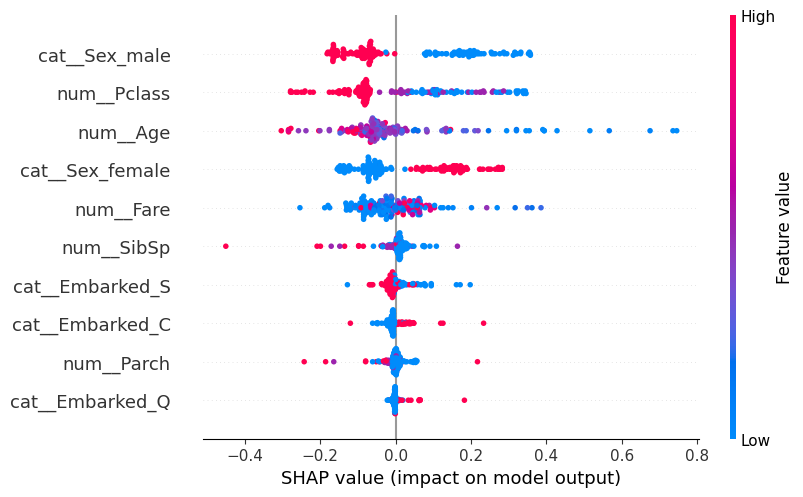

In [155]:
shap.plots.beeswarm(shapsss)

In [64]:
gd_explainer=shap.Explainer(booster_model)
shaps=gd_explainer(x_test, y_test)

In [76]:
type(shaps)

shap._explanation.Explanation

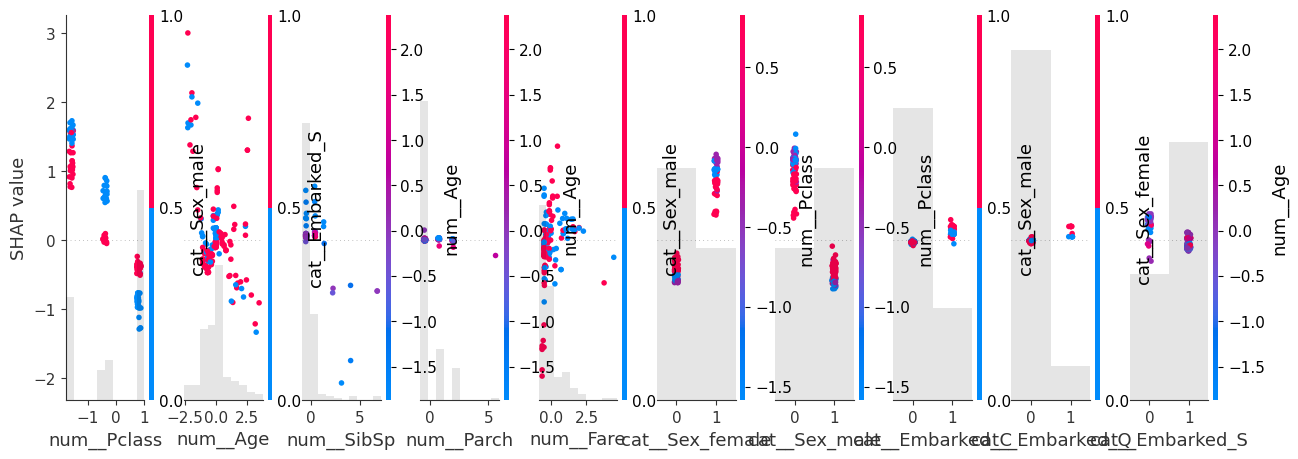

In [75]:

shap.plots.scatter(shaps, color=shaps)

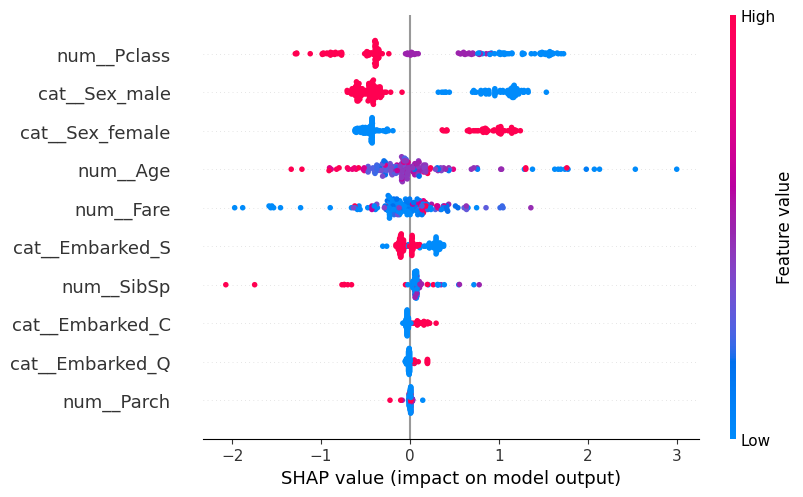

In [66]:
shap.plots.beeswarm(shaps)

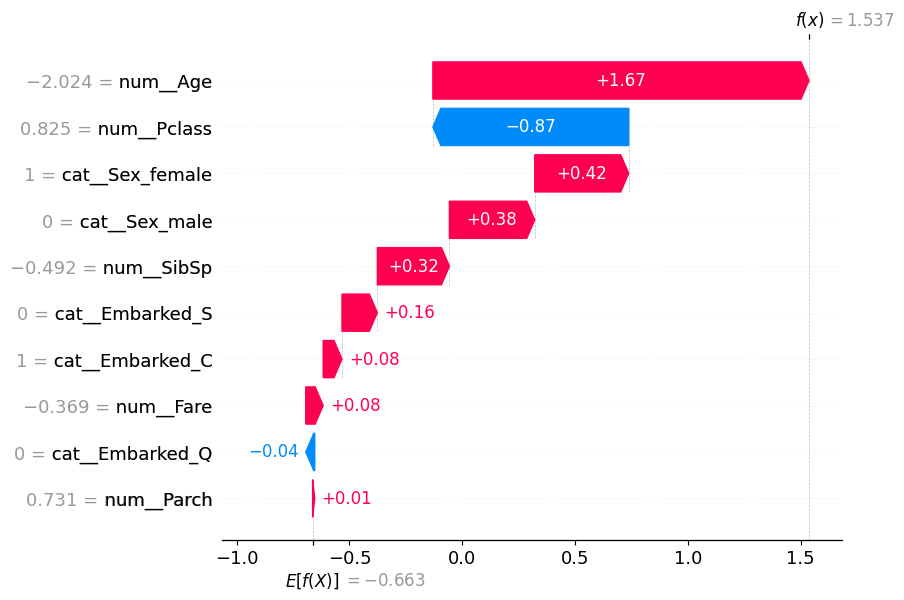

In [67]:
shap.plots.waterfall(shaps[0])